# 1. Install and Import Dependencies


In [1]:
# pip install dython
# pip install pandas
# pip install seaborn
# pip install matplotlib
# pip install numpy
# pip install -U scikit-learn
# pip install keras tensorflow
# download graphiz from here: https://graphviz.org/download/
# pip install graphviz
# pip install pydot
# pip install pillow


In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from dython.nominal import associations
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# 2. Load Data

In [3]:
ds = pd.read_csv("car_kick.csv")

# 3. Explore Data - Data Description

In [4]:
# get shape of dataset
print(ds.shape)

(67211, 31)


In [5]:
# print column names of dataset
ds.columns

Index(['PurchDate', 'VehYear', 'VehicleAge', 'VehOdo',
       'MMRAcquisitionAuctionAveragePrice', 'MMRAcquisitionAuctionCleanPrice',
       'MMRAcquisitionRetailAveragePrice', 'MMRAcquisitonRetailCleanPrice',
       'MMRCurrentAuctionAveragePrice', 'MMRCurrentAuctionCleanPrice',
       'MMRCurrentRetailAveragePrice', 'MMRCurrentRetailCleanPrice',
       'VehBCost', 'WarrantyCost', 'Auction', 'Make', 'Model', 'Trim',
       'SubModel', 'Color', 'Transmission', 'WheelTypeID', 'WheelType',
       'Nationality', 'Size', 'TopThreeAmericanName', 'BYRNO', 'VNZIP1',
       'VNST', 'IsOnlineSale', 'Class'],
      dtype='object')

In [6]:
print(ds.dtypes)

PurchDate                            float64
VehYear                              float64
VehicleAge                             int64
VehOdo                               float64
MMRAcquisitionAuctionAveragePrice    float64
MMRAcquisitionAuctionCleanPrice      float64
MMRAcquisitionRetailAveragePrice     float64
MMRAcquisitonRetailCleanPrice        float64
MMRCurrentAuctionAveragePrice        float64
MMRCurrentAuctionCleanPrice          float64
MMRCurrentRetailAveragePrice         float64
MMRCurrentRetailCleanPrice           float64
VehBCost                             float64
WarrantyCost                         float64
Auction                               object
Make                                  object
Model                                 object
Trim                                  object
SubModel                              object
Color                                 object
Transmission                          object
WheelTypeID                          float64
WheelType 

Attributes in dataset consists of a mixture of numerical and categorical data.   
Numerical - float64, int64   
Categorical - object  

In [7]:
# preview data
print(ds.head())

      PurchDate  VehYear  VehicleAge   VehOdo  \
0  1.289952e+09   2006.0           4  51954.0   
1  1.242691e+09   2005.0           4  89127.0   
2  1.248221e+09   2006.0           3  71271.0   
3  1.285718e+09   2008.0           2  83338.0   
4  1.237334e+09   2007.0           2  58698.0   

   MMRAcquisitionAuctionAveragePrice  MMRAcquisitionAuctionCleanPrice  \
0                             6197.0                           7062.0   
1                             3688.0                           4783.0   
2                             6897.0                           8449.0   
3                             7878.0                           8925.0   
4                             8800.0                          10091.0   

   MMRAcquisitionRetailAveragePrice  MMRAcquisitonRetailCleanPrice  \
0                            9605.0                        10426.0   
1                            4483.0                         5666.0   
2                            7949.0                     

- PurchDate is representing the purchase date from the auction. The data object in this attribute is weird and hard to understand. Hence,  “PurchDate” is recommended to drop it from the dataset. 
- BYRNO represents the car's registration number, which acts as an ID. In data mining, it provides no useful information and should be dropped.  
- VehYear and VehicleAge represent the same thing. Have to drop one of it for the dataset.
- WheelTypeID and WheelType represent the same thing, WheelType will be used in the dataset since it is a more direct way to observe the data. 

In [8]:
# check classifier outputs
ds['Class'].value_counts()

0    60795
1     6416
Name: Class, dtype: int64

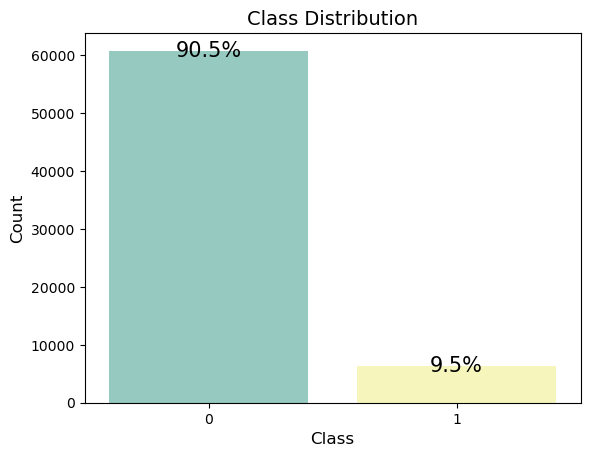

In [9]:
# create the countplot
ax = sns.countplot(x='Class', data=ds, palette=sns.color_palette("Set3"))

# get the total number of observations
total = float(len(ds))

# loop through each bar
for p in ax.patches:
    # get the height and width of the bar
    height = p.get_height()
    width = p.get_width()
    # calculate the percentage value and format it
    percentage = '{:.1f}%'.format((height/total)*100)
    # add the percentage text on the bar
    ax.annotate(percentage, xy=(p.get_x()+width/2, height), ha='center', va='center', fontsize=15)
    
# set the title and axis labels
ax.set_title('Class Distribution', fontsize=14)
ax.set_xlabel('Class', fontsize=12)
ax.set_ylabel('Count', fontsize=12)

# show the plot
plt.show()

In [10]:
# print percentage of 0 and 1 target labels
print("percentage of 0 and 1: \n",ds["Class"].value_counts()/len(ds)*100)

percentage of 0 and 1: 
 0    90.453944
1     9.546056
Name: Class, dtype: float64


Dataset has 10:1 target ratio of '0' and '1'. Thus, data is imbalanced.

## Data Exploration

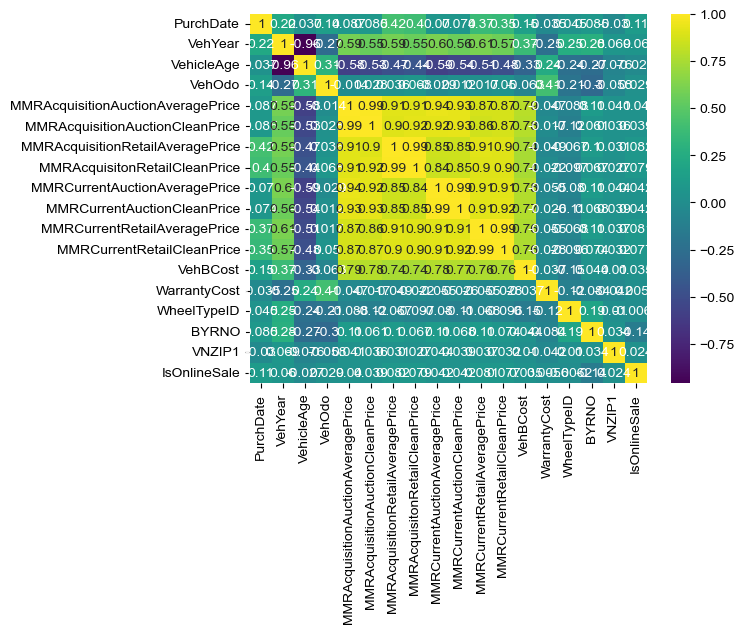

In [11]:
# get correlation matrix of attributes
ds_x = ds.drop(['Class'], axis=1)
ds_x = ds_x.select_dtypes(include=[np.number])
columns = ds_x.columns
correlations = ds_x.corr()
sns.heatmap(data=correlations, annot=True, cmap="viridis")
sns.set(rc={'figure.figsize':(10, 11)})
plt.show()

In [12]:
upper_tri = correlations.where(np.triu(np.ones(correlations.shape),k=1).astype(bool))

high_corr = [column for column in upper_tri.columns if any(upper_tri[column] > 0.9)]

print("Columns with correlation > 0.9: ", high_corr)


Columns with correlation > 0.9:  ['MMRAcquisitionAuctionCleanPrice', 'MMRAcquisitionRetailAveragePrice', 'MMRAcquisitonRetailCleanPrice', 'MMRCurrentAuctionAveragePrice', 'MMRCurrentAuctionCleanPrice', 'MMRCurrentRetailAveragePrice', 'MMRCurrentRetailCleanPrice']


In [13]:
# set correlation treshold
threshold = 0.9

upper_tri = correlations.where(np.triu(np.ones(correlations.shape),k=1).astype(np.bool_))

print(upper_tri)
    
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.9)]

print(to_drop)
    
# find columns with correlation greater than the threshold
corr_cols = correlations.abs().stack().reset_index().\
            rename(columns={0: 'correlation', 'level_0': 'col1', 'level_1': 'col2'})
corr_cols = corr_cols.loc[(corr_cols['col1'] != corr_cols['col2']) & (corr_cols['correlation'] > threshold)]

# print the column names with high correlation
print('Column pairs with correlation greater than', threshold)
for index, row in corr_cols.iterrows():
    print(row['col1'], '-', row['col2'])

                                   PurchDate   VehYear  VehicleAge    VehOdo  \
PurchDate                                NaN  0.215292    0.037169  0.135764   
VehYear                                  NaN       NaN   -0.957778 -0.269816   
VehicleAge                               NaN       NaN         NaN  0.307065   
VehOdo                                   NaN       NaN         NaN       NaN   
MMRAcquisitionAuctionAveragePrice        NaN       NaN         NaN       NaN   
MMRAcquisitionAuctionCleanPrice          NaN       NaN         NaN       NaN   
MMRAcquisitionRetailAveragePrice         NaN       NaN         NaN       NaN   
MMRAcquisitonRetailCleanPrice            NaN       NaN         NaN       NaN   
MMRCurrentAuctionAveragePrice            NaN       NaN         NaN       NaN   
MMRCurrentAuctionCleanPrice              NaN       NaN         NaN       NaN   
MMRCurrentRetailAveragePrice             NaN       NaN         NaN       NaN   
MMRCurrentRetailCleanPrice              

Columns 'MMRAcquisitionAuctionCleanPrice', 'MMRAcquisitionRetailAveragePrice', 'MMRAcquisitonRetailCleanPrice', 'MMRCurrentAuctionAveragePrice', 'MMRCurrentAuctionCleanPrice', 'MMRCurrentRetailAveragePrice', 'MMRCurrentRetailCleanPrice' have correlation above 0.9, indicating that redundant attributes exist and should be considered for removal before data mining algorithm. 

## Categorical Variables

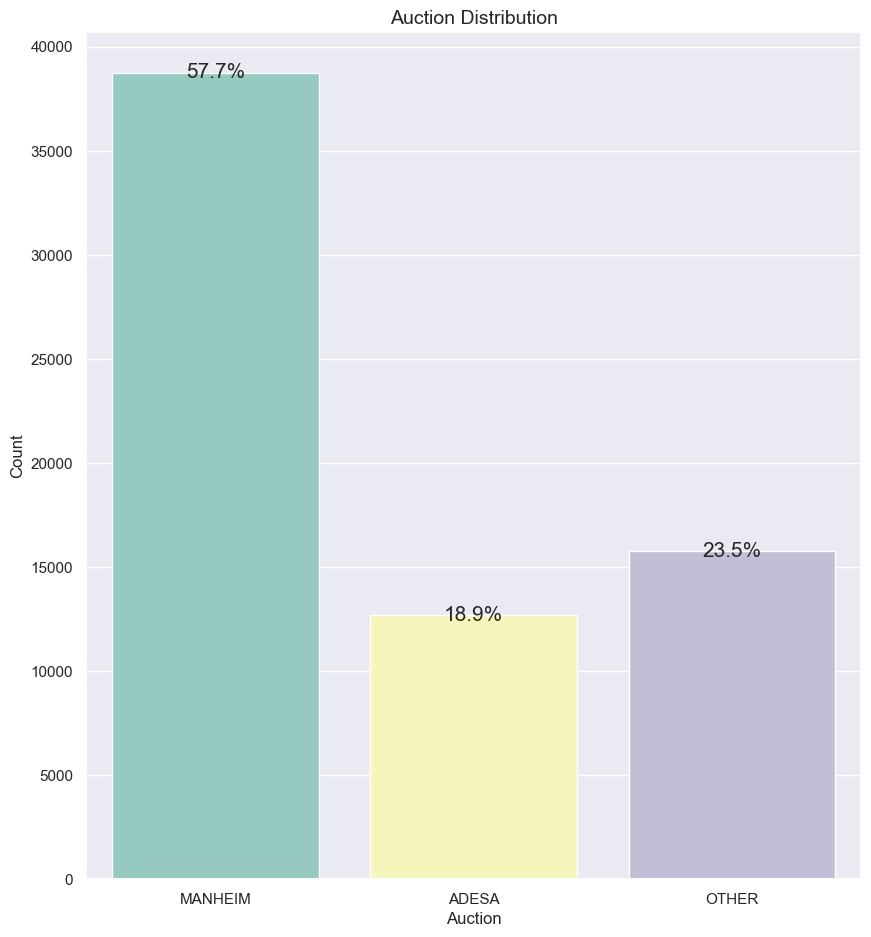

In [14]:
# 1. Auction Location 
# create the countplot
ax = sns.countplot(x='Auction', data=ds, palette=sns.color_palette("Set3"))

# get the total number of observations
total = float(len(ds))

# loop through each bar
for p in ax.patches:
    # get the height and width of the bar
    height = p.get_height()
    width = p.get_width()
    # calculate the percentage value and format it
    percentage = '{:.1f}%'.format((height/total)*100)
    # add the percentage text on the bar
    ax.annotate(percentage, xy=(p.get_x()+width/2, height), ha='center', va='center', fontsize=15)
    
# set the title and axis labels
ax.set_title('Auction Distribution', fontsize=14)
ax.set_xlabel('Auction', fontsize=12)
ax.set_ylabel('Count', fontsize=12)

# show the plot
plt.show()

In [15]:
ds['Auction'].value_counts()/len(ds)

MANHEIM    0.576766
OTHER      0.234590
ADESA      0.188645
Name: Auction, dtype: float64

About 58% of cars purchased were bought from MANEIM, while only 19% of cars were purchased from ADESA.

In [16]:
# 2. Car Model
pd.crosstab(ds['Model'], 'Frequency')

col_0                   Frequency
Model                            
'1500 RAM PICKUP 2WD'        1066
'1500 RAM PICKUP 4WD'          55
'1500 SIERRA PICKUP 2'        128
'1500 SIERRA PICKUP 4'          4
'1500 SILVERADO PICKU'        578
...                           ...
VERSA                          52
VIBE                          115
XA                             15
XB                             39
YARIS                          37

[953 rows x 1 columns]

In [17]:
# 3. Trim
pd.crosstab(ds['Trim'], 'Frequency')


col_0  Frequency
Trim            
'3 R'          7
'L 3'          1
1            164
150          288
2            724
...          ...
ZXW           30
eC             4
eL             8
i            460
s            203

[133 rows x 1 columns]

In [18]:
# 4. Submodel
pd.crosstab(ds['SubModel'], 'Frequency')


col_0                           Frequency
SubModel                                 
'2D CONVERTIBLE DREAM CRUISER'          8
'2D CONVERTIBLE GL'                     1
'2D CONVERTIBLE GLS'                    3
'2D CONVERTIBLE GT'                     9
'2D CONVERTIBLE GTC'                   32
...                                   ...
'WAGON LX'                             22
'WAGON R/T'                             7
'WAGON SXT AWD'                         2
BASE                                    4
UTILITY                                 1

[823 rows x 1 columns]

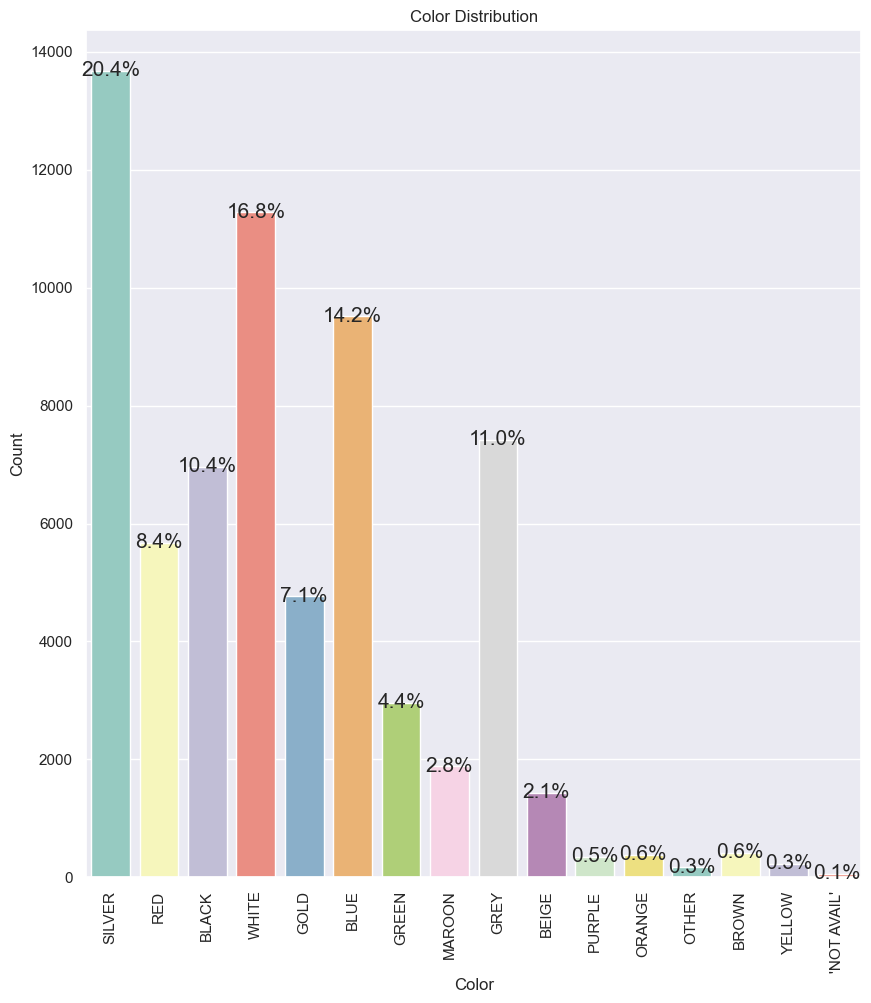

In [19]:
# 5. Colour
# create the countplot
ax = sns.countplot(x='Color', data=ds, palette=sns.color_palette("Set3"))

# Set x-tick labels rotation angle
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

# get the total number of observations
total = float(len(ds))

# loop through each bar
for p in ax.patches:
    # get the height and width of the bar
    height = p.get_height()
    width = p.get_width()
    # calculate the percentage value and format it
    percentage = '{:.1f}%'.format((height/total)*100)
    # add the percentage text on the bar
    ax.annotate(percentage, xy=(p.get_x()+width/2, height), ha='center', va='center', fontsize=15)
    
# set the title and axis labels
ax.set_title('Color Distribution', fontsize=12)
ax.set_xlabel('Color', fontsize=12)
ax.set_ylabel('Count', fontsize=12)

# show the plot
plt.show()

Top 3 common colours are 'silver', 'white', and 'blue'. Least common available colour is 'other'

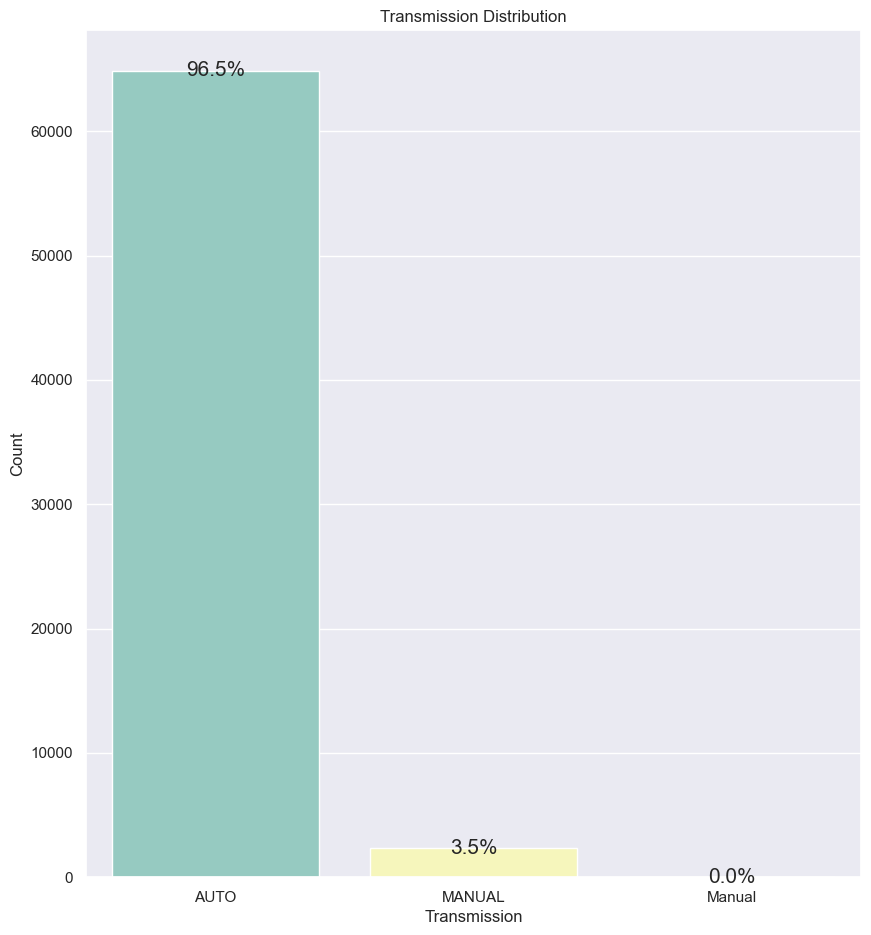

In [20]:
# 6. Transmission Type
# create the countplot
ax = sns.countplot(x='Transmission', data=ds, palette=sns.color_palette("Set3"))

# Set x-tick labels rotation angle
#ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

# get the total number of observations
total = float(len(ds))

# loop through each bar
for p in ax.patches:
    # get the height and width of the bar
    height = p.get_height()
    width = p.get_width()
    # calculate the percentage value and format it
    percentage = '{:.1f}%'.format((height/total)*100)
    # add the percentage text on the bar
    ax.annotate(percentage, xy=(p.get_x()+width/2, height), ha='center', va='center', fontsize=15)
    
# set the title and axis labels
ax.set_title('Transmission Distribution', fontsize=12)
ax.set_xlabel('Transmission', fontsize=12)
ax.set_ylabel('Count', fontsize=12)

# show the plot
plt.show()

In [21]:
ds['Transmission'].value_counts()/len(ds)

AUTO      0.965184
MANUAL    0.034801
Manual    0.000015
Name: Transmission, dtype: float64

97% of cars purchased were auto, while the remaining cars are manual.  
The use of upper and lowercase for 'manual' requires cleaning for congruency.


In [22]:
# 7. Wheel Type
ds['WheelType'].value_counts()

Alloy      34780
Covers     31701
Special      730
Name: WheelType, dtype: int64

In [23]:
# 8. Wheel Type ID
ds['WheelTypeID'].value_counts()

1.0    34780
2.0    31701
3.0      730
Name: WheelTypeID, dtype: int64

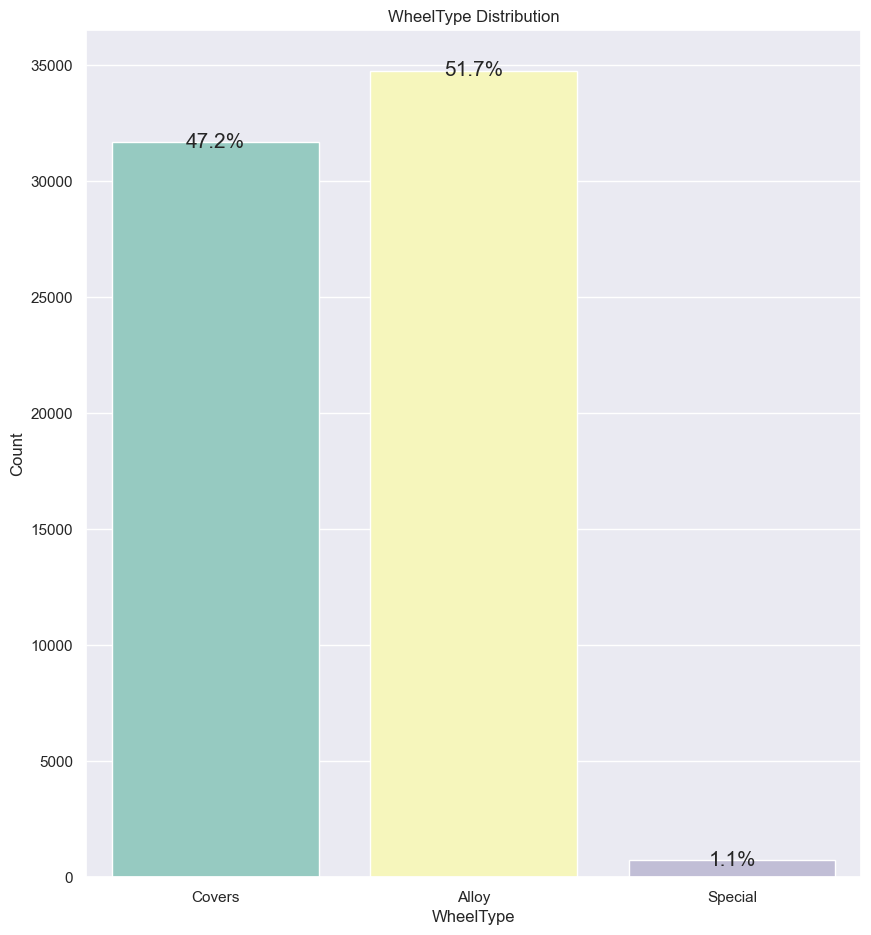

In [24]:
# create the countplot
ax = sns.countplot(x='WheelType', data=ds, palette=sns.color_palette("Set3"))

# Set x-tick labels rotation angle
#ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

# get the total number of observations
total = float(len(ds))

# loop through each bar
for p in ax.patches:
    # get the height and width of the bar
    height = p.get_height()
    width = p.get_width()
    # calculate the percentage value and format it
    percentage = '{:.1f}%'.format((height/total)*100)
    # add the percentage text on the bar
    ax.annotate(percentage, xy=(p.get_x()+width/2, height), ha='center', va='center', fontsize=15)
    
# set the title and axis labels
ax.set_title('WheelType Distribution', fontsize=12)
ax.set_xlabel('WheelType', fontsize=12)
ax.set_ylabel('Count', fontsize=12)

# show the plot
plt.show()

'WheelTypeID' is the encoded label of 'WheelType'. 
Suggestion: one of the two columns 'WheelType' and 'WheelTypeID' should be removed as both refer to the same attribute.    

If label in encoded form is prefered for data mining, then 'WheelType' can be removed.

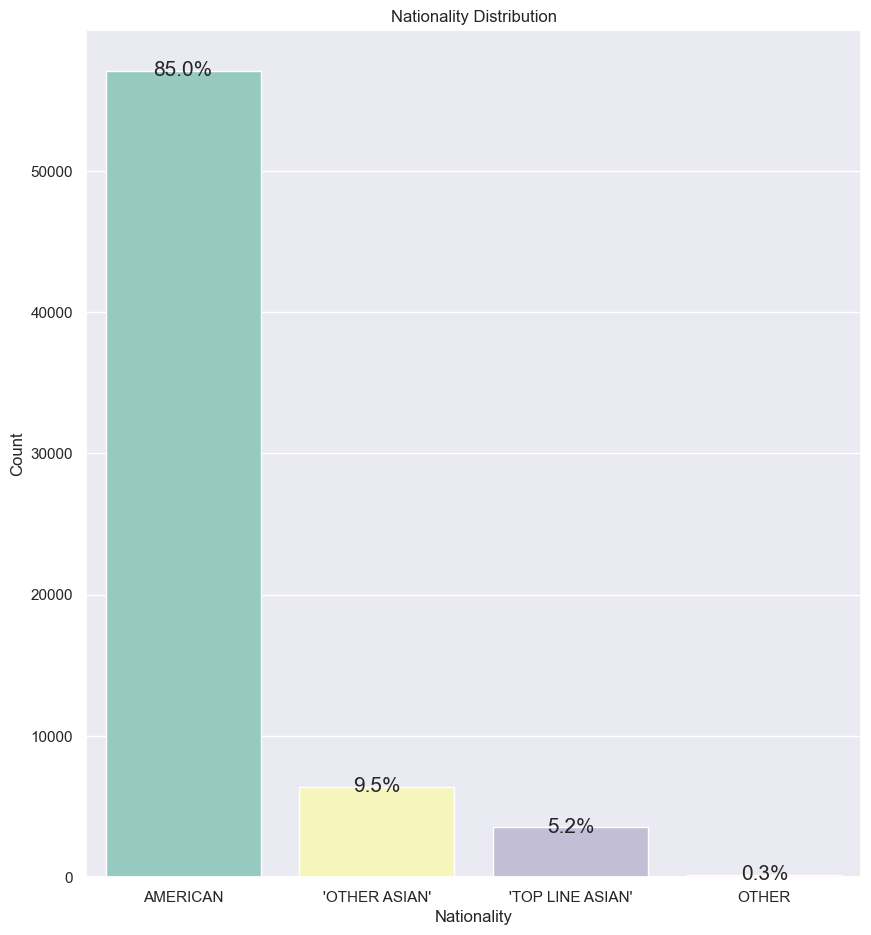

In [25]:
# 9. Nationality
# create the countplot
ax = sns.countplot(x='Nationality', data=ds, palette=sns.color_palette("Set3"))

# Set x-tick labels rotation angle
#ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

# get the total number of observations
total = float(len(ds))

# loop through each bar
for p in ax.patches:
    # get the height and width of the bar
    height = p.get_height()
    width = p.get_width()
    # calculate the percentage value and format it
    percentage = '{:.1f}%'.format((height/total)*100)
    # add the percentage text on the bar
    ax.annotate(percentage, xy=(p.get_x()+width/2, height), ha='center', va='center', fontsize=15)
    
# set the title and axis labels
ax.set_title('Nationality Distribution', fontsize=12)
ax.set_xlabel('Nationality', fontsize=12)
ax.set_ylabel('Count', fontsize=12)

# show the plot
plt.show()

In [26]:
ds['Nationality'].value_counts()/len(ds)

AMERICAN            0.849548
'OTHER ASIAN'       0.095327
'TOP LINE ASIAN'    0.052462
OTHER               0.002663
Name: Nationality, dtype: float64

85% of cars purchased are of American nationality, while the remaining are either Asian or some other nationality.

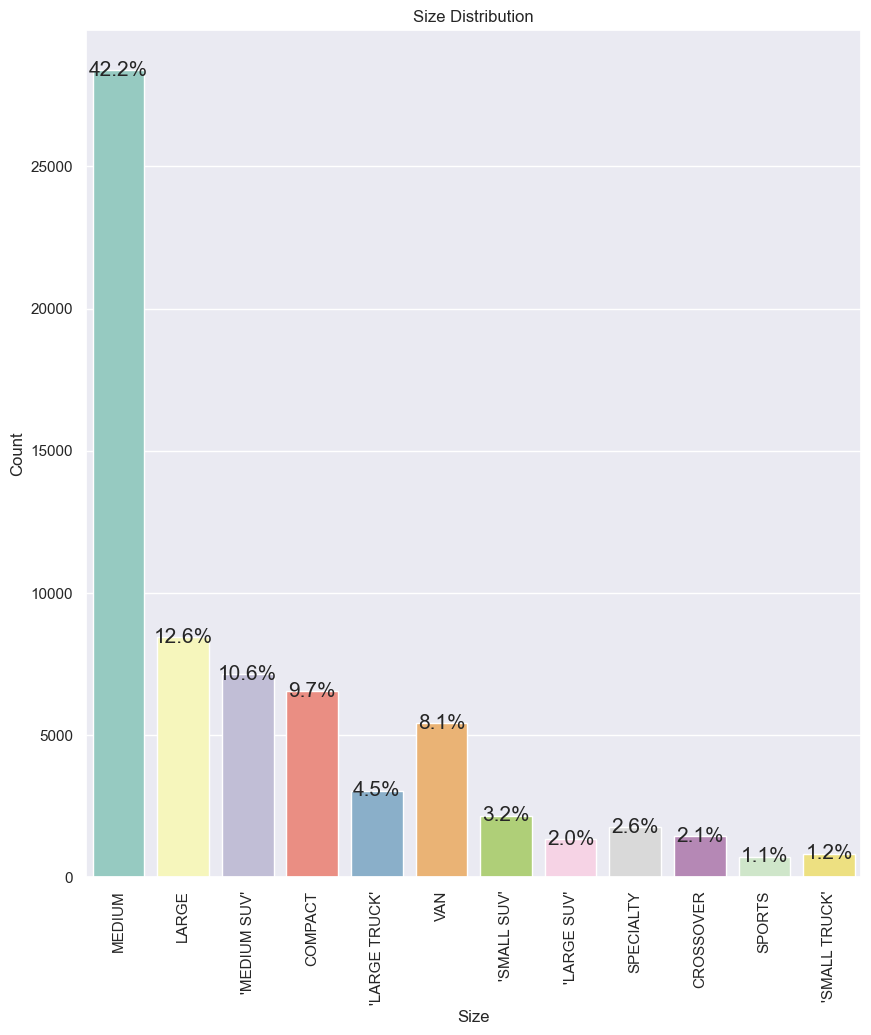

In [27]:
# 10. Size (Car Types)
# create the countplot
ax = sns.countplot(x='Size', data=ds, palette=sns.color_palette("Set3"))

# Set x-tick labels rotation angle
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

# get the total number of observations
total = float(len(ds))

# loop through each bar
for p in ax.patches:
    # get the height and width of the bar
    height = p.get_height()
    width = p.get_width()
    # calculate the percentage value and format it
    percentage = '{:.1f}%'.format((height/total)*100)
    # add the percentage text on the bar
    ax.annotate(percentage, xy=(p.get_x()+width/2, height), ha='center', va='center', fontsize=15)
    
# set the title and axis labels
ax.set_title('Size Distribution', fontsize=12)
ax.set_xlabel('Size', fontsize=12)
ax.set_ylabel('Count', fontsize=12)

# show the plot
plt.show()

While there are no typing errors whereby more than one value points to the same value, in the data cleaning step, single quotations, ', can be removed for consistency and cleanliness of data.   
Medium-sized cars show a 42.2% contribution to total purchased cars, while sports cars are most rare (1.1%)

In [28]:
pd.crosstab(ds['Size'], 'Frequency').apply(lambda c: c/c.sum(), axis=0)

col_0          Frequency
Size                    
'LARGE SUV'     0.019967
'LARGE TRUCK'   0.045290
'MEDIUM SUV'    0.106367
'SMALL SUV'     0.032167
'SMALL TRUCK'   0.012230
COMPACT         0.097395
CROSSOVER       0.021321
LARGE           0.125634
MEDIUM          0.422178
SPECIALTY       0.025993
SPORTS          0.010787
VAN             0.080671

Most commonly, 42% of cars purchased are medium-saloons, while the rarest purchased car size, 1%, is sports.

In [29]:
# 11. Make (Car Manufacturer)
ds['Make'].value_counts()


CHEVROLET         16517
DODGE             12403
FORD              10687
CHRYSLER           8115
PONTIAC            3783
KIA                2284
NISSAN             1966
HYUNDAI            1707
SATURN             1679
JEEP               1554
TOYOTA             1096
MITSUBISHI          968
MAZDA               882
MERCURY             792
BUICK               676
GMC                 622
HONDA               468
SUZUKI              276
OLDSMOBILE          224
ISUZU               130
VOLKSWAGEN          118
SCION               103
VOLVO                37
LINCOLN              31
SUBARU               25
MINI                 24
ACURA                23
CADILLAC             14
INFINITI              3
PLYMOUTH              2
'TOYOTA SCION'        1
LEXUS                 1
Name: Make, dtype: int64

In [30]:
# 12. Top Three American Name (Grouping of car manufacturer)
ds['TopThreeAmericanName'].value_counts()

GM          23515
CHRYSLER    22074
FORD        11510
OTHER       10112
Name: TopThreeAmericanName, dtype: int64

There are inconsistencies between columns 'Make' and 'TopThreeAmericanName', which segregates rows into categories of Ford, Chrysler, GM or other car manufacturers. Eg:  
Number of CHRYSLER's in 'TopThreeAmericanName' = 22074  
Number of CHRYSLER's in 'Make' = 8115  
Suggestion: 'TopThreeAmericanName' should be dropped to prevent such inconsistencies.

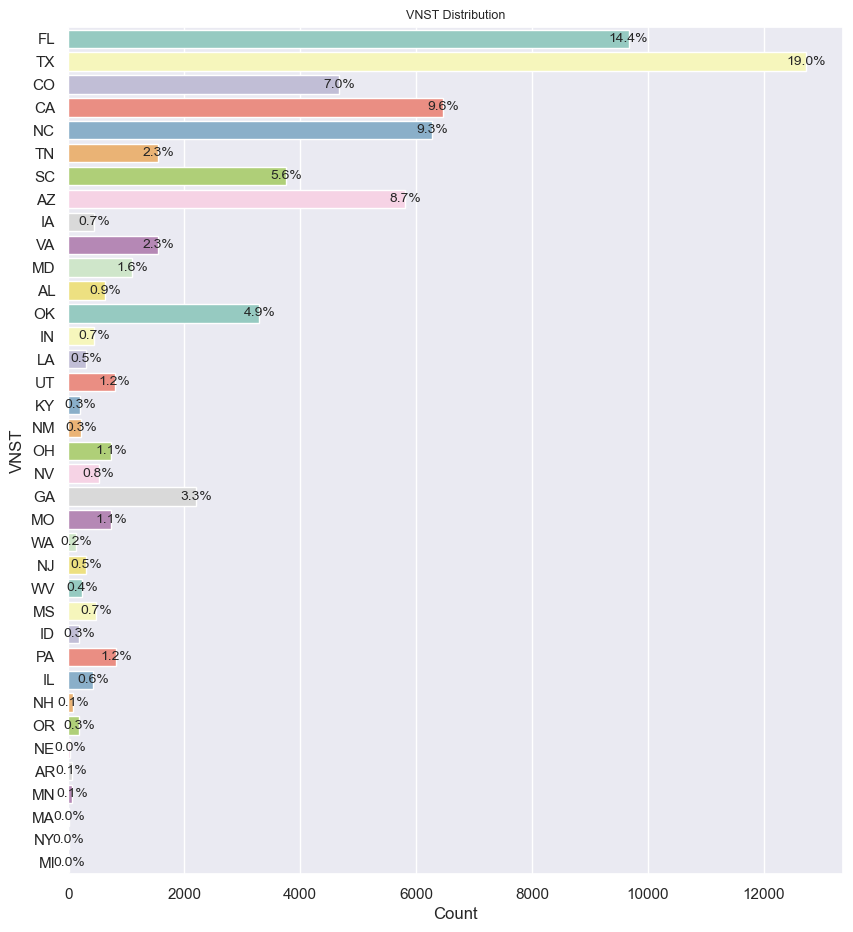

In [31]:
# 13. VNST (Car Navigation System)
# create the countplot
ax = sns.countplot(y='VNST', data=ds, palette=sns.color_palette("Set3"))

# Set x-tick labels rotation angle
#ax.set_yticklabels(ax.get_yticklabels(), rotation=90)

# get the total number of observations
total = float(len(ds))

# loop through each bar
for p in ax.patches:
    # get the height and width of the bar
    height = p.get_height()
    width = p.get_width()
    # calculate the percentage value and format it
    percentage = '{:.1f}%'.format((width/total)*100)
    # add the percentage text on the bar
    ax.annotate(percentage, xy=(width, p.get_y()+height/2), ha='center', va='center', fontsize=10)
    
# set the title and axis labels
ax.set_title('VNST Distribution', fontsize=9)
ax.set_xlabel('Count', fontsize=12)
ax.set_ylabel('VNST', fontsize=12)

# show the plot
plt.show()

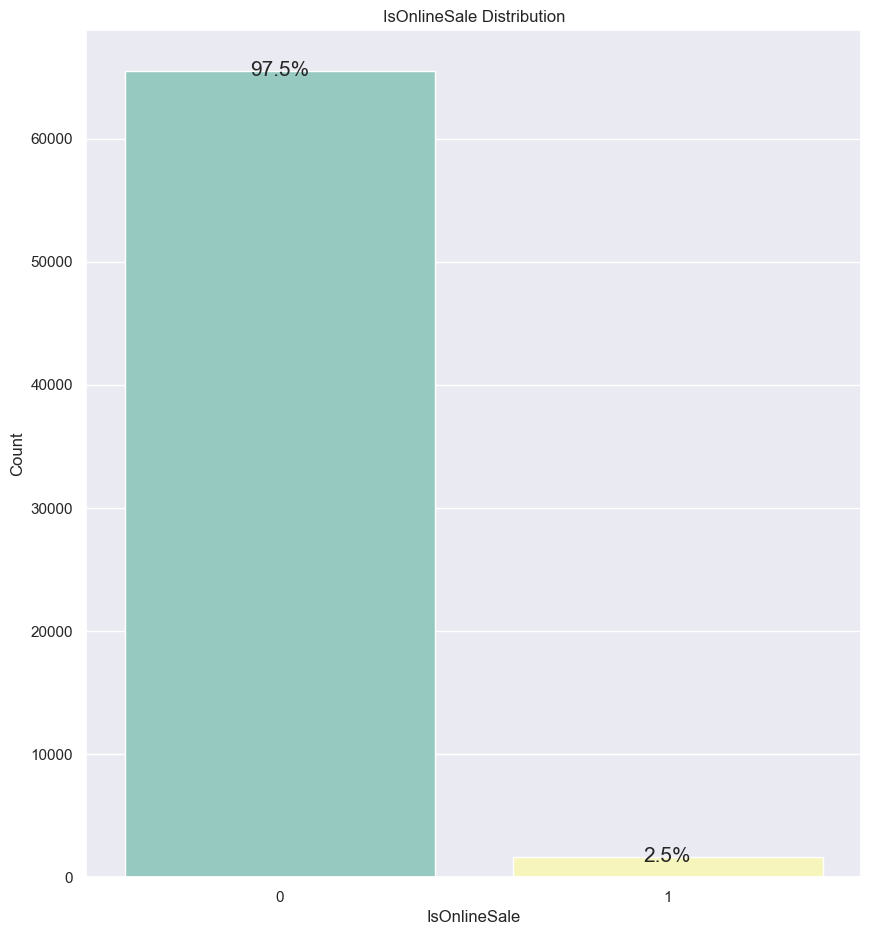

In [32]:
# 14. Is Online Sale
# create the countplot
ax = sns.countplot(x='IsOnlineSale', data=ds, palette=sns.color_palette("Set3"))

# Set x-tick labels rotation angle
#ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

# get the total number of observations
total = float(len(ds))

# loop through each bar
for p in ax.patches:
    # get the height and width of the bar
    height = p.get_height()
    width = p.get_width()
    # calculate the percentage value and format it
    percentage = '{:.1f}%'.format((height/total)*100)
    # add the percentage text on the bar
    ax.annotate(percentage, xy=(p.get_x()+width/2, height), ha='center', va='center', fontsize=15)
    
# set the title and axis labels
ax.set_title('IsOnlineSale Distribution', fontsize=12)
ax.set_xlabel('IsOnlineSale', fontsize=12)
ax.set_ylabel('Count', fontsize=12)

# show the plot
plt.show()

In [33]:
ds['IsOnlineSale'].value_counts()/len(ds)

0    0.974945
1    0.025055
Name: IsOnlineSale, dtype: float64

97% of purchased cars were not bought through an online sale

In [34]:
# 15. Car ZIP Number (Postal code of area where the car was used most)
ds['VNZIP1'].value_counts()

32824    3444
27542    3058
75236    2289
74135    2138
80022    2021
         ... 
16137       2
80112       1
25071       1
85248       1
85338       1
Name: VNZIP1, Length: 150, dtype: int64

Year of production of vehicle is left skewed, meaning newer produced cars were purchased by the auto dealership.

## Numerical Variables

In [35]:
# 16. Purchase Date
ds['PurchDate'].head()

0    1.289952e+09
1    1.242691e+09
2    1.248221e+09
3    1.285718e+09
4    1.237334e+09
Name: PurchDate, dtype: float64

In [36]:
ds['PurchDate'].astype('object').head()

0    1289952000.0
1    1242691200.0
2    1248220800.0
3    1285718400.0
4    1237334400.0
Name: PurchDate, dtype: object

Even after converting scientific notation to an object data, such that all digits can be read, it is still unintepretable as date.   
Suggestion: since date of purchase provide no predictive value, on top of being unintepretable, it should be removed.

Text(0.5, 0, 'Year')

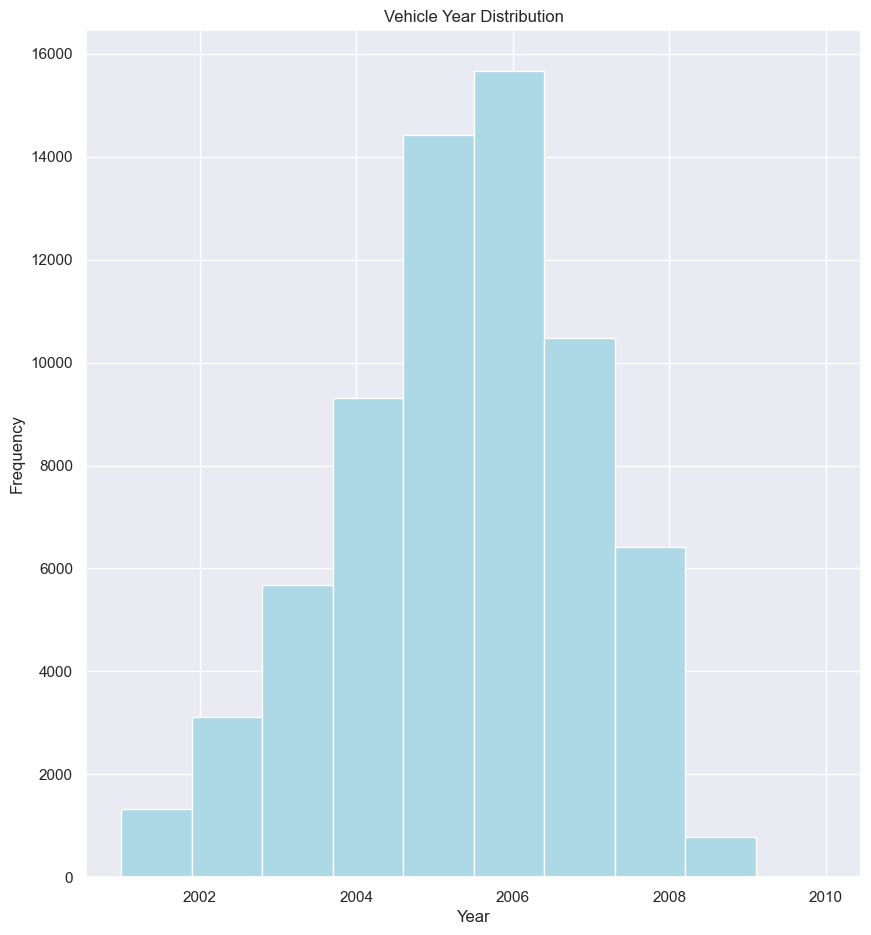

In [37]:
# 17. Vehicle Year (Year of production of car)
ds['VehYear'].plot.hist(bins = 10, color="lightblue")
plt.title('Vehicle Year Distribution')
plt.xlabel('Year')

Text(0.5, 0, 'Age')

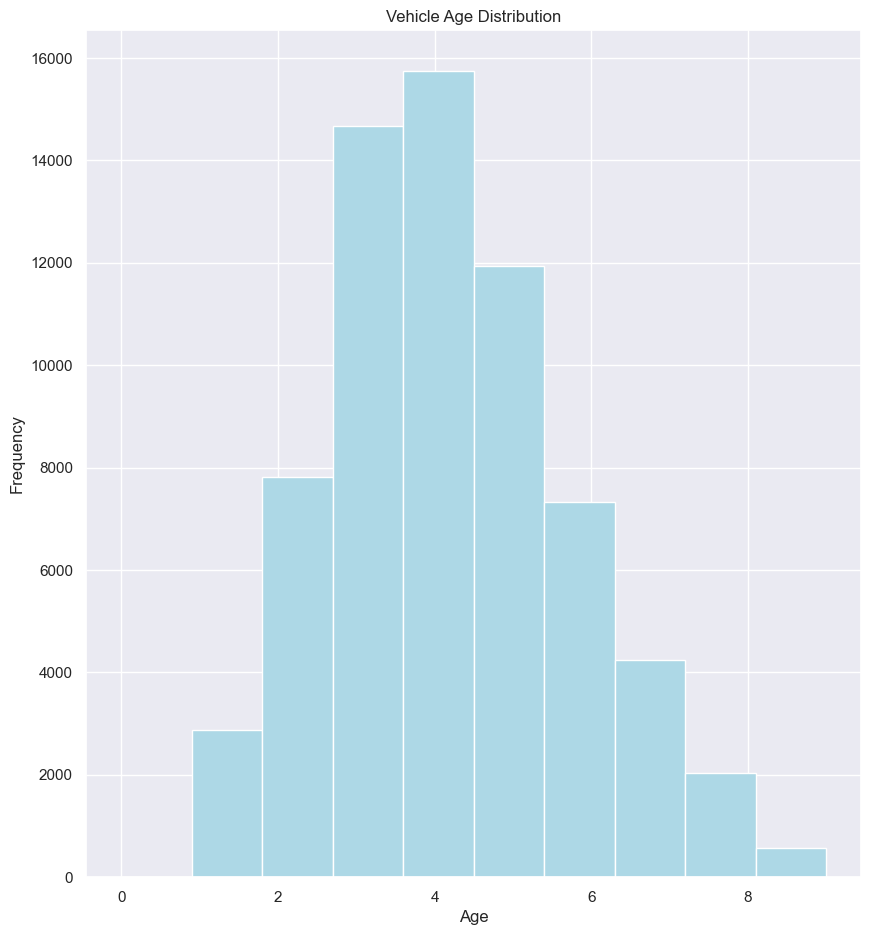

In [38]:
# 18. Vehicle Age
ds['VehicleAge'].plot.hist(bins = 10, color="lightblue")
plt.title('Vehicle Age Distribution')
plt.xlabel('Age')

Vehicle age is right skewed, following the production year of cars purchased.   
Reiterating, this means newer cars were bought by the auto dealership.  
Since it is obvious that 'VehicleAge' can be derived from 'VehYear', it is suggested to remove 'VehYear'

Text(0.5, 0, 'Odometer Reading')

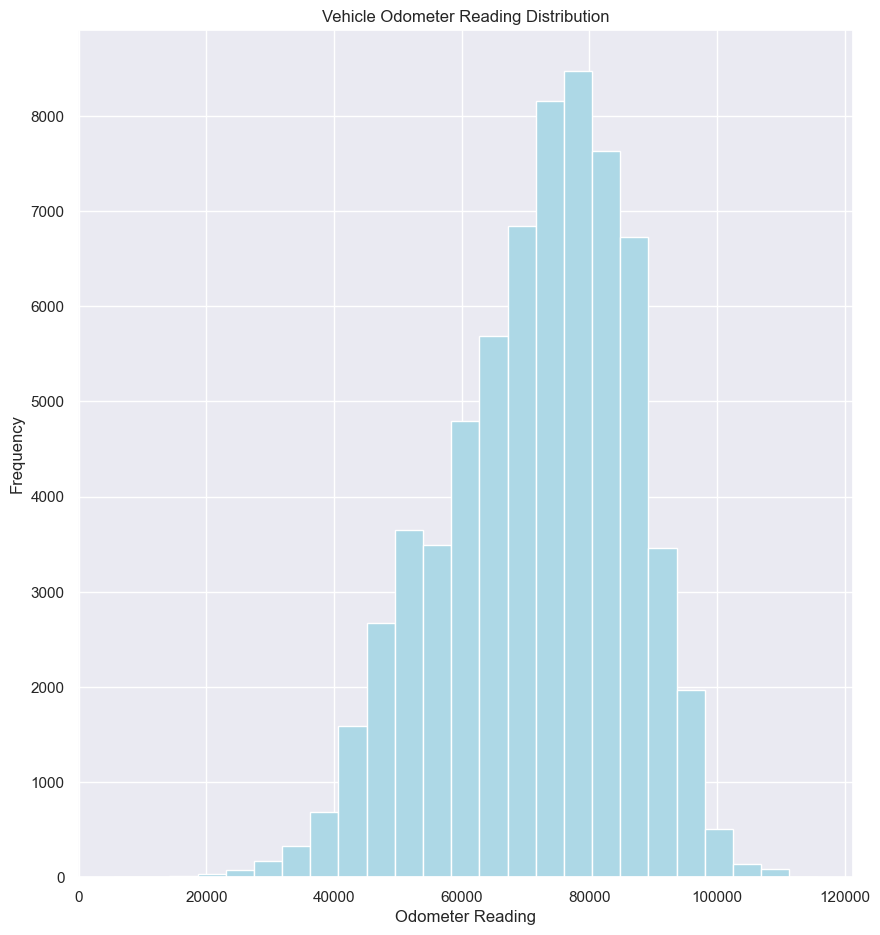

In [39]:
# 19. Vehicle ODO
ds['VehOdo'].plot.hist(bins = 25, color="lightblue")
plt.title('Vehicle Odometer Reading Distribution')
plt.xlabel('Odometer Reading')

Vehicle ODO is left-skewed, more cars purchased were driven over longer distances around 80,000km.

Text(0.5, 110.24999999999996, 'Current Retail Clean Price')

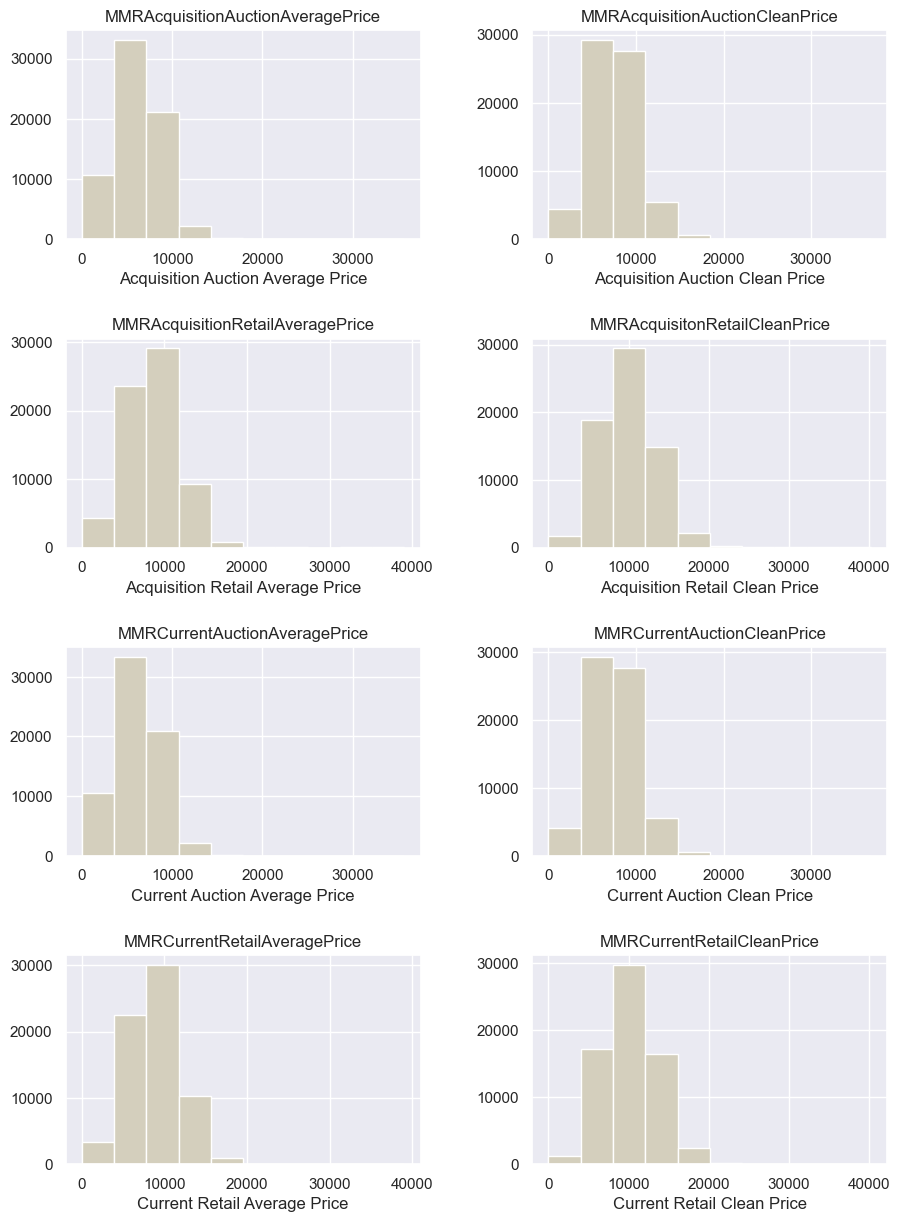

In [40]:
# MAYBE DELETE THIS AND KEEP THE ONE BELOW 
# 20. Acquisition Auction Average Price
# 22. Acquisition Auction Clean Price
# 22. Acquisition Retail Average Price
# 23. Acquisiton Retail Clean Price
# 24. Current Auction Average Price
# 25. Current Auction Clean Price
# 26. Current Retail Average Price
# 27. Current Retail Clean Price

fig, axs = plt.subplots(4, 2, figsize=(10, 13))

fig.tight_layout(pad=4.0)

axs[0,0].hist(ds['MMRAcquisitionAuctionAveragePrice'], bins=10, color='#D4CFBD')
axs[0,0].set_title('MMRAcquisitionAuctionAveragePrice')
axs[0,0].set_xlabel('Acquisition Auction Average Price')

axs[0,1].hist(ds['MMRAcquisitionAuctionCleanPrice'], bins=10, color='#D4CFBD')
axs[0,1].set_title('MMRAcquisitionAuctionCleanPrice')
axs[0,1].set_xlabel('Acquisition Auction Clean Price')

axs[1,0].hist(ds['MMRAcquisitionRetailAveragePrice'], bins=10, color='#D4CFBD')
axs[1,0].set_title('MMRAcquisitionRetailAveragePrice')
axs[1,0].set_xlabel('Acquisition Retail Average Price')

axs[1,1].hist(ds['MMRAcquisitonRetailCleanPrice'], bins=10, color='#D4CFBD')
axs[1,1].set_title('MMRAcquisitonRetailCleanPrice')
axs[1,1].set_xlabel('Acquisition Retail Clean Price')

axs[2,0].hist(ds['MMRCurrentAuctionAveragePrice'], bins=10, color='#D4CFBD')
axs[2,0].set_title('MMRCurrentAuctionAveragePrice')
axs[2,0].set_xlabel('Current Auction Average Price')

axs[2,1].hist(ds['MMRCurrentAuctionCleanPrice'], bins=10, color='#D4CFBD')
axs[2,1].set_title('MMRCurrentAuctionCleanPrice')
axs[2,1].set_xlabel('Current Auction Clean Price')

axs[3,0].hist(ds['MMRCurrentRetailAveragePrice'], bins=10, color='#D4CFBD')
axs[3,0].set_title('MMRCurrentRetailAveragePrice')
axs[3,0].set_xlabel('Current Retail Average Price')

axs[3,1].hist(ds['MMRCurrentRetailCleanPrice'], bins=10, color='#D4CFBD')
axs[3,1].set_title('MMRCurrentRetailCleanPrice')
axs[3,1].set_xlabel('Current Retail Clean Price')

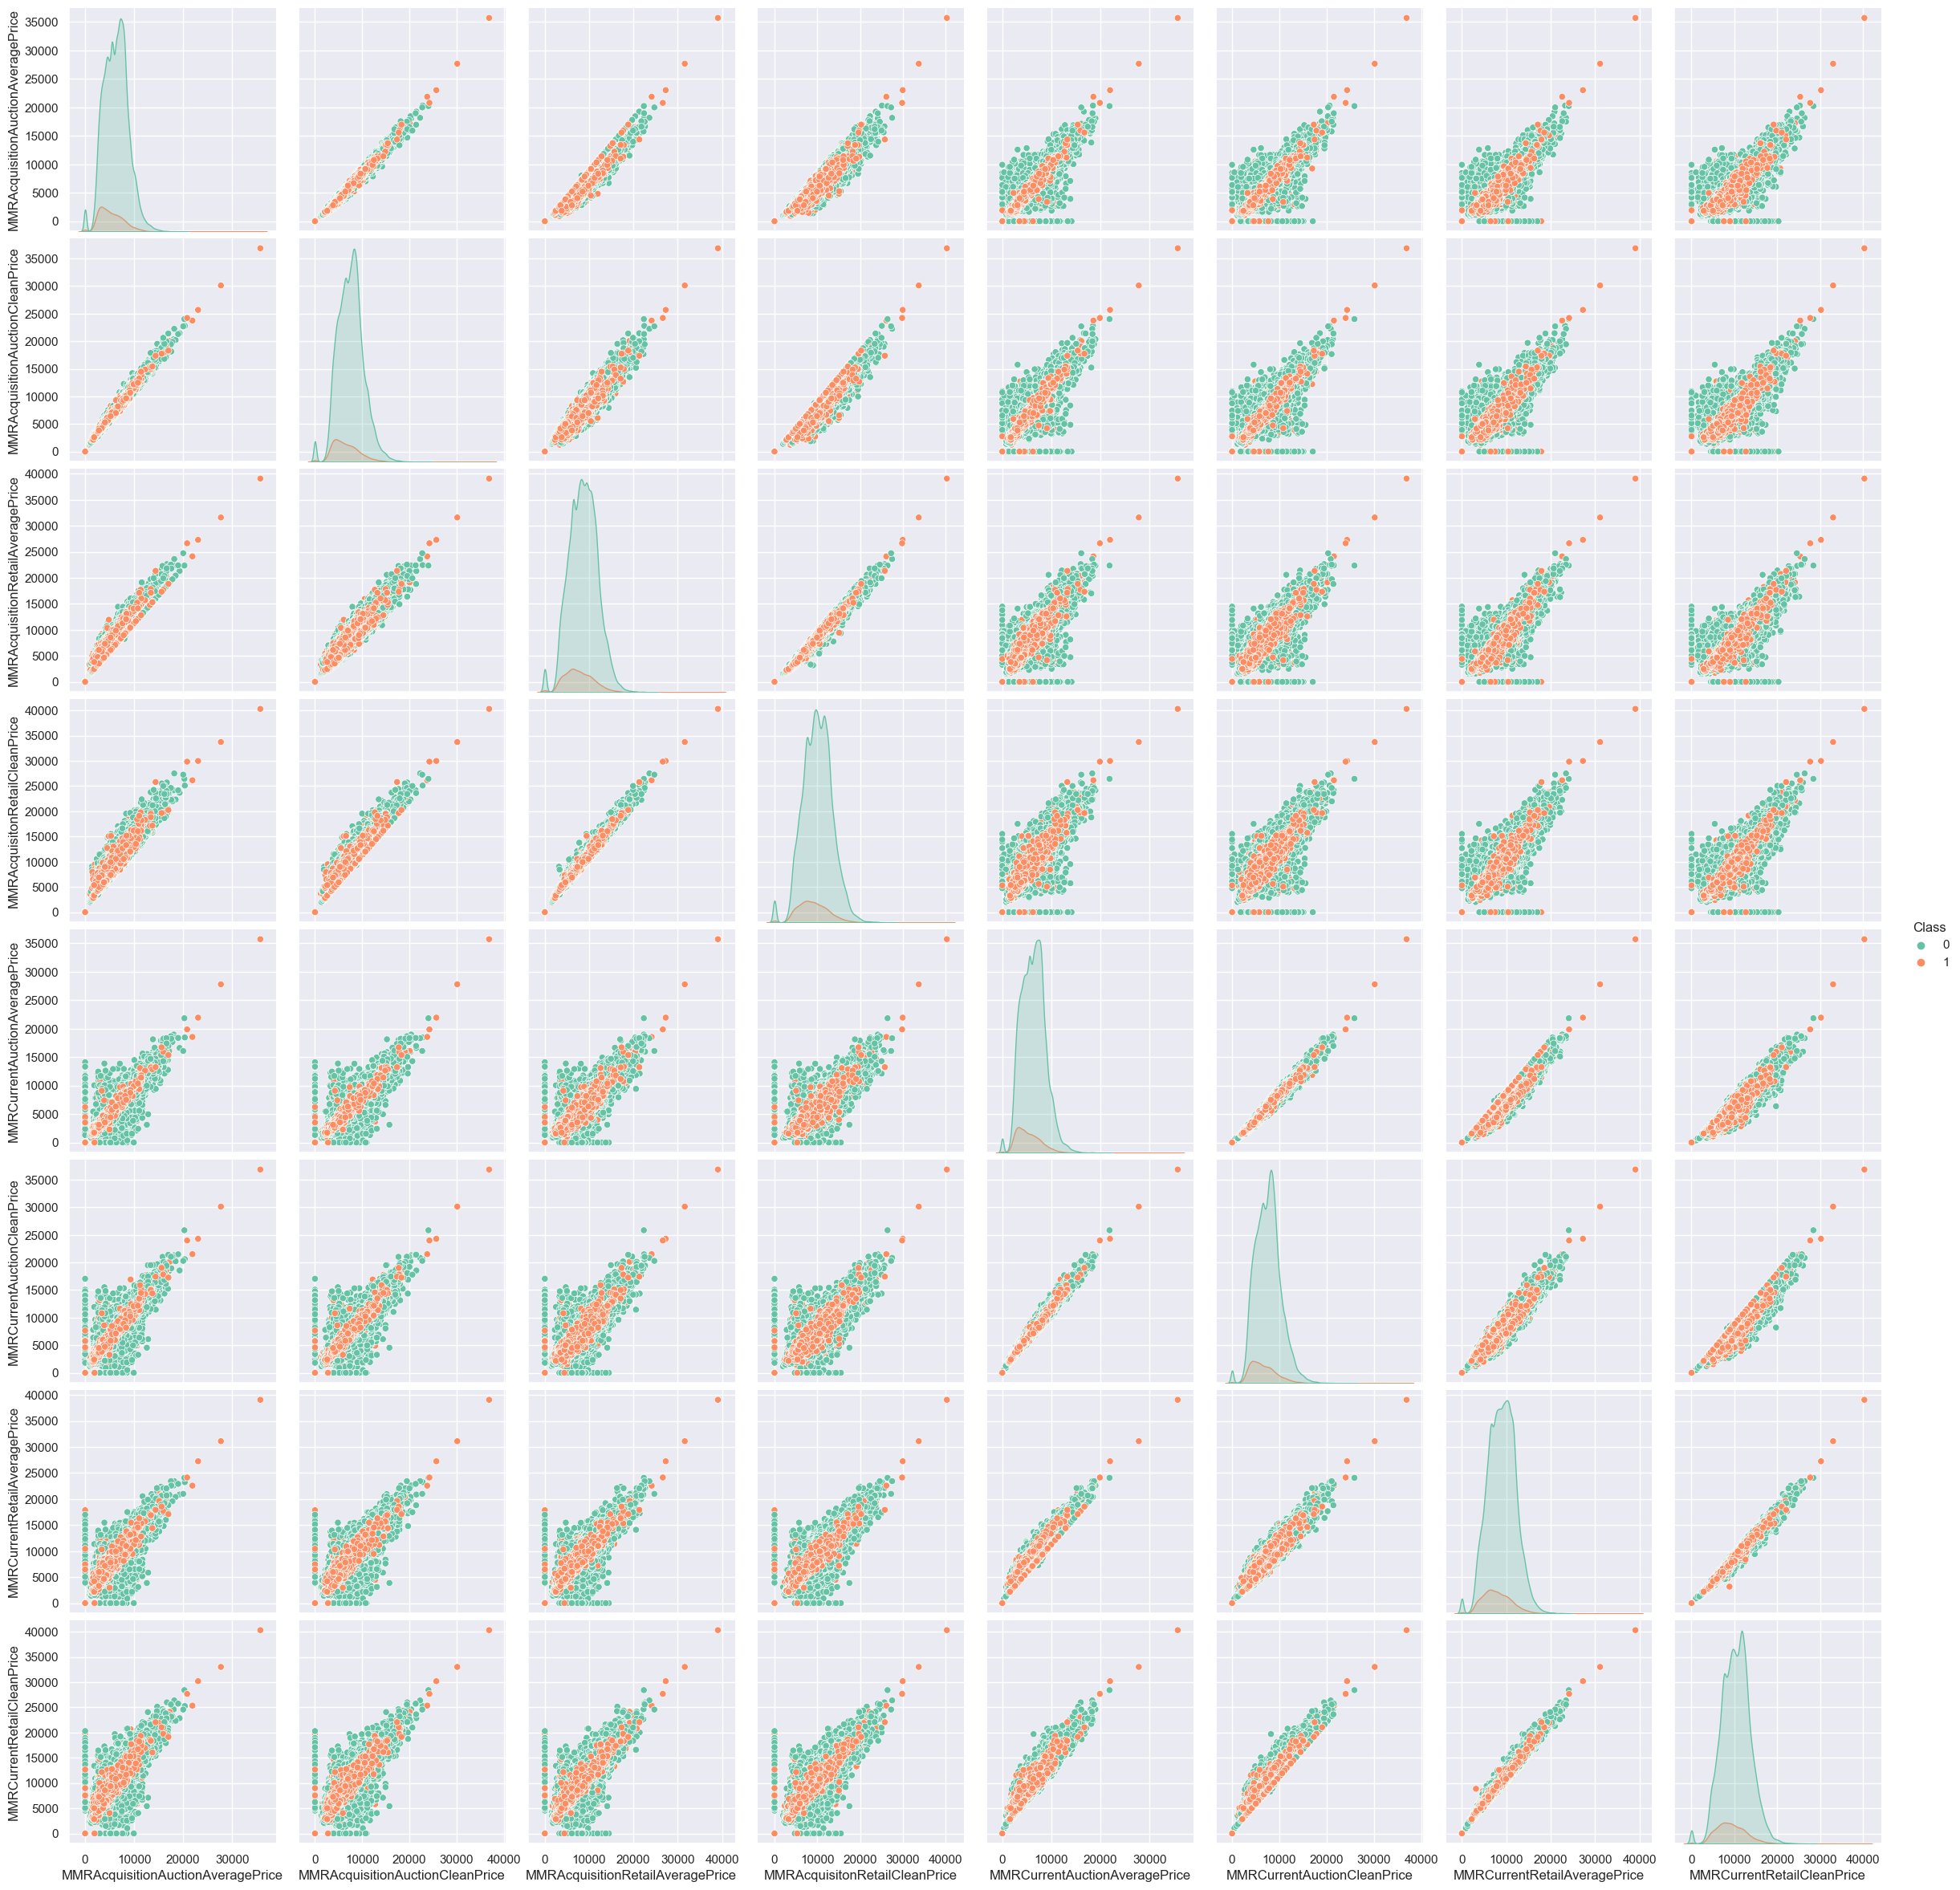

In [41]:
ds_mmr = ['MMRAcquisitionAuctionAveragePrice', 'MMRAcquisitionAuctionCleanPrice', \
                'MMRAcquisitionRetailAveragePrice', 'MMRAcquisitonRetailCleanPrice', \
                'MMRCurrentAuctionAveragePrice', \
                'MMRCurrentAuctionCleanPrice', \
                'MMRCurrentRetailAveragePrice',\
                'MMRCurrentRetailCleanPrice']

sns.pairplot(data=ds, vars=ds_mmr, hue = "Class", height = 3, palette="Set2")
plt.show()

The above shows the **average and cleaned** distribution of:
- acquisition auction vs acquisition retail price
- current auction vs current retail price

The output distribution of graphs act as a confirmation to the result of the correlation matrix that says that the above columns are highly correlated.   

The **cleaned** prices are generally a **positive shift** of the **average prices**.     
The **retail** prices are also a positive shift of its correspondinig **acquisaition or current prices**. 

Suggestion: leave only the cleaned retail value of acquisition and current prices, and discard the rest. Then create a new attribute for the potential value of car, 'potential_value' = 'MMRCurrentRetailCleanPrice'- 'MMRAcquisitonRetailCleanPrice'.   

The size of this difference provides the relative potential value of the car purchased. 

Text(0.5, 0, 'Vehicle B Cost')

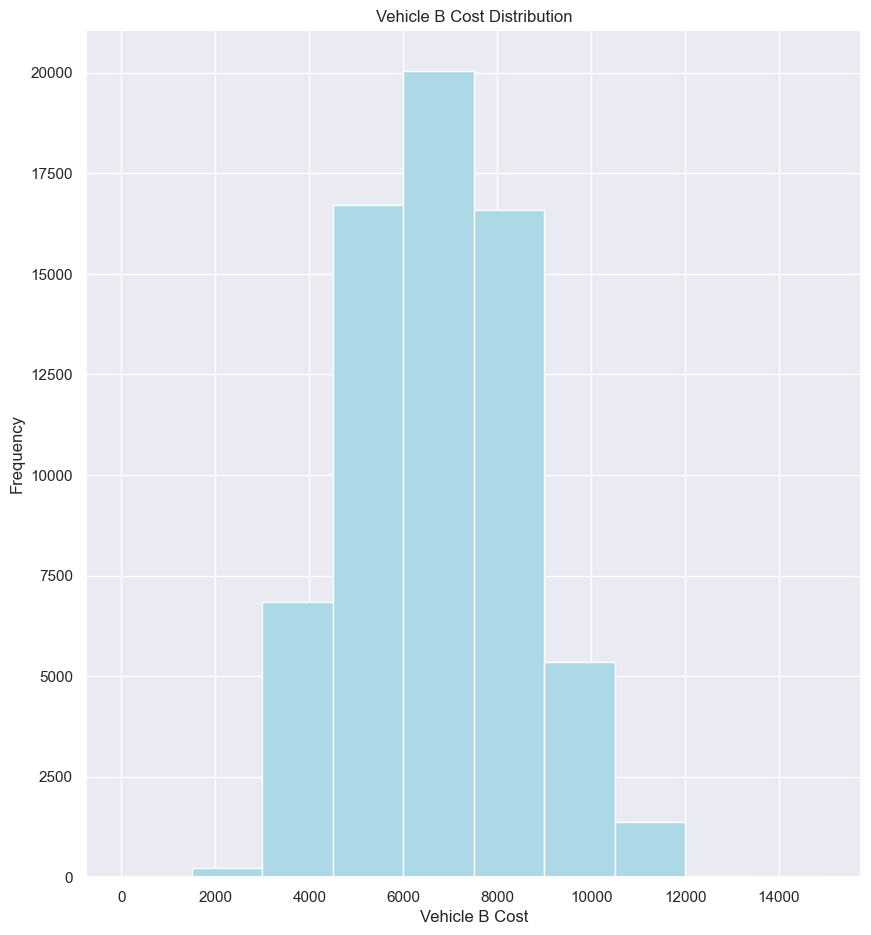

In [42]:
# 28. Vehicle Buying Price
ds['VehBCost'].plot.hist(bins = 10, color="lightblue", range=(0, 15000))
plt.title('Vehicle B Cost Distribution')
plt.xlabel('Vehicle B Cost')

Buying price of vehicles generally center around 7000

Text(0.5, 0, 'Warranty Cost')

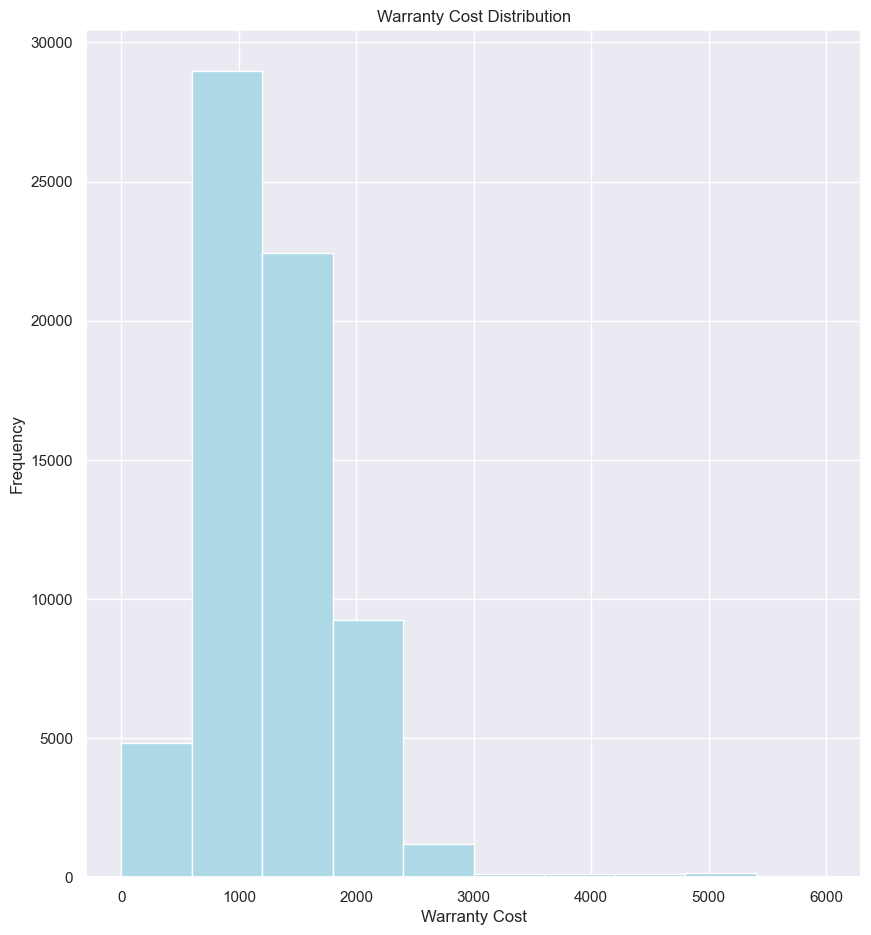

In [43]:
# 29. Warranty Cost
ds['WarrantyCost'].plot.hist(bins = 10, color="lightblue", range=(0, 6000))
plt.title('Warranty Cost Distribution')
plt.xlabel('Warranty Cost')


The cost of warranty is right skewed, with most common cost price between 1000 - 2000, about 20% of the vehicle buying price.

## Relationship of Attributes with Class

### Categorical Data


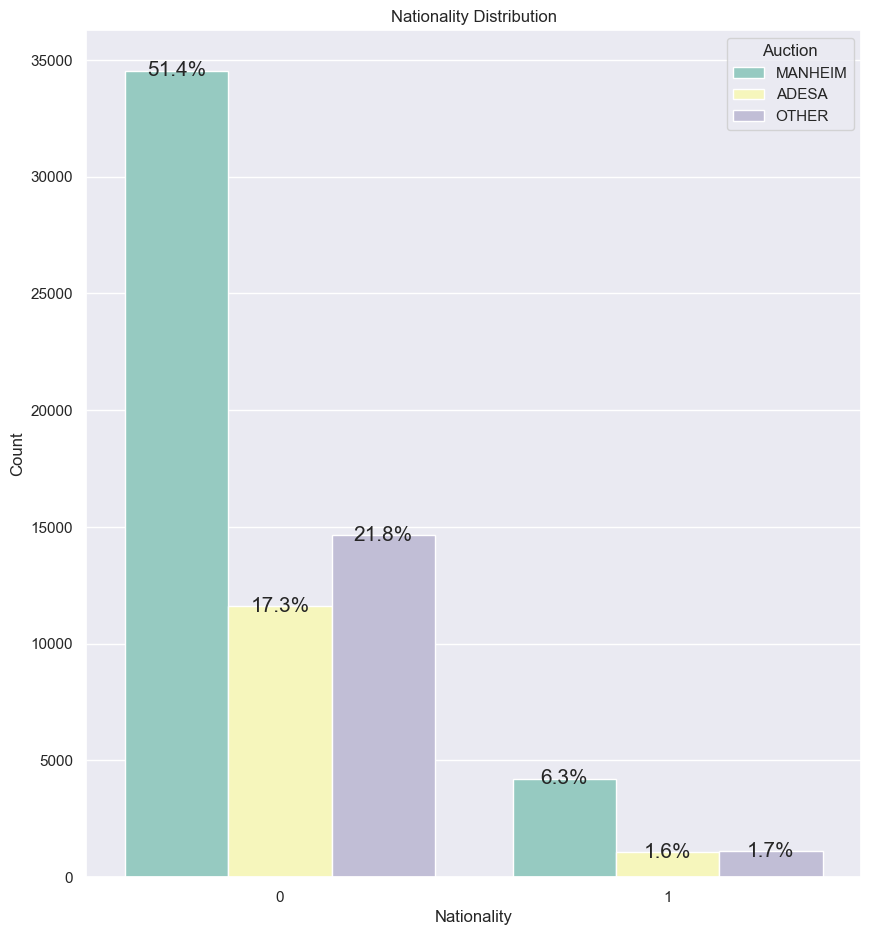

In [44]:
# create plot of auction location vs class
#sns.countplot(x = 'Class', data =  ds, hue = 'Auction')
# create the countplot
ax = sns.countplot(x='Class', data=ds, hue="Auction", palette=sns.color_palette("Set3"))

# Set x-tick labels rotation angle
#ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

# get the total number of observations
total = float(len(ds))

# loop through each bar
for p in ax.patches:
    # get the height and width of the bar
    height = p.get_height()
    width = p.get_width()
    # calculate the percentage value and format it
    percentage = '{:.1f}%'.format((height/total)*100)
    # add the percentage text on the bar
    ax.annotate(percentage, xy=(p.get_x()+width/2, height), ha='center', va='center', fontsize=15)
    
# set the title and axis labels
ax.set_title('Nationality Distribution', fontsize=12)
ax.set_xlabel('Nationality', fontsize=12)
ax.set_ylabel('Count', fontsize=12)

# show the plot
plt.show()

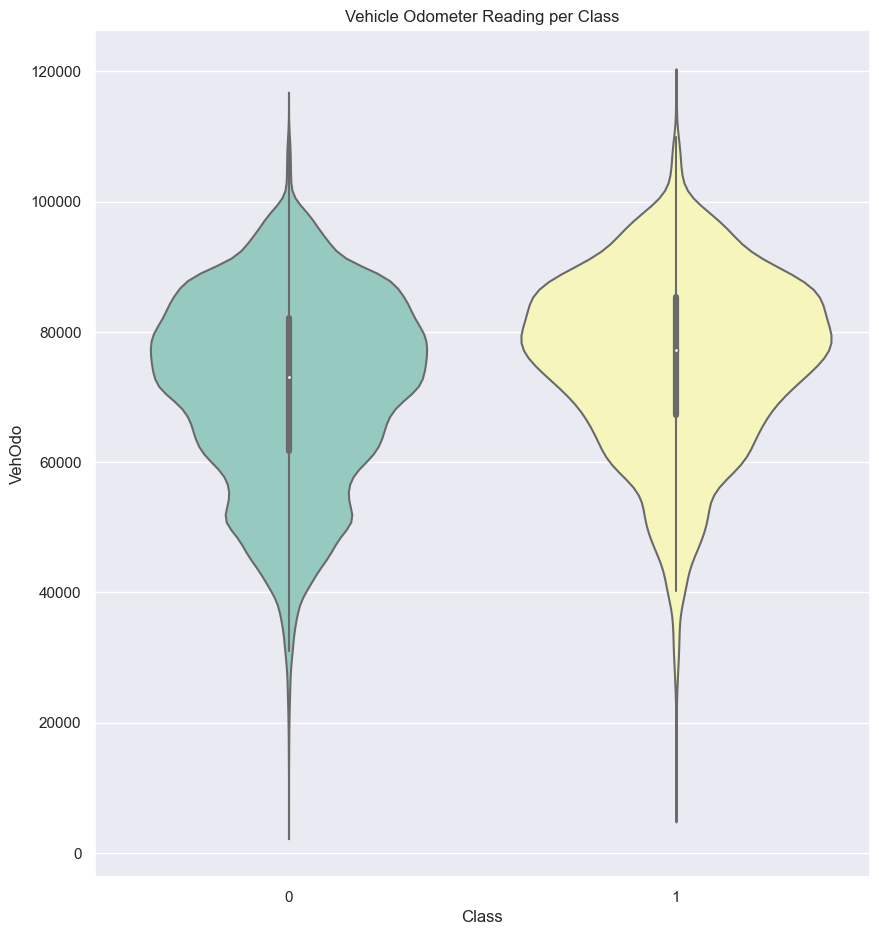

In [45]:
# create 
# add data points to the box plot by using Seaborn(sns)'s stripplot
ax = sns.violinplot(x = "Class", y = "VehOdo", data = ds, palette="Set3")
plt.title("Vehicle Odometer Reading per Class")
##ax = sns.stripplot(x = "Class", y = "VehOdo", data = ds, \
#                  jitter = True, edgecolor = "gray")
plt.show()

From the violin plot above, we see that kicked cars have a higher ODO. This means that cars that were less used are considered to be good buys. 


Text(0.5, 1.0, 'Relationship between Vehicle Odo VS Car Age')

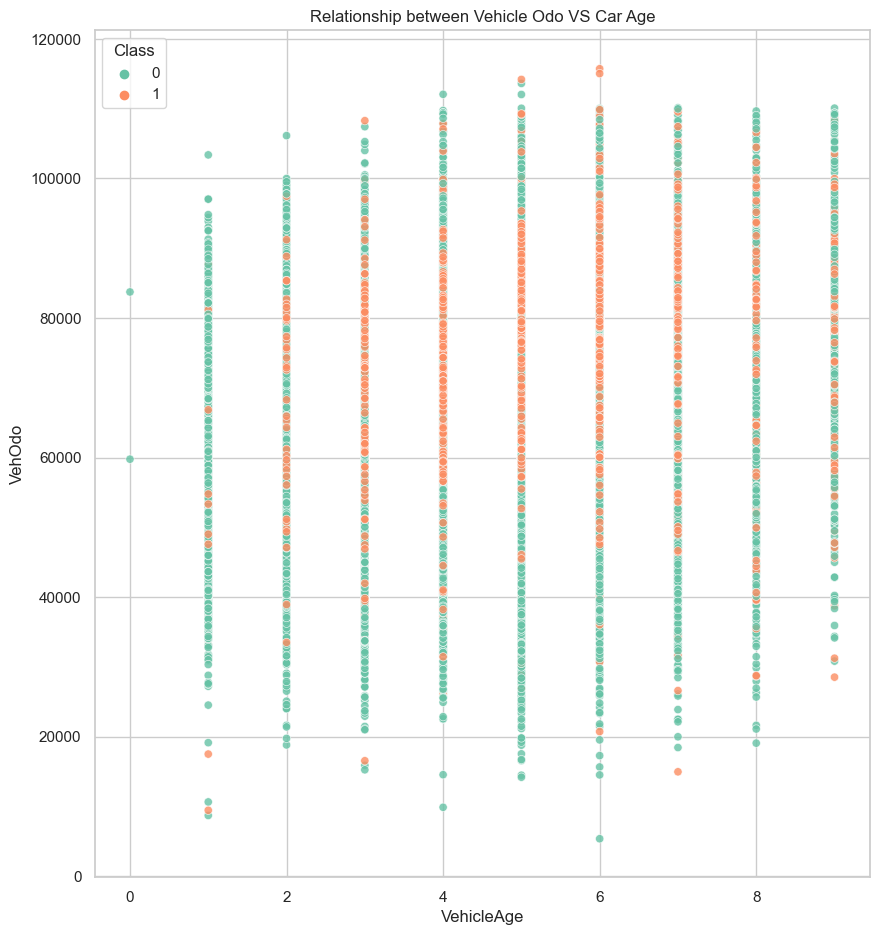

In [46]:
# relationship between ODO and Car Age
#sns.FacetGrid(ds, hue = "Class", height = 8 ).map(plt.scatter, "VehicleAge", "VehOdo").add_legend()
#plt.show()

sns.set(style='whitegrid')
 
sns.scatterplot(x="VehicleAge",
                    y="VehOdo",
                    hue="Class",
                    alpha=0.8,
                    palette='Set2',
                    data=ds)
plt.title("Relationship between Vehicle Odo VS Car Age")

Generally, vehicles with higher ODOs are kicked, despite the vehicle age.
Prior hypothesis was that larger vehicle ages of lower ODO would be kicked as it would be suspected that car odometer was tempered with. Hypothesis is rejected.

In [47]:
cross_tab = pd.crosstab(index=ds['Size'],
                        columns=ds['Class'])

cross_tab

Class              0     1
Size                      
'LARGE SUV'     1166   176
'LARGE TRUCK'   2758   286
'MEDIUM SUV'    6318   831
'SMALL SUV'     1929   233
'SMALL TRUCK'    721   101
COMPACT         5720   826
CROSSOVER       1333   100
LARGE           7848   596
MEDIUM         25872  2503
SPECIALTY       1637   110
SPORTS           619   106
VAN             4874   548

In [48]:
cross_tab_prop = pd.crosstab(index=ds['Size'],
                             columns=ds['Class'],
                             normalize="index")

cross_tab_prop

Class                 0         1
Size                             
'LARGE SUV'    0.868852  0.131148
'LARGE TRUCK'  0.906045  0.093955
'MEDIUM SUV'   0.883760  0.116240
'SMALL SUV'    0.892229  0.107771
'SMALL TRUCK'  0.877129  0.122871
COMPACT        0.873816  0.126184
CROSSOVER      0.930216  0.069784
LARGE          0.929417  0.070583
MEDIUM         0.911789  0.088211
SPECIALTY      0.937035  0.062965
SPORTS         0.853793  0.146207
VAN            0.898930  0.101070

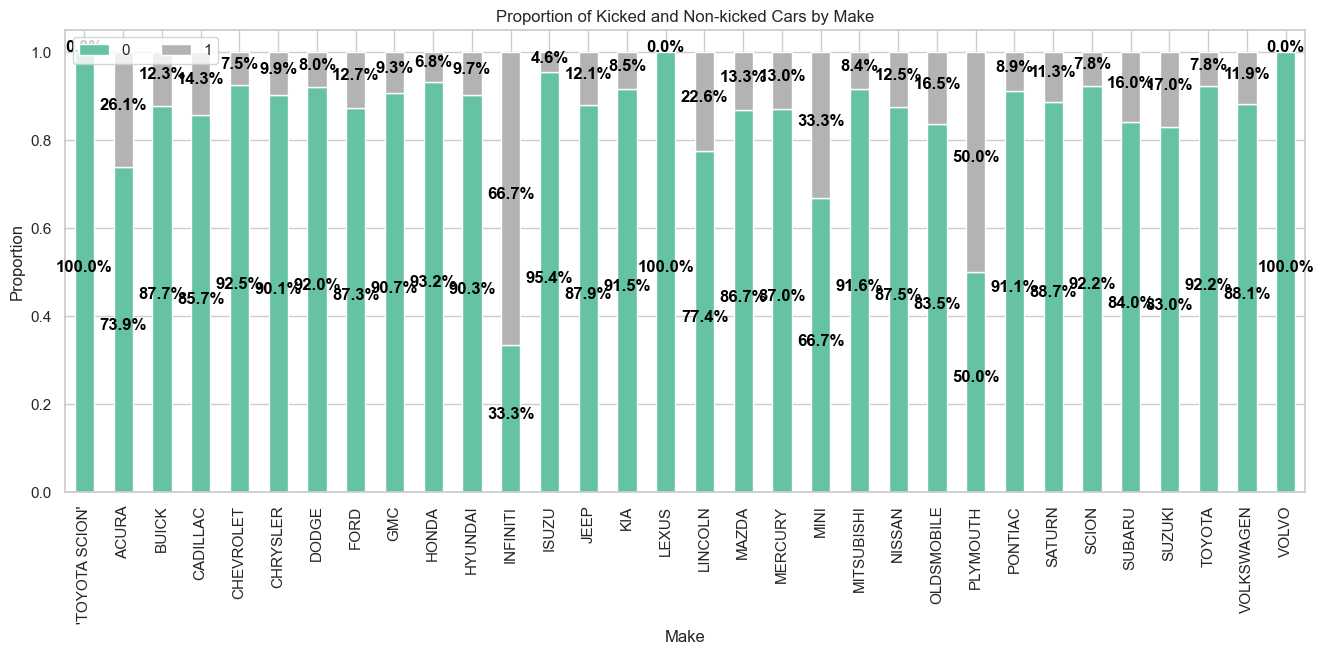

In [49]:
# compare Make vs Class Proportion

cross_tab = pd.crosstab(index=ds['Make'],
                        columns=ds['Class'])

cross_tab_prop = pd.crosstab(index=ds['Make'],
                             columns=ds['Class'],
                             normalize="index")

cross_tab_prop.plot(kind='bar', 
                    stacked=True, 
                    colormap='Set2', 
                    figsize=(16, 6))

plt.legend(loc="upper left", ncol=2)
plt.xlabel("Make")
plt.ylabel("Proportion")
plt.title("Proportion of Kicked and Non-kicked Cars by Make")


for i, (index, row) in enumerate(cross_tab_prop.iterrows()):
    x_pos = plt.gca().get_xticks()[i]
    for j, proportion in enumerate(row):
        plt.text(x=x_pos,
                 y=sum(row[:j+1]) - proportion/2,
                 s=f'{np.round(proportion * 100, 1)}%', 
                 color="black",
                 ha='center',
                 fontsize=12,
                 fontweight="bold")

plt.show()

From the above graph, we see that  66.7% of cars manufactured by INFINITI are kicked. The second highest kicked car manufacturer is POLYMOUTH, with 50% of kicked cars.    
Conversely, cars manufactured by TOYOTA SCION, LEXUS and VOLVO are 100% non-kicked, indicating that cars of these brands are preferred.

In [50]:
# descriptive statistics of numerical data
ds_x.describe()

PurchDate       VehYear    VehicleAge         VehOdo  \
count  6.721100e+04  67211.000000  67211.000000   67211.000000   
mean   1.263166e+09   2005.352606      4.168588   71734.558971   
std    1.820779e+07      1.727873      1.707501   14387.245482   
min    1.231114e+09   2001.000000      0.000000    5368.000000   
25%    1.247789e+09   2004.000000      3.000000   62163.000000   
50%    1.264032e+09   2005.000000      4.000000   73530.000000   
75%    1.279152e+09   2007.000000      5.000000   82530.000000   
max    1.293667e+09   2010.000000      9.000000  115717.000000   

       MMRAcquisitionAuctionAveragePrice  MMRAcquisitionAuctionCleanPrice  \
count                       67211.000000                     67211.000000   
mean                         6162.054589                      7411.975123   
std                          2452.884994                      2714.884242   
min                             0.000000                         0.000000   
25%                          4311.000000                      5456.500000   
50%                          6163.000000                      7380.000000   
75%                          7806.000000                      9049.000000   
max                         35722.000000                     36859.000000   

       MMRAcquisitionRetailAveragePrice  MMRAcquisitonRetailCleanPrice  \
count                      67211.000000                   67211.000000   
mean                        8538.503787                    9895.922423   
std                         3154.090485                    3384.033541   
min                            0.000000                       0.000000   
25%                         6319.000000                    7525.500000   
50%                         8498.000000                    9868.000000   
75%                        10709.500000                   12153.500000   
max                        39080.000000                   40308.000000   

       MMRCurrentAuctionAveragePrice  MMRCurrentAuctionCleanPrice  \
count                   67211.000000                 67211.000000   
mean                     6166.708827                  7429.722307   
std                      2426.946652                  2678.289955   
min                         0.000000                     0.000000   
25%                      4311.000000                  5468.000000   
50%                      6130.000000                  7390.000000   
75%                      7776.000000                  9045.000000   
max                     35722.000000                 36859.000000   

       MMRCurrentRetailAveragePrice  MMRCurrentRetailCleanPrice      VehBCost  \
count                  67211.000000                67211.000000  67211.000000   
mean                    8817.942123                10189.606300   6754.219919   
std                     3086.591314                 3305.531489   1743.710847   
min                        0.000000                    0.000000   1400.000000   
25%                     6565.000000                 7822.000000   5470.000000   
50%                     8811.000000                10175.000000   6750.000000   
75%                    10972.000000                12370.000000   7910.000000   
max                    39080.000000                40308.000000  35900.000000   

       WarrantyCost   WheelTypeID         BYRNO        VNZIP1  IsOnlineSale  
count  67211.000000  67211.000000  67211.000000  67211.000000  67211.000000  
mean    1278.942301      1.493386  26442.985419  58272.452768      0.025055  
std      579.077788      0.521232  25937.611063  26117.388216      0.156295  
min      462.000000      1.000000    835.000000   2764.000000      0.000000  
25%      853.000000      1.000000  17212.000000  32124.000000      0.000000  
50%     1169.000000      1.000000  19662.000000  74135.000000      0.000000  
75%     1623.000000      2.000000  22808.000000  80022.000000      0.000000  
max     7498.000000      3.000000  99761.000000  99224.000000      1.000000

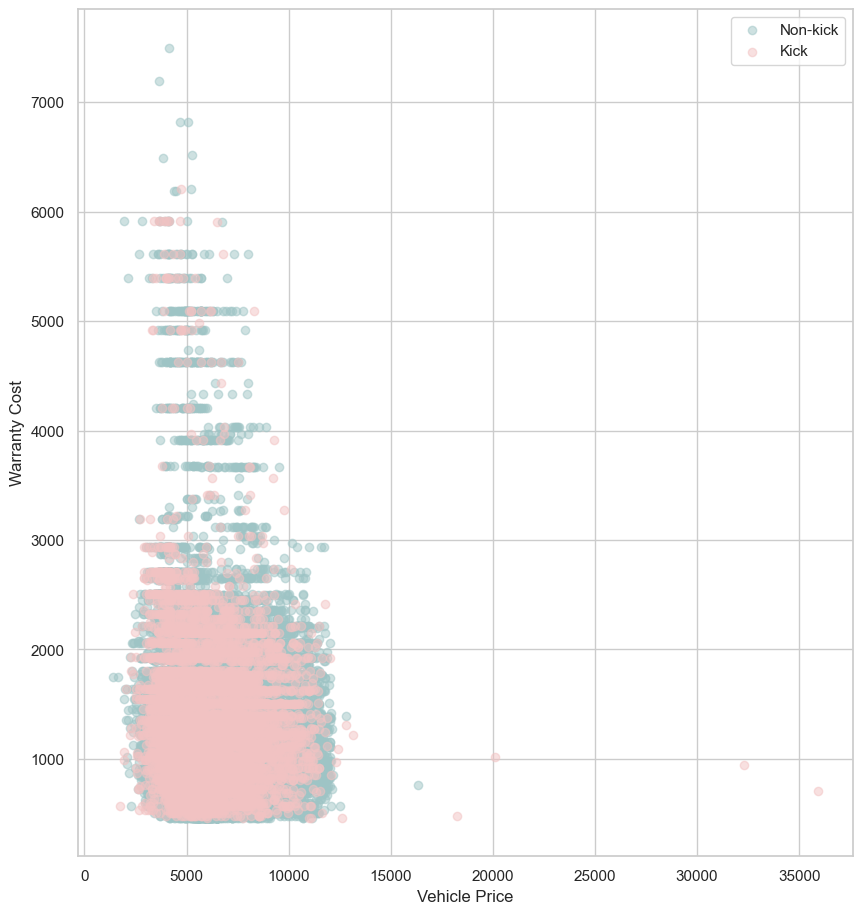

In [51]:
# scatter plot of numerical data
ds_0 = ds.drop(ds[ds['Class'] == 1].index)
ds_1 = ds.drop(ds[ds['Class'] == 0].index)

plt.scatter(x=ds_0['VehBCost'], y=ds_0['WarrantyCost'], color='#9EC4C5', label='Non-kick', alpha = 0.5)
plt.scatter(x=ds_1['VehBCost'], y=ds_1['WarrantyCost'], color='#F2C2C2', label='Kick', alpha = 0.5)

plt.xlabel('Vehicle Price')
plt.ylabel('Warranty Cost')
plt.legend()

plt.show()

In [52]:
# check missing values
missing_values = ds.isnull().sum()
print("No of missing values: ", missing_values.sum())

No of missing values:  0


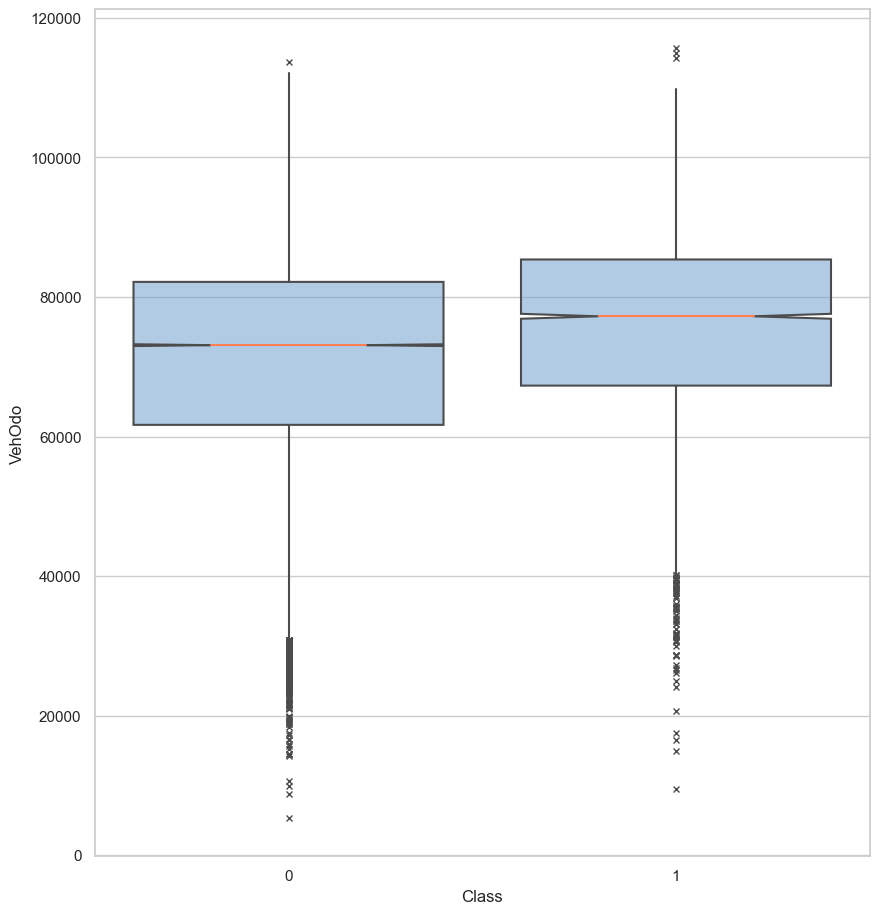

In [53]:
# check for numerical outliers

ax = sns.boxplot(data=ds, x="Class", y="VehOdo",
    notch=True, showcaps=False,
    flierprops={"marker": "x"},
    boxprops={"facecolor": (.4, .6, .8, .5)},
    medianprops={"color": "coral"},)

plt.show()

In [54]:
def find_outliers_IQR(ds):

   q1=ds.quantile(0.25)
   q3=ds.quantile(0.75)
   IQR=q3-q1
   outliers = ds[((ds<(q1-1.5*IQR)) | (ds>(q3+1.5*IQR)))]
   return outliers

In [55]:
# find outliers for 'VehOdo' column
outliers = find_outliers_IQR(ds['VehOdo'])
print(outliers)

39        28367.0
205       26975.0
224       26300.0
239       25195.0
262       30868.0
           ...   
66136     31457.0
66263     25530.0
66560     23853.0
66623     31449.0
66957    115026.0
Name: VehOdo, Length: 282, dtype: float64


In [56]:
# calculate the median of the 'VehOdo' column exclluding the outlier dataset
temp = ds[~ds['VehOdo'].isin(outliers)]
VehOdo_cmedian = temp['VehOdo'].median()

In [57]:
VehOdo_cmedian

73614.0

In [58]:
# create a copy of the dataset to adjust outliers values
ds_cleaned = pd.read_csv("car_kick.csv")

In [59]:
# replace outlier values with median value
ds_cleaned['VehOdo'][outliers.index] = VehOdo_cmedian


C:\Users\hojk8\AppData\Local\Temp\ipykernel_10896\3809675560.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ds_cleaned['VehOdo'][outliers.index] = VehOdo_cmedian


In [60]:
ds.iloc[66957]

PurchDate                             1292284800.0
VehYear                                     2004.0
VehicleAge                                       6
VehOdo                                    115026.0
MMRAcquisitionAuctionAveragePrice           3083.0
MMRAcquisitionAuctionCleanPrice             4860.0
MMRAcquisitionRetailAveragePrice            5958.0
MMRAcquisitonRetailCleanPrice               8133.0
MMRCurrentAuctionAveragePrice               3496.0
MMRCurrentAuctionCleanPrice                 4720.0
MMRCurrentRetailAveragePrice                6837.0
MMRCurrentRetailCleanPrice                  7961.0
VehBCost                                    4210.0
WarrantyCost                                1216.0
Auction                                    MANHEIM
Make                                          FORD
Model                                       TAURUS
Trim                                            LX
SubModel                             '4D SEDAN LX'
Color                          

In [61]:
ds_cleaned.iloc[66957]

PurchDate                             1292284800.0
VehYear                                     2004.0
VehicleAge                                       6
VehOdo                                     73614.0
MMRAcquisitionAuctionAveragePrice           3083.0
MMRAcquisitionAuctionCleanPrice             4860.0
MMRAcquisitionRetailAveragePrice            5958.0
MMRAcquisitonRetailCleanPrice               8133.0
MMRCurrentAuctionAveragePrice               3496.0
MMRCurrentAuctionCleanPrice                 4720.0
MMRCurrentRetailAveragePrice                6837.0
MMRCurrentRetailCleanPrice                  7961.0
VehBCost                                    4210.0
WarrantyCost                                1216.0
Auction                                    MANHEIM
Make                                          FORD
Model                                       TAURUS
Trim                                            LX
SubModel                             '4D SEDAN LX'
Color                          

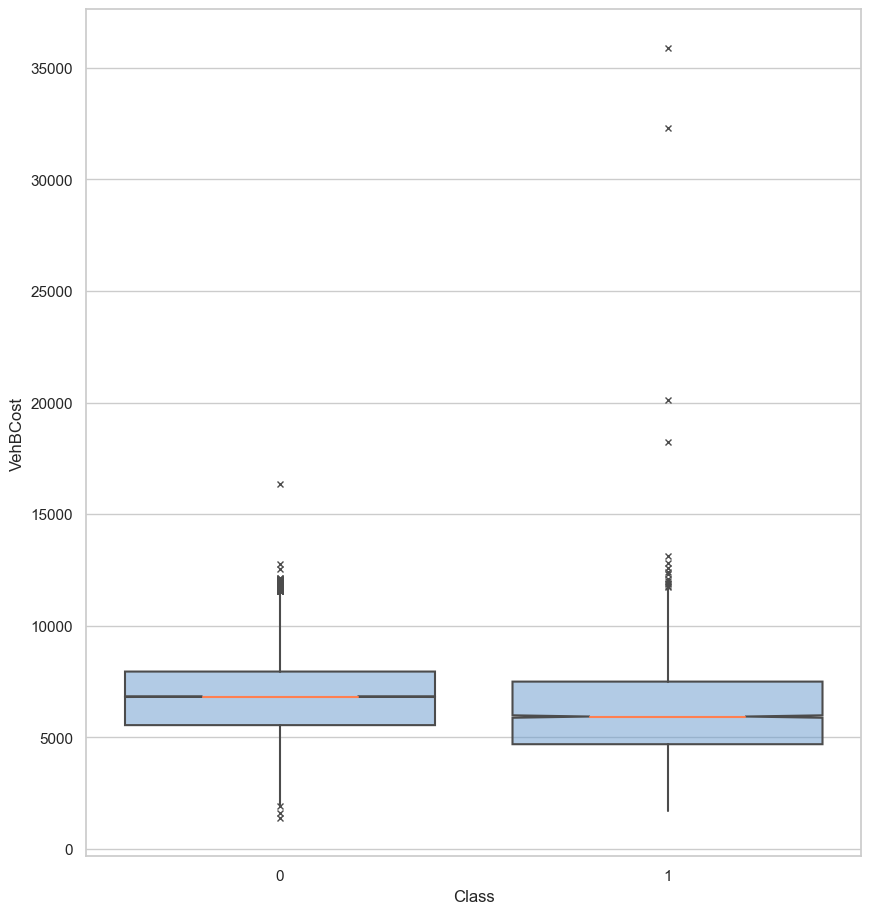

In [62]:
# check for VehBCost outliers

ax = sns.boxplot(data=ds, x="Class", y="VehBCost",
    notch=True, showcaps=False,
    flierprops={"marker": "x"},
    boxprops={"facecolor": (.4, .6, .8, .5)},
    medianprops={"color": "coral"},)

plt.show()

In [63]:
VBC_outliers = find_outliers_IQR(ds['VehBCost'])

In [64]:
temp = ds[~ds['VehBCost'].isin(VBC_outliers)]
VehBCost_cmedian = temp['VehBCost'].median()

In [65]:
ds_cleaned['VehBCost'][VBC_outliers.index] = VehBCost_cmedian

C:\Users\hojk8\AppData\Local\Temp\ipykernel_10896\3378918243.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ds_cleaned['VehBCost'][VBC_outliers.index] = VehBCost_cmedian


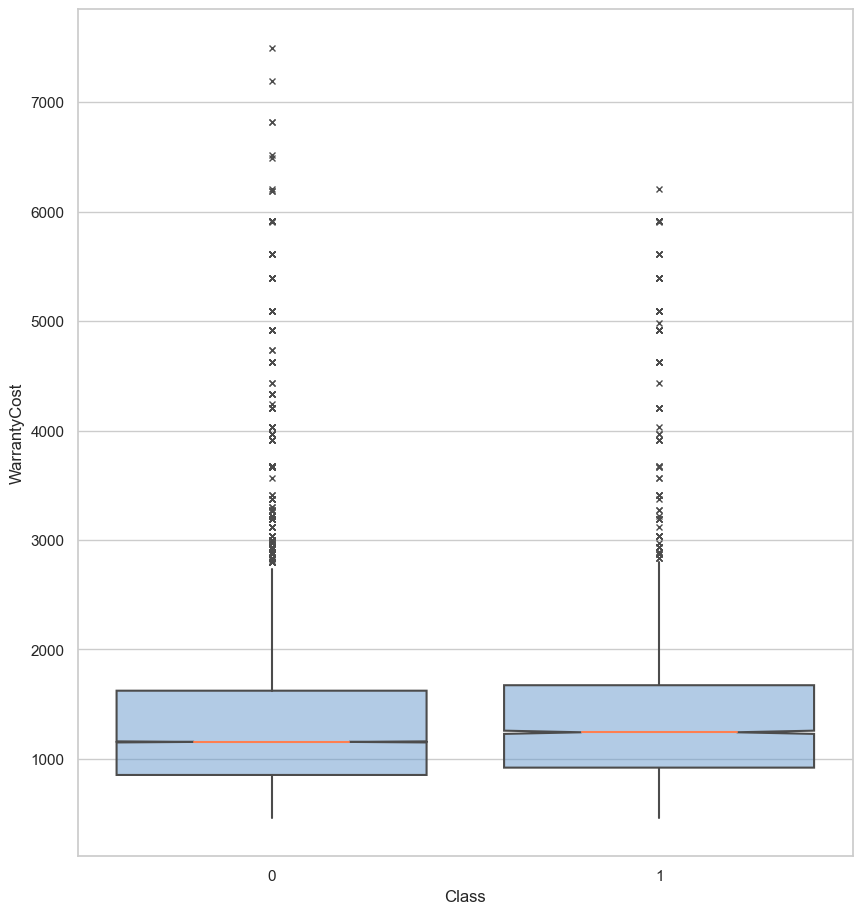

125      2939.0
195      3222.0
241      4622.0
398      3676.0
424      5092.0
          ...  
66865    2939.0
67034    5392.0
67126    3115.0
67134    2939.0
67209    3967.0
Name: WarrantyCost, Length: 696, dtype: float64

In [66]:
# check for WarrantyCost outliers

ax = sns.boxplot(data=ds, x="Class", y="WarrantyCost",
    notch=True, showcaps=False,
    flierprops={"marker": "x"},
    boxprops={"facecolor": (.4, .6, .8, .5)},
    medianprops={"color": "coral"},)

plt.show()

find_outliers_IQR(ds['WarrantyCost'])

In [67]:
WC_outliers = find_outliers_IQR(ds['WarrantyCost'])

In [68]:
temp = ds[~ds['WarrantyCost'].isin(WC_outliers)]
Warranty_cmedian = temp['WarrantyCost'].median()

In [69]:
ds_cleaned['WarrantyCost'][WC_outliers.index] = Warranty_cmedian

C:\Users\hojk8\AppData\Local\Temp\ipykernel_10896\2088345448.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ds_cleaned['WarrantyCost'][WC_outliers.index] = Warranty_cmedian


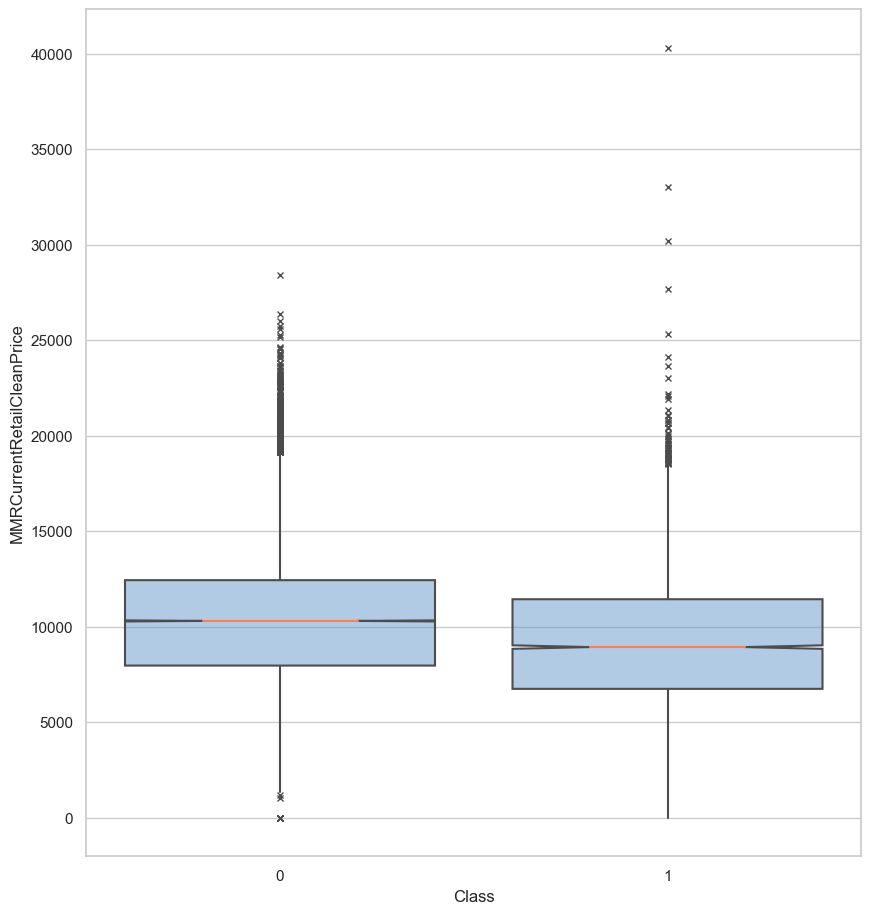

27       19360.0
88           0.0
171      20374.0
217          0.0
251          0.0
          ...   
66981    19746.0
67019    21047.0
67082    22053.0
67113        0.0
67199        0.0
Name: MMRCurrentRetailCleanPrice, Length: 829, dtype: float64

In [70]:
# check for MMRCurrentRetailCleanPrice outliers

ax = sns.boxplot(data=ds, x="Class", y="MMRCurrentRetailCleanPrice",
    notch=True, showcaps=False,
    flierprops={"marker": "x"},
    boxprops={"facecolor": (.4, .6, .8, .5)},
    medianprops={"color": "coral"},)

plt.show()

find_outliers_IQR(ds['MMRCurrentRetailCleanPrice'])


In [71]:
CurrentRetailCP_outliers = find_outliers_IQR(ds['MMRCurrentRetailCleanPrice'])

In [72]:
temp = ds[~ds['MMRCurrentRetailCleanPrice'].isin(CurrentRetailCP_outliers)]
CurrentRetailCP_cmedian = temp['MMRCurrentRetailCleanPrice'].median()

In [73]:
ds_cleaned['MMRCurrentRetailCleanPrice'][CurrentRetailCP_outliers.index] = CurrentRetailCP_cmedian

C:\Users\hojk8\AppData\Local\Temp\ipykernel_10896\1221104262.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ds_cleaned['MMRCurrentRetailCleanPrice'][CurrentRetailCP_outliers.index] = CurrentRetailCP_cmedian


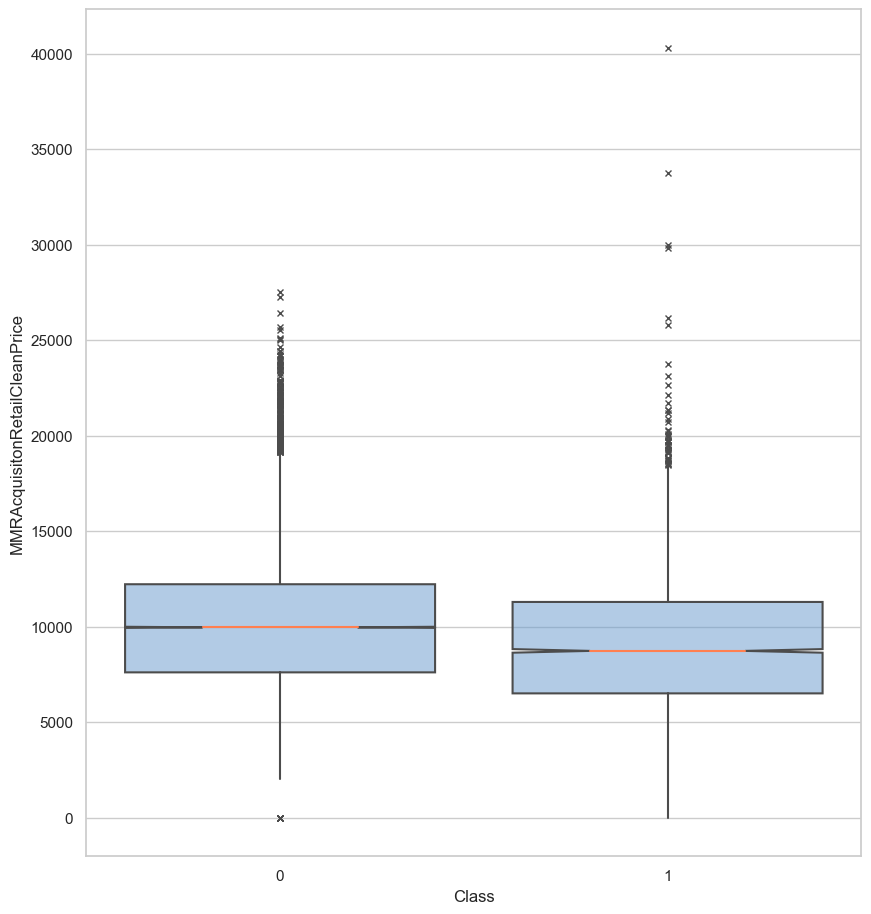

In [74]:
# check for MMRAcquisitonRetailCleanPrice outliers

ax = sns.boxplot(data=ds, x="Class", y="MMRAcquisitonRetailCleanPrice",
    notch=True, showcaps=False,
    flierprops={"marker": "x"},
    boxprops={"facecolor": (.4, .6, .8, .5)},
    medianprops={"color": "coral"},)

plt.show()

In [75]:
AcquisitionRetailCP_outliers = find_outliers_IQR(ds['MMRAcquisitonRetailCleanPrice'])

In [76]:
temp = ds[~ds['MMRAcquisitonRetailCleanPrice'].isin(AcquisitionRetailCP_outliers)]
AcquisitionRetailCP_cmedian = temp['MMRAcquisitonRetailCleanPrice'].median()

In [77]:
ds_cleaned['MMRAcquisitonRetailCleanPrice'][AcquisitionRetailCP_outliers.index] = AcquisitionRetailCP_cmedian

C:\Users\hojk8\AppData\Local\Temp\ipykernel_10896\3242775199.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ds_cleaned['MMRAcquisitonRetailCleanPrice'][AcquisitionRetailCP_outliers.index] = AcquisitionRetailCP_cmedian


In [78]:
ds_cleaned.describe()

PurchDate       VehYear    VehicleAge         VehOdo  \
count  6.721100e+04  67211.000000  67211.000000   67211.000000   
mean   1.263166e+09   2005.352606      4.168588   71926.631950   
std    1.820779e+07      1.727873      1.707501   14083.114571   
min    1.231114e+09   2001.000000      0.000000   31619.000000   
25%    1.247789e+09   2004.000000      3.000000   62376.000000   
50%    1.264032e+09   2005.000000      4.000000   73614.000000   
75%    1.279152e+09   2007.000000      5.000000   82528.000000   
max    1.293667e+09   2010.000000      9.000000  112056.000000   

       MMRAcquisitionAuctionAveragePrice  MMRAcquisitionAuctionCleanPrice  \
count                       67211.000000                     67211.000000   
mean                         6162.054589                      7411.975123   
std                          2452.884994                      2714.884242   
min                             0.000000                         0.000000   
25%                          4311.000000                      5456.500000   
50%                          6163.000000                      7380.000000   
75%                          7806.000000                      9049.000000   
max                         35722.000000                     36859.000000   

       MMRAcquisitionRetailAveragePrice  MMRAcquisitonRetailCleanPrice  \
count                      67211.000000                   67211.000000   
mean                        8538.503787                    9951.242535   
std                         3154.090485                    3108.378095   
min                            0.000000                    2009.000000   
25%                         6319.000000                    7611.000000   
50%                         8498.000000                    9896.000000   
75%                        10709.500000                   12101.000000   
max                        39080.000000                   19095.000000   

       MMRCurrentAuctionAveragePrice  MMRCurrentAuctionCleanPrice  \
count                   67211.000000                 67211.000000   
mean                     6166.708827                  7429.722307   
std                      2426.946652                  2678.289955   
min                         0.000000                     0.000000   
25%                      4311.000000                  5468.000000   
50%                      6130.000000                  7390.000000   
75%                      7776.000000                  9045.000000   
max                     35722.000000                 36859.000000   

       MMRCurrentRetailAveragePrice  MMRCurrentRetailCleanPrice      VehBCost  \
count                  67211.000000                67211.000000  67211.000000   
mean                    8817.942123                10204.320840   6740.907932   
std                     3086.591314                 3093.382672   1717.191963   
min                        0.000000                 1034.000000   1915.000000   
25%                     6565.000000                 7888.500000   5470.000000   
50%                     8811.000000                10184.000000   6740.000000   
75%                    10972.000000                12316.000000   7900.000000   
max                    39080.000000                19190.000000  11570.000000   

       WarrantyCost   WheelTypeID         BYRNO        VNZIP1  IsOnlineSale  \
count  67211.000000  67211.000000  67211.000000  67211.000000  67211.000000   
mean    1248.240169      1.493386  26442.985419  58272.452768      0.025055   
std      491.130681      0.521232  25937.611063  26117.388216      0.156295   
min      462.000000      1.000000    835.000000   2764.000000      0.000000   
25%      853.000000      1.000000  17212.000000  32124.000000      0.000000   
50%     1155.000000      1.000000  19662.000000  74135.000000      0.000000   
75%     1551.000000      2.000000  22808.000000  80022.000000      0.000000   
max     2735.000000      3.000000  99761.000000  99224.000000      1.0

In [79]:
# comparing with original dataset
ds.describe()

PurchDate       VehYear    VehicleAge         VehOdo  \
count  6.721100e+04  67211.000000  67211.000000   67211.000000   
mean   1.263166e+09   2005.352606      4.168588   71734.558971   
std    1.820779e+07      1.727873      1.707501   14387.245482   
min    1.231114e+09   2001.000000      0.000000    5368.000000   
25%    1.247789e+09   2004.000000      3.000000   62163.000000   
50%    1.264032e+09   2005.000000      4.000000   73530.000000   
75%    1.279152e+09   2007.000000      5.000000   82530.000000   
max    1.293667e+09   2010.000000      9.000000  115717.000000   

       MMRAcquisitionAuctionAveragePrice  MMRAcquisitionAuctionCleanPrice  \
count                       67211.000000                     67211.000000   
mean                         6162.054589                      7411.975123   
std                          2452.884994                      2714.884242   
min                             0.000000                         0.000000   
25%                          4311.000000                      5456.500000   
50%                          6163.000000                      7380.000000   
75%                          7806.000000                      9049.000000   
max                         35722.000000                     36859.000000   

       MMRAcquisitionRetailAveragePrice  MMRAcquisitonRetailCleanPrice  \
count                      67211.000000                   67211.000000   
mean                        8538.503787                    9895.922423   
std                         3154.090485                    3384.033541   
min                            0.000000                       0.000000   
25%                         6319.000000                    7525.500000   
50%                         8498.000000                    9868.000000   
75%                        10709.500000                   12153.500000   
max                        39080.000000                   40308.000000   

       MMRCurrentAuctionAveragePrice  MMRCurrentAuctionCleanPrice  \
count                   67211.000000                 67211.000000   
mean                     6166.708827                  7429.722307   
std                      2426.946652                  2678.289955   
min                         0.000000                     0.000000   
25%                      4311.000000                  5468.000000   
50%                      6130.000000                  7390.000000   
75%                      7776.000000                  9045.000000   
max                     35722.000000                 36859.000000   

       MMRCurrentRetailAveragePrice  MMRCurrentRetailCleanPrice      VehBCost  \
count                  67211.000000                67211.000000  67211.000000   
mean                    8817.942123                10189.606300   6754.219919   
std                     3086.591314                 3305.531489   1743.710847   
min                        0.000000                    0.000000   1400.000000   
25%                     6565.000000                 7822.000000   5470.000000   
50%                     8811.000000                10175.000000   6750.000000   
75%                    10972.000000                12370.000000   7910.000000   
max                    39080.000000                40308.000000  35900.000000   

       WarrantyCost   WheelTypeID         BYRNO        VNZIP1  IsOnlineSale  \
count  67211.000000  67211.000000  67211.000000  67211.000000  67211.000000   
mean    1278.942301      1.493386  26442.985419  58272.452768      0.025055   
std      579.077788      0.521232  25937.611063  26117.388216      0.156295   
min      462.000000      1.000000    835.000000   2764.000000      0.000000   
25%      853.000000      1.000000  17212.000000  32124.000000      0.000000   
50%     1169.000000      1.000000  19662.000000  74135.000000      0.000000   
75%     1623.000000      2.000000  22808.000000  80022.000000      0.000000   
max     7498.000000      3.000000  99761.000000  99224.000000      1.0

---

# compare Model vs Class Proportion

model_tab = pd.crosstab(index=ds['-'],
                        columns=ds['Class'])

model_tab_prop = pd.crosstab(index=ds['-'],
                             columns=ds['Class'],
                             normalize="index")

model_tab_prop.plot(kind='bar', 
                    stacked=True, 
                    colormap='Set2', 
                    figsize=(16, 6))

plt.legend(loc="upper left", ncol=2)
plt.xlabel("Model")
plt.ylabel("Proportion")
plt.title("Proportion of Kicked and Non-kicked Cars by Make")


for i, (index, row) in enumerate(model_tab_prop.iterrows()):
    x_pos = plt.gca().get_xticks()[i]
    for j, proportion in enumerate(row):
        plt.text(x=x_pos,
                 y=sum(row[:j+1]) - proportion/2,
                 s=f'{np.round(proportion * 100, 1)}%', 
                 color="black",
                 ha='center',
                 fontsize=12,
                 fontweight="bold")

plt.show()

In [80]:
ds.describe()

PurchDate       VehYear    VehicleAge         VehOdo  \
count  6.721100e+04  67211.000000  67211.000000   67211.000000   
mean   1.263166e+09   2005.352606      4.168588   71734.558971   
std    1.820779e+07      1.727873      1.707501   14387.245482   
min    1.231114e+09   2001.000000      0.000000    5368.000000   
25%    1.247789e+09   2004.000000      3.000000   62163.000000   
50%    1.264032e+09   2005.000000      4.000000   73530.000000   
75%    1.279152e+09   2007.000000      5.000000   82530.000000   
max    1.293667e+09   2010.000000      9.000000  115717.000000   

       MMRAcquisitionAuctionAveragePrice  MMRAcquisitionAuctionCleanPrice  \
count                       67211.000000                     67211.000000   
mean                         6162.054589                      7411.975123   
std                          2452.884994                      2714.884242   
min                             0.000000                         0.000000   
25%                          4311.000000                      5456.500000   
50%                          6163.000000                      7380.000000   
75%                          7806.000000                      9049.000000   
max                         35722.000000                     36859.000000   

       MMRAcquisitionRetailAveragePrice  MMRAcquisitonRetailCleanPrice  \
count                      67211.000000                   67211.000000   
mean                        8538.503787                    9895.922423   
std                         3154.090485                    3384.033541   
min                            0.000000                       0.000000   
25%                         6319.000000                    7525.500000   
50%                         8498.000000                    9868.000000   
75%                        10709.500000                   12153.500000   
max                        39080.000000                   40308.000000   

       MMRCurrentAuctionAveragePrice  MMRCurrentAuctionCleanPrice  \
count                   67211.000000                 67211.000000   
mean                     6166.708827                  7429.722307   
std                      2426.946652                  2678.289955   
min                         0.000000                     0.000000   
25%                      4311.000000                  5468.000000   
50%                      6130.000000                  7390.000000   
75%                      7776.000000                  9045.000000   
max                     35722.000000                 36859.000000   

       MMRCurrentRetailAveragePrice  MMRCurrentRetailCleanPrice      VehBCost  \
count                  67211.000000                67211.000000  67211.000000   
mean                    8817.942123                10189.606300   6754.219919   
std                     3086.591314                 3305.531489   1743.710847   
min                        0.000000                    0.000000   1400.000000   
25%                     6565.000000                 7822.000000   5470.000000   
50%                     8811.000000                10175.000000   6750.000000   
75%                    10972.000000                12370.000000   7910.000000   
max                    39080.000000                40308.000000  35900.000000   

       WarrantyCost   WheelTypeID         BYRNO        VNZIP1  IsOnlineSale  \
count  67211.000000  67211.000000  67211.000000  67211.000000  67211.000000   
mean    1278.942301      1.493386  26442.985419  58272.452768      0.025055   
std      579.077788      0.521232  25937.611063  26117.388216      0.156295   
min      462.000000      1.000000    835.000000   2764.000000      0.000000   
25%      853.000000      1.000000  17212.000000  32124.000000      0.000000   
50%     1169.000000      1.000000  19662.000000  74135.000000      0.000000   
75%     1623.000000      2.000000  22808.000000  80022.000000      0.000000   
max     7498.000000      3.000000  99761.000000  99224.000000      1.0

# Data Cleaning 

as mentioned above, 
- PurchDate has to be deleted since it is uninterpretable.
- VehYear have been provide a more direct way to observe the data, hence VehAge can be drop from the dataset
- after extract the information from the dataset, WheelType and WheelTypeID have the same information, so keep one is enough, WheelType has as more directly information compare to WheelTypeID hence, WheelTypeID drop from dataset. 
- There are inconsistencies between columns 'Make' and 'TopThreeAmericanName', which segregates rows into categories of Ford, Chrysler, GM or other car manufacturers. Eg:
Number of CHRYSLER's in 'TopThreeAmericanName' = 22074.
Number of CHRYSLER's in 'Make' = 8115.
Therefore, 'TopThreeAmericanName' should be dropped to prevent such inconsistencies.

In [81]:
noPretiveFunctionCol = ['PurchDate', 'VehicleAge', 'WheelTypeID', 'TopThreeAmericanName']
ds_drop_col = ds_cleaned.drop(noPretiveFunctionCol, axis=1)
ds_drop_col.head()

VehYear   VehOdo  MMRAcquisitionAuctionAveragePrice  \
0   2006.0  51954.0                             6197.0   
1   2005.0  89127.0                             3688.0   
2   2006.0  71271.0                             6897.0   
3   2008.0  83338.0                             7878.0   
4   2007.0  58698.0                             8800.0   

   MMRAcquisitionAuctionCleanPrice  MMRAcquisitionRetailAveragePrice  \
0                           7062.0                            9605.0   
1                           4783.0                            4483.0   
2                           8449.0                            7949.0   
3                           8925.0                           11723.0   
4                          10091.0                           10004.0   

   MMRAcquisitonRetailCleanPrice  MMRCurrentAuctionAveragePrice  \
0                        10426.0                         5341.0   
1                         5666.0                         3688.0   
2                         9625.0                         6868.0   
3                        13026.0                         7801.0   
4                        11398.0                         7355.0   

   MMRCurrentAuctionCleanPrice  MMRCurrentRetailAveragePrice  \
0                       6351.0                        8513.0   
1                       4783.0                        4483.0   
2                       8549.0                        7917.0   
3                       8704.0                       11995.0   
4                       8543.0                        8443.0   

   MMRCurrentRetailCleanPrice  ...   Color  Transmission WheelType  \
0                      9822.0  ...  SILVER          AUTO    Covers   
1                      5666.0  ...  SILVER          AUTO    Covers   
2                      9733.0  ...     RED          AUTO     Alloy   
3                     12901.0  ...   BLACK          AUTO    Covers   
4                      9726.0  ...   WHITE          AUTO     Alloy   

  Nationality    Size  BYRNO VNZIP1 VNST IsOnlineSale Class  
0    AMERICAN  MEDIUM  99750  32124   FL            0     0  
1    AMERICAN  MEDIUM  20833  78754   TX            0     0  
2    AMERICAN   LARGE  22916  80011   CO            0     0  
3    AMERICAN   LARGE  23657  94544   CA            0     0  
4    AMERICAN   LARGE  20833  77086   TX            0     0  

[5 rows x 27 columns]

### Categorical Data

- From column Transmission, Manual have to put into MANUAL
- For column Size - While there are no typing errors whereby more than one value points to the same value, in the data cleaning step, single quotations, ', can be removed for consistency and cleanliness of data.

In [82]:
#1. Raw Transmission 
ds_drop_col['Transmission'].value_counts()

AUTO      64871
MANUAL     2339
Manual        1
Name: Transmission, dtype: int64

In [83]:
# combine Manual and MANUAL in Transmission
ds_drop_col['Transmission'] = ds_drop_col["Transmission"].replace('Manual', 'MANUAL', regex=True)
# make sure it has been change 
ds_drop_col['Transmission'].value_counts()

AUTO      64871
MANUAL     2340
Name: Transmission, dtype: int64

In [84]:
#2. Raw Size
ds_drop_col['Size'].value_counts()

MEDIUM           28375
LARGE             8444
'MEDIUM SUV'      7149
COMPACT           6546
VAN               5422
'LARGE TRUCK'     3044
'SMALL SUV'       2162
SPECIALTY         1747
CROSSOVER         1433
'LARGE SUV'       1342
'SMALL TRUCK'      822
SPORTS             725
Name: Size, dtype: int64

In [85]:
# remove all single quote from Size
ds_drop_col['Size'] = ds_drop_col["Size"].str.strip(" \' ")
# make sure it has been changed
ds_drop_col['Size'].value_counts()

MEDIUM         28375
LARGE           8444
MEDIUM SUV      7149
COMPACT         6546
VAN             5422
LARGE TRUCK     3044
SMALL SUV       2162
SPECIALTY       1747
CROSSOVER       1433
LARGE SUV       1342
SMALL TRUCK      822
SPORTS           725
Name: Size, dtype: int64

In [86]:
# 3. Raw Model
ds_drop_col['Model'].value_counts()

'PT CRUISER'              2195
IMPALA                    1922
TAURUS                    1369
CALIBER                   1296
'CARAVAN GRAND FWD V6'    1233
                          ... 
'TORRENT FWD V6'             1
'350Z MFI V6 3.5L DOH'       1
'RODEO 2WD 4C MFI I-4'       1
'CONCORDE 3.2L V6 EFI'       1
'ENVOY XL 4WD V8 5.3L'       1
Name: Model, Length: 953, dtype: int64

In [87]:
# remove all single quote from Model
ds_drop_col['Model'] = ds_drop_col["Model"].str.strip(" \' ")
# make sure it has been changed
ds_drop_col['Model'].value_counts()

PT CRUISER              2195
IMPALA                  1922
TAURUS                  1369
CALIBER                 1296
CARAVAN GRAND FWD V6    1233
                        ... 
TORRENT FWD V6             1
350Z MFI V6 3.5L DOH       1
RODEO 2WD 4C MFI I-4       1
CONCORDE 3.2L V6 EFI       1
ENVOY XL 4WD V8 5.3L       1
Name: Model, Length: 953, dtype: int64

In [88]:
# 4. SubModel
ds_drop_col['SubModel'].value_counts()

'4D SEDAN'                    13363
'4D SEDAN LS'                  4541
'4D SEDAN SE'                  3648
'4D WAGON'                     1979
'MINIVAN 3.3L'                 1203
                              ...  
'5D SEDAN S GRAND TOURING'        1
'REG CAB 3.0L XLT'                1
'4D SUV 5.9L SLT PLUS'            1
'2D COUPE GX'                     1
'4D SEDAN LUXURY AWD'             1
Name: SubModel, Length: 823, dtype: int64

In [89]:
# remove all single quote from SubModel
ds_drop_col['SubModel'] = ds_drop_col["SubModel"].str.strip(" \' ")
# make sure it has been changed
ds_drop_col['SubModel'].value_counts()

4D SEDAN                    13363
4D SEDAN LS                  4541
4D SEDAN SE                  3648
4D WAGON                     1979
MINIVAN 3.3L                 1203
                            ...  
5D SEDAN S GRAND TOURING        1
REG CAB 3.0L XLT                1
4D SUV 5.9L SLT PLUS            1
2D COUPE GX                     1
4D SEDAN LUXURY AWD             1
Name: SubModel, Length: 823, dtype: int64

In [90]:
# 4. Raw Nationality
ds_drop_col['Nationality'].value_counts()

AMERICAN            57099
'OTHER ASIAN'        6407
'TOP LINE ASIAN'     3526
OTHER                 179
Name: Nationality, dtype: int64

In [91]:
# remove all single quote from Nationality
ds_drop_col['Nationality'] = ds_drop_col["Nationality"].str.strip(" \' ")
# make sure it has been changed
ds_drop_col['Nationality'].value_counts()

AMERICAN          57099
OTHER ASIAN        6407
TOP LINE ASIAN     3526
OTHER               179
Name: Nationality, dtype: int64

In [92]:
ds_clean_categorical = ds_drop_col
ds_clean_categorical

VehYear   VehOdo  MMRAcquisitionAuctionAveragePrice  \
0       2006.0  51954.0                             6197.0   
1       2005.0  89127.0                             3688.0   
2       2006.0  71271.0                             6897.0   
3       2008.0  83338.0                             7878.0   
4       2007.0  58698.0                             8800.0   
...        ...      ...                                ...   
67206   2008.0  56072.0                             6255.0   
67207   2004.0  94232.0                             8359.0   
67208   2004.0  79534.0                             2805.0   
67209   2003.0  79394.0                             4042.0   
67210   2004.0  94491.0                             5194.0   

       MMRAcquisitionAuctionCleanPrice  MMRAcquisitionRetailAveragePrice  \
0                               7062.0                            9605.0   
1                               4783.0                            4483.0   
2                               8449.0                            7949.0   
3                               8925.0                           11723.0   
4                              10091.0                           10004.0   
...                                ...                               ...   
67206                           6972.0                            9852.0   
67207                           9645.0                           12042.0   
67208                           3826.0                            6132.0   
67209                           5296.0                            7335.0   
67210                           6424.0                            8532.0   

       MMRAcquisitonRetailCleanPrice  MMRCurrentAuctionAveragePrice  \
0                            10426.0                         5341.0   
1                             5666.0                         3688.0   
2                             9625.0                         6868.0   
3                            13026.0                         7801.0   
4                            11398.0                         7355.0   
...                              ...                            ...   
67206                        10567.0                         6326.0   
67207                        13302.0                         7505.0   
67208                         6871.0                         3106.0   
67209                         8983.0                         3534.0   
67210                         9941.0                         4417.0   

       MMRCurrentAuctionCleanPrice  MMRCurrentRetailAveragePrice  \
0                           6351.0                        8513.0   
1                           4783.0                        4483.0   
2                           8549.0                        7917.0   
3                           8704.0                       11995.0   
4                           8543.0                        8443.0   
...                            ...                           ...   
67206                       7126.0                        9951.0   
67207                       8188.0                       10993.0   
67208                       4479.0                        5981.0   
67209                       4732.0                        7165.0   
67210                       5807.0                        7814.0   

       MMRCurrentRetailCleanPrice  ...   Color  Transmission WheelType  \
0                          9822.0  ...  SILVER          AUTO    Covers   
1                          5666.0  ...  SILVER          AUTO    Covers   
2                          9733.0  ...     RED          AUTO     Alloy   
3                         12901.0  ...   BLACK          AUTO    Covers   
4                          9726.0  ...   WHITE          AUTO     Alloy   
...                           ...  ...     ...           ...       ...   
67206                     10806.0  ...     RED          AUTO    Covers   
67207                     11655.0  ...   BLACK          AUTO     Alloy   
67208        

In [93]:
# save the file into python and observe is all the data being change 
#ds_clean_categorical.to_excel('C:/Users/hojk8/Downloads/IT training/Data Mining Assignment/ds_clean_categorical.xlsx', index=False)

### Numerical Data 

As mentioned,
- The cleaned prices are generally a positive shift of the average prices. The retail prices are also a positive shift of its correspondinig acquisaition or current prices.Suggestion: leave only the cleaned retail value of acquisition and current prices, and discard the rest. Then create a new attribute for the potential value of car, 'potential_value' = 'MMRCurrentRetailCleanPrice'- 'MMRAcquisitonRetailCleanPrice'.The size of this difference provides the relative potential value of the car purchased.

In [94]:
potential_value = ds_clean_categorical['MMRCurrentRetailCleanPrice']-ds_clean_categorical['MMRAcquisitonRetailCleanPrice']

In [95]:
ds_clean_categorical['Potential_Value'] = pd.DataFrame(list(potential_value))
ds_clean_categorical

VehYear   VehOdo  MMRAcquisitionAuctionAveragePrice  \
0       2006.0  51954.0                             6197.0   
1       2005.0  89127.0                             3688.0   
2       2006.0  71271.0                             6897.0   
3       2008.0  83338.0                             7878.0   
4       2007.0  58698.0                             8800.0   
...        ...      ...                                ...   
67206   2008.0  56072.0                             6255.0   
67207   2004.0  94232.0                             8359.0   
67208   2004.0  79534.0                             2805.0   
67209   2003.0  79394.0                             4042.0   
67210   2004.0  94491.0                             5194.0   

       MMRAcquisitionAuctionCleanPrice  MMRAcquisitionRetailAveragePrice  \
0                               7062.0                            9605.0   
1                               4783.0                            4483.0   
2                               8449.0                            7949.0   
3                               8925.0                           11723.0   
4                              10091.0                           10004.0   
...                                ...                               ...   
67206                           6972.0                            9852.0   
67207                           9645.0                           12042.0   
67208                           3826.0                            6132.0   
67209                           5296.0                            7335.0   
67210                           6424.0                            8532.0   

       MMRAcquisitonRetailCleanPrice  MMRCurrentAuctionAveragePrice  \
0                            10426.0                         5341.0   
1                             5666.0                         3688.0   
2                             9625.0                         6868.0   
3                            13026.0                         7801.0   
4                            11398.0                         7355.0   
...                              ...                            ...   
67206                        10567.0                         6326.0   
67207                        13302.0                         7505.0   
67208                         6871.0                         3106.0   
67209                         8983.0                         3534.0   
67210                         9941.0                         4417.0   

       MMRCurrentAuctionCleanPrice  MMRCurrentRetailAveragePrice  \
0                           6351.0                        8513.0   
1                           4783.0                        4483.0   
2                           8549.0                        7917.0   
3                           8704.0                       11995.0   
4                           8543.0                        8443.0   
...                            ...                           ...   
67206                       7126.0                        9951.0   
67207                       8188.0                       10993.0   
67208                       4479.0                        5981.0   
67209                       4732.0                        7165.0   
67210                       5807.0                        7814.0   

       MMRCurrentRetailCleanPrice  ...  Transmission  WheelType  \
0                          9822.0  ...          AUTO     Covers   
1                          5666.0  ...          AUTO     Covers   
2                          9733.0  ...          AUTO      Alloy   
3                         12901.0  ...          AUTO     Covers   
4                          9726.0  ...          AUTO      Alloy   
...                           ...  ...           ...        ...   
67206                     10806.0  ...          AUTO     Covers   
67207                     11655.0  ...          AUTO      Alloy   
67208                      7256.0  ...          AUTO      Alloy   
67209    

In [96]:
# drop those highly correlated numerical data
# BYRNO represents the car's registration number, which acts as an ID. 
# In data mining, it provides no useful information and should be dropped.
highlyCor = ['MMRAcquisitionAuctionAveragePrice', 'MMRAcquisitionAuctionCleanPrice', 'MMRAcquisitionRetailAveragePrice', 'MMRAcquisitonRetailCleanPrice', 'MMRCurrentAuctionAveragePrice', 'MMRCurrentAuctionCleanPrice' ,'MMRCurrentRetailAveragePrice', 'MMRCurrentRetailCleanPrice']
ds_drop_highCor = ds_clean_categorical.drop(highlyCor, axis=1)
ds_drop_highCor.head()

VehYear   VehOdo  VehBCost  WarrantyCost  Auction       Make  \
0   2006.0  51954.0    6500.0        1086.0  MANHEIM      DODGE   
1   2005.0  89127.0    3680.0         983.0    ADESA       FORD   
2   2006.0  71271.0    7170.0        1974.0  MANHEIM    PONTIAC   
3   2008.0  83338.0    7670.0        2152.0  MANHEIM  CHEVROLET   
4   2007.0  58698.0    7165.0        1500.0    ADESA  CHEVROLET   

                  Model Trim              SubModel   Color Transmission  \
0            STRATUS V6  SXT      4D SEDAN SXT FFV  SILVER         AUTO   
1    TAURUS 3.0L V6 EFI   SE           4D SEDAN SE  SILVER         AUTO   
2  GRAND PRIX 3.8L V6 S  Bas              4D SEDAN     RED         AUTO   
3             IMPALA V6   LS  4D SEDAN LS 3.5L FFV   BLACK         AUTO   
4                IMPALA   LT      4D SEDAN LT 3.5L   WHITE         AUTO   

  WheelType Nationality    Size  BYRNO  VNZIP1 VNST  IsOnlineSale  Class  \
0    Covers    AMERICAN  MEDIUM  99750   32124   FL             0      0   
1    Covers    AMERICAN  MEDIUM  20833   78754   TX             0      0   
2     Alloy    AMERICAN   LARGE  22916   80011   CO             0      0   
3    Covers    AMERICAN   LARGE  23657   94544   CA             0      0   
4     Alloy    AMERICAN   LARGE  20833   77086   TX             0      0   

   Potential_Value  
0           -604.0  
1              0.0  
2            108.0  
3           -125.0  
4          -1672.0

In [97]:
# BYRNO represents the car's registration number, which acts as an ID. 
# In data mining, it provides no useful information and should be dropped.
ds_clean_numerical = ds_drop_highCor.drop("BYRNO", axis=1)
ds_clean_numerical.head()

VehYear   VehOdo  VehBCost  WarrantyCost  Auction       Make  \
0   2006.0  51954.0    6500.0        1086.0  MANHEIM      DODGE   
1   2005.0  89127.0    3680.0         983.0    ADESA       FORD   
2   2006.0  71271.0    7170.0        1974.0  MANHEIM    PONTIAC   
3   2008.0  83338.0    7670.0        2152.0  MANHEIM  CHEVROLET   
4   2007.0  58698.0    7165.0        1500.0    ADESA  CHEVROLET   

                  Model Trim              SubModel   Color Transmission  \
0            STRATUS V6  SXT      4D SEDAN SXT FFV  SILVER         AUTO   
1    TAURUS 3.0L V6 EFI   SE           4D SEDAN SE  SILVER         AUTO   
2  GRAND PRIX 3.8L V6 S  Bas              4D SEDAN     RED         AUTO   
3             IMPALA V6   LS  4D SEDAN LS 3.5L FFV   BLACK         AUTO   
4                IMPALA   LT      4D SEDAN LT 3.5L   WHITE         AUTO   

  WheelType Nationality    Size  VNZIP1 VNST  IsOnlineSale  Class  \
0    Covers    AMERICAN  MEDIUM   32124   FL             0      0   
1    Covers    AMERICAN  MEDIUM   78754   TX             0      0   
2     Alloy    AMERICAN   LARGE   80011   CO             0      0   
3    Covers    AMERICAN   LARGE   94544   CA             0      0   
4     Alloy    AMERICAN   LARGE   77086   TX             0      0   

   Potential_Value  
0           -604.0  
1              0.0  
2            108.0  
3           -125.0  
4          -1672.0

In [98]:
# save the file into python and observe is all the data being change 
#ds_clean_numerical.to_excel('C:/Users/hojk8/Downloads/IT training/Data Mining Assignment/ds_clean_numerical.xlsx', index=False)

# Data Binning - Categorical Data

In [99]:
ds_binning = ds_clean_numerical

In [100]:
# only observe the relationship for those categorical data that have many dimension with target variable
manyDimensionCol = ['Make', 'Model', 'Trim', 'SubModel','Color', 'Size', 'VNST', 'Class']
findRelation = ds_binning[manyDimensionCol]

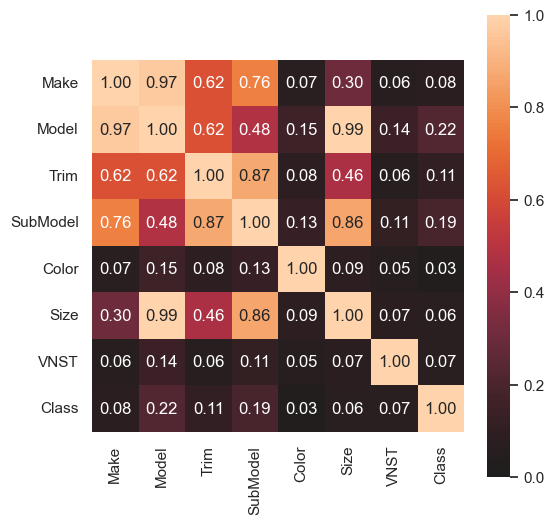

In [101]:
categorical_correlation= associations(findRelation, filename= 'categorical_correlation.png', figsize=(6,6))

- According to the scale of Pearson's Correlation Coefficient,

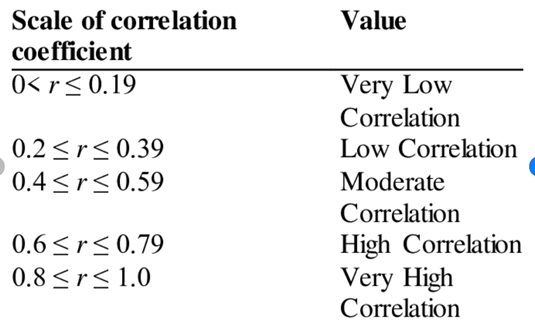

- Data mining will drop those very high correlated data as it will make the model overfitting.

- From visualization above, found that Model and Make are very highly correlated, can consider to drop one of them. Since Model is more correlated to the target variable, Class, hence the Make can be drop from the dataset.

- Model and Size have very highly correlated, one of them has to be droped from dataset. Since Model is more correlated to the target variable, Class, hence the Size can be drop from the dataset.

- Trim and the Submodel are very highly correlated, since SubModel has the more correlated to target variable, Trim is suggested to drop from the dataset

- SubModel and Size are very highly correlated, SubModel will be kept in the dataset since it has the higher value of corelation coefficient with the target variable 


In [102]:
# Drop those very highly correlated categorical data to prevent the overfitting of the model
# VHCD = Very Highly Correlated Data 
VHCD = ['Make', 'Size', 'Trim']
ds_binning_dropVHCD = ds_binning.drop(VHCD, axis=1)

In [103]:
# save the file into python and observe is all the data being change 
#ds_binning_dropVHCD.to_excel('C:/Users/hojk8/Downloads/IT trazining/Data Mining Assignment/ds_binning_dropVHCD.xlsx', index=False)n

In [104]:
# only observe the relationship for those categorical data that have many dimension with target variable
manyDimensionCol2 = ['Model','SubModel','Color', 'VNST', 'Class']
findRelation2 = ds_binning_dropVHCD[manyDimensionCol2]

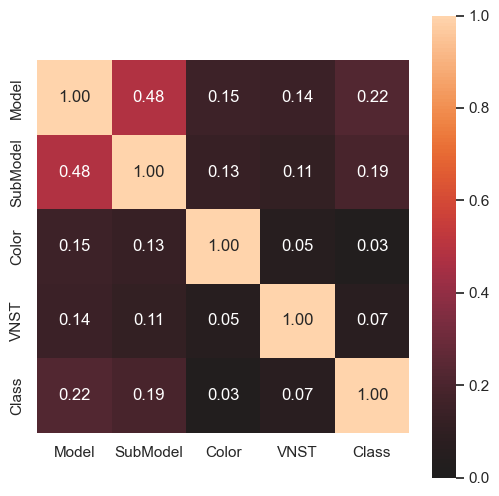

In [105]:
categorical_correlation2 = associations(findRelation2, filename= 'categorical_correlation2.png', figsize=(6,6))

there is no very highly correlated data here anymore

In [106]:
# color
ds_binning_dropVHCD['Color'].value_counts()

SILVER         13683
WHITE          11285
BLUE            9515
GREY            7422
BLACK           6965
RED             5678
GOLD            4767
GREEN           2961
MAROON          1888
BEIGE           1435
BROWN            416
ORANGE           381
PURPLE           347
YELLOW           233
OTHER            175
'NOT AVAIL'       60
Name: Color, dtype: int64

In [107]:
# decide to go for neutral and simple colors like black, white, silver, or gray because they guarantee a good resale value and easy maintenance. 

# combine other colors together except black, white, silver, grey
chgColorName = ['BLUE', 'RED', 'GOLD', 'GREEN', 'MAROON', 'BEIGE', 'BROWN', 'ORANGE', 'PURPLE', 'YELLOW','NOT AVAIL' ]
ds_binning_dropVHCD['Color'] = ds_binning_dropVHCD["Color"].replace(chgColorName, 'OTHER', regex=True)
# make sure it has been change 
ds_binning_dropVHCD['Color'].value_counts()

OTHER      27796
SILVER     13683
WHITE      11285
GREY        7422
BLACK       6965
'OTHER'       60
Name: Color, dtype: int64

In [108]:
# remove all single quote from Color
ds_binning_dropVHCD['Color'] = ds_binning_dropVHCD["Color"].str.strip(" \' ")
# make sure it has been changed
ds_binning_dropVHCD['Color'].value_counts()

OTHER     27856
SILVER    13683
WHITE     11285
GREY       7422
BLACK      6965
Name: Color, dtype: int64

In [109]:
# ds_RDC = Reduce Dimension for Color
ds_RDC = ds_binning_dropVHCD

In [110]:
# VNST
# there is no predictive function for VNST to determine the target variable 
ds_binning_dropVNST = ds_RDC.drop("VNST", axis=1)

In [111]:
# Submodel of car
ds_binning_dropVNST['SubModel'].value_counts()

4D SEDAN                    13363
4D SEDAN LS                  4541
4D SEDAN SE                  3648
4D WAGON                     1979
MINIVAN 3.3L                 1203
                            ...  
5D SEDAN S GRAND TOURING        1
REG CAB 3.0L XLT                1
4D SUV 5.9L SLT PLUS            1
2D COUPE GX                     1
4D SEDAN LUXURY AWD             1
Name: SubModel, Length: 823, dtype: int64

In [112]:
# Drop the Model and SubModel from dataset, and use Type of car
CarType = []

In [113]:
a = ds_binning_dropVNST

In [114]:
for i in range(0, a.shape[0]):
    if "SUV" in a['SubModel'][i]: 
        CarType.append("SUV")
    elif "HATCHBACK" in a['SubModel'][i]: 
        CarType.append("HATCHBACK")
    elif  "CROSSOVER" in a['SubModel'][i]: 
        CarType.append("CROSSOVER")
    elif  "CONVERTIBLE" in a['SubModel'][i]: 
        CarType.append("CONVERTIBLE")
    elif  "SEDAN" in a['SubModel'][i]: 
        CarType.append("SEDAN")
    elif  "SPORT" in a['SubModel'][i]: 
        CarType.append("SPORT")
    elif  "COUPE" in a['SubModel'][i]: 
        CarType.append("COUPE")
    elif  "MINIVAN" in a['SubModel'][i]: 
        CarType.append("MINIVAN")
    elif  "WAGON" in a['SubModel'][i]: 
        CarType.append("WAGON")

In [115]:
df = pd.DataFrame()

In [116]:
df['CarType'] = CarType

In [117]:
df['CarType'].value_counts()

SEDAN          39087
SUV             7972
WAGON           3790
MINIVAN         2834
SPORT           2533
COUPE           2432
CONVERTIBLE      437
HATCHBACK        212
CROSSOVER         49
Name: CarType, dtype: int64

In [118]:
df

CarType
0       SEDAN
1       SEDAN
2       SEDAN
3       SEDAN
4       SEDAN
...       ...
59341   SEDAN
59342   SPORT
59343   SEDAN
59344     SUV
59345   SEDAN

[59346 rows x 1 columns]

In [119]:
df.insert(0, 'New_ID', range(1, 1 + len(df)))
df

New_ID CarType
0           1   SEDAN
1           2   SEDAN
2           3   SEDAN
3           4   SEDAN
4           5   SEDAN
...       ...     ...
59341   59342   SEDAN
59342   59343   SPORT
59343   59344   SEDAN
59344   59345     SUV
59345   59346   SEDAN

[59346 rows x 2 columns]

In [120]:
ds_binning_dropVNST.insert(0, 'New_ID', range(1, 1 + len(ds_binning_dropVNST)))
ds_binning_dropVNST

New_ID  VehYear   VehOdo  VehBCost  WarrantyCost  Auction  \
0           1   2006.0  51954.0    6500.0        1086.0  MANHEIM   
1           2   2005.0  89127.0    3680.0         983.0    ADESA   
2           3   2006.0  71271.0    7170.0        1974.0  MANHEIM   
3           4   2008.0  83338.0    7670.0        2152.0  MANHEIM   
4           5   2007.0  58698.0    7165.0        1500.0    ADESA   
...       ...      ...      ...       ...           ...      ...   
67206   67207   2008.0  56072.0    6680.0        1086.0  MANHEIM   
67207   67208   2004.0  94232.0    8265.0         909.0    ADESA   
67208   67209   2004.0  79534.0    4950.0        1506.0    ADESA   
67209   67210   2003.0  79394.0    5220.0        1155.0  MANHEIM   
67210   67211   2004.0  94491.0    5890.0        1774.0  MANHEIM   

                      Model              SubModel   Color Transmission  \
0                STRATUS V6      4D SEDAN SXT FFV  SILVER         AUTO   
1        TAURUS 3.0L V6 EFI           4D SEDAN SE  SILVER         AUTO   
2      GRAND PRIX 3.8L V6 S              4D SEDAN   OTHER         AUTO   
3                 IMPALA V6  4D SEDAN LS 3.5L FFV   BLACK         AUTO   
4                    IMPALA      4D SEDAN LT 3.5L   WHITE         AUTO   
...                     ...                   ...     ...          ...   
67206            PT CRUISER              4D SEDAN   OTHER         AUTO   
67207     PATHFINDER 2WD V6   4D SPORT UTILITY LE   BLACK         AUTO   
67208           GRAND AM 4C           4D SEDAN SE   OTHER         AUTO   
67209        RENDEZVOUS FWD             4D SUV CX   WHITE         AUTO   
67210                MAZDA6            5D SEDAN S   OTHER         AUTO   

      WheelType     Nationality  VNZIP1  IsOnlineSale  Class  Potential_Value  
0        Covers        AMERICAN   32124             0      0           -604.0  
1        Covers        AMERICAN   78754             0      0              0.0  
2         Alloy        AMERICAN   80011             0      0            108.0  
3        Covers        AMERICAN   94544             0      0           -125.0  
4         Alloy        AMERICAN   77086             0      0          -1672.0  
...         ...             ...     ...           ...    ...              ...  
67206    Covers        AMERICAN   77061             0      1            239.0  
67207     Alloy  TOP LINE ASIAN   28273             0      1          -1647.0  
67208     Alloy        AMERICAN   37771             0      1            385.0  
67209    Covers        AMERICAN   92337             0      1           -445.0  
67210     Alloy     OTHER ASIAN   87105             0      1           -575.0  

[67211 rows x 16 columns]

In [121]:
new_Dataset = pd.merge(ds_binning_dropVNST,df,on='New_ID',how='left')
new_Dataset

New_ID  VehYear   VehOdo  VehBCost  WarrantyCost  Auction  \
0           1   2006.0  51954.0    6500.0        1086.0  MANHEIM   
1           2   2005.0  89127.0    3680.0         983.0    ADESA   
2           3   2006.0  71271.0    7170.0        1974.0  MANHEIM   
3           4   2008.0  83338.0    7670.0        2152.0  MANHEIM   
4           5   2007.0  58698.0    7165.0        1500.0    ADESA   
...       ...      ...      ...       ...           ...      ...   
67206   67207   2008.0  56072.0    6680.0        1086.0  MANHEIM   
67207   67208   2004.0  94232.0    8265.0         909.0    ADESA   
67208   67209   2004.0  79534.0    4950.0        1506.0    ADESA   
67209   67210   2003.0  79394.0    5220.0        1155.0  MANHEIM   
67210   67211   2004.0  94491.0    5890.0        1774.0  MANHEIM   

                      Model              SubModel   Color Transmission  \
0                STRATUS V6      4D SEDAN SXT FFV  SILVER         AUTO   
1        TAURUS 3.0L V6 EFI           4D SEDAN SE  SILVER         AUTO   
2      GRAND PRIX 3.8L V6 S              4D SEDAN   OTHER         AUTO   
3                 IMPALA V6  4D SEDAN LS 3.5L FFV   BLACK         AUTO   
4                    IMPALA      4D SEDAN LT 3.5L   WHITE         AUTO   
...                     ...                   ...     ...          ...   
67206            PT CRUISER              4D SEDAN   OTHER         AUTO   
67207     PATHFINDER 2WD V6   4D SPORT UTILITY LE   BLACK         AUTO   
67208           GRAND AM 4C           4D SEDAN SE   OTHER         AUTO   
67209        RENDEZVOUS FWD             4D SUV CX   WHITE         AUTO   
67210                MAZDA6            5D SEDAN S   OTHER         AUTO   

      WheelType     Nationality  VNZIP1  IsOnlineSale  Class  Potential_Value  \
0        Covers        AMERICAN   32124             0      0           -604.0   
1        Covers        AMERICAN   78754             0      0              0.0   
2         Alloy        AMERICAN   80011             0      0            108.0   
3        Covers        AMERICAN   94544             0      0           -125.0   
4         Alloy        AMERICAN   77086             0      0          -1672.0   
...         ...             ...     ...           ...    ...              ...   
67206    Covers        AMERICAN   77061             0      1            239.0   
67207     Alloy  TOP LINE ASIAN   28273             0      1          -1647.0   
67208     Alloy        AMERICAN   37771             0      1            385.0   
67209    Covers        AMERICAN   92337             0      1           -445.0   
67210     Alloy     OTHER ASIAN   87105             0      1           -575.0   

      CarType  
0       SEDAN  
1       SEDAN  
2       SEDAN  
3       SEDAN  
4       SEDAN  
...       ...  
67206     NaN  
67207     NaN  
67208     NaN  
67209     NaN  
67210     NaN  

[67211 rows x 17 columns]

In [122]:
new_Dataset['CarType'] = new_Dataset['CarType'].fillna("OTHER")

In [123]:
new_Dataset

New_ID  VehYear   VehOdo  VehBCost  WarrantyCost  Auction  \
0           1   2006.0  51954.0    6500.0        1086.0  MANHEIM   
1           2   2005.0  89127.0    3680.0         983.0    ADESA   
2           3   2006.0  71271.0    7170.0        1974.0  MANHEIM   
3           4   2008.0  83338.0    7670.0        2152.0  MANHEIM   
4           5   2007.0  58698.0    7165.0        1500.0    ADESA   
...       ...      ...      ...       ...           ...      ...   
67206   67207   2008.0  56072.0    6680.0        1086.0  MANHEIM   
67207   67208   2004.0  94232.0    8265.0         909.0    ADESA   
67208   67209   2004.0  79534.0    4950.0        1506.0    ADESA   
67209   67210   2003.0  79394.0    5220.0        1155.0  MANHEIM   
67210   67211   2004.0  94491.0    5890.0        1774.0  MANHEIM   

                      Model              SubModel   Color Transmission  \
0                STRATUS V6      4D SEDAN SXT FFV  SILVER         AUTO   
1        TAURUS 3.0L V6 EFI           4D SEDAN SE  SILVER         AUTO   
2      GRAND PRIX 3.8L V6 S              4D SEDAN   OTHER         AUTO   
3                 IMPALA V6  4D SEDAN LS 3.5L FFV   BLACK         AUTO   
4                    IMPALA      4D SEDAN LT 3.5L   WHITE         AUTO   
...                     ...                   ...     ...          ...   
67206            PT CRUISER              4D SEDAN   OTHER         AUTO   
67207     PATHFINDER 2WD V6   4D SPORT UTILITY LE   BLACK         AUTO   
67208           GRAND AM 4C           4D SEDAN SE   OTHER         AUTO   
67209        RENDEZVOUS FWD             4D SUV CX   WHITE         AUTO   
67210                MAZDA6            5D SEDAN S   OTHER         AUTO   

      WheelType     Nationality  VNZIP1  IsOnlineSale  Class  Potential_Value  \
0        Covers        AMERICAN   32124             0      0           -604.0   
1        Covers        AMERICAN   78754             0      0              0.0   
2         Alloy        AMERICAN   80011             0      0            108.0   
3        Covers        AMERICAN   94544             0      0           -125.0   
4         Alloy        AMERICAN   77086             0      0          -1672.0   
...         ...             ...     ...           ...    ...              ...   
67206    Covers        AMERICAN   77061             0      1            239.0   
67207     Alloy  TOP LINE ASIAN   28273             0      1          -1647.0   
67208     Alloy        AMERICAN   37771             0      1            385.0   
67209    Covers        AMERICAN   92337             0      1           -445.0   
67210     Alloy     OTHER ASIAN   87105             0      1           -575.0   

      CarType  
0       SEDAN  
1       SEDAN  
2       SEDAN  
3       SEDAN  
4       SEDAN  
...       ...  
67206   OTHER  
67207   OTHER  
67208   OTHER  
67209   OTHER  
67210   OTHER  

[67211 rows x 17 columns]

In [124]:
drop_col2 = ['New_ID', 'Model', 'SubModel']
ds_binning_dropM = new_Dataset.drop(drop_col2, axis=1)

In [125]:
ds_binning_dropM

VehYear   VehOdo  VehBCost  WarrantyCost  Auction   Color Transmission  \
0       2006.0  51954.0    6500.0        1086.0  MANHEIM  SILVER         AUTO   
1       2005.0  89127.0    3680.0         983.0    ADESA  SILVER         AUTO   
2       2006.0  71271.0    7170.0        1974.0  MANHEIM   OTHER         AUTO   
3       2008.0  83338.0    7670.0        2152.0  MANHEIM   BLACK         AUTO   
4       2007.0  58698.0    7165.0        1500.0    ADESA   WHITE         AUTO   
...        ...      ...       ...           ...      ...     ...          ...   
67206   2008.0  56072.0    6680.0        1086.0  MANHEIM   OTHER         AUTO   
67207   2004.0  94232.0    8265.0         909.0    ADESA   BLACK         AUTO   
67208   2004.0  79534.0    4950.0        1506.0    ADESA   OTHER         AUTO   
67209   2003.0  79394.0    5220.0        1155.0  MANHEIM   WHITE         AUTO   
67210   2004.0  94491.0    5890.0        1774.0  MANHEIM   OTHER         AUTO   

      WheelType     Nationality  VNZIP1  IsOnlineSale  Class  Potential_Value  \
0        Covers        AMERICAN   32124             0      0           -604.0   
1        Covers        AMERICAN   78754             0      0              0.0   
2         Alloy        AMERICAN   80011             0      0            108.0   
3        Covers        AMERICAN   94544             0      0           -125.0   
4         Alloy        AMERICAN   77086             0      0          -1672.0   
...         ...             ...     ...           ...    ...              ...   
67206    Covers        AMERICAN   77061             0      1            239.0   
67207     Alloy  TOP LINE ASIAN   28273             0      1          -1647.0   
67208     Alloy        AMERICAN   37771             0      1            385.0   
67209    Covers        AMERICAN   92337             0      1           -445.0   
67210     Alloy     OTHER ASIAN   87105             0      1           -575.0   

      CarType  
0       SEDAN  
1       SEDAN  
2       SEDAN  
3       SEDAN  
4       SEDAN  
...       ...  
67206   OTHER  
67207   OTHER  
67208   OTHER  
67209   OTHER  
67210   OTHER  

[67211 rows x 14 columns]

In [126]:
ds_binning_dropM['CarType'].value_counts()

SEDAN          39087
SUV             7972
OTHER           7865
WAGON           3790
MINIVAN         2834
SPORT           2533
COUPE           2432
CONVERTIBLE      437
HATCHBACK        212
CROSSOVER         49
Name: CarType, dtype: int64

In [127]:
ds_binning_categorical = ds_binning_dropM

In [128]:
# save the file into python and observe is all the data being change 
#ds_binning_categorical.to_excel('C:/Users/hojk8/Downloads/IT training/Data Mining Assignment/ds_binning_categorical.xlsx', index=False)

# Data Binning - Continuous Data 

In [129]:
# 1. VehOdo
ds_binning_categorical['VehOdo'], cut_bin_Odo = pd.qcut(ds_binning_categorical['VehOdo'], q = 5, labels = ['(31618, 59445.0] ', '(59445.0, 69907.0]', '(69907.0, 77083.0] ', '(77083.0, 84497.0] ', '(84497.0, 112056.0]'], retbins = True)
ds_binning_categorical.head()

VehYear               VehOdo  VehBCost  WarrantyCost  Auction   Color  \
0   2006.0    (31618, 59445.0]     6500.0        1086.0  MANHEIM  SILVER   
1   2005.0  (84497.0, 112056.0]    3680.0         983.0    ADESA  SILVER   
2   2006.0  (69907.0, 77083.0]     7170.0        1974.0  MANHEIM   OTHER   
3   2008.0  (77083.0, 84497.0]     7670.0        2152.0  MANHEIM   BLACK   
4   2007.0    (31618, 59445.0]     7165.0        1500.0    ADESA   WHITE   

  Transmission WheelType Nationality  VNZIP1  IsOnlineSale  Class  \
0         AUTO    Covers    AMERICAN   32124             0      0   
1         AUTO    Covers    AMERICAN   78754             0      0   
2         AUTO     Alloy    AMERICAN   80011             0      0   
3         AUTO    Covers    AMERICAN   94544             0      0   
4         AUTO     Alloy    AMERICAN   77086             0      0   

   Potential_Value CarType  
0           -604.0   SEDAN  
1              0.0   SEDAN  
2            108.0   SEDAN  
3           -125.0   SEDAN  
4          -1672.0   SEDAN

In [130]:
#print (cut_bin_Odo)

In [131]:
# 2. VehBCost
ds_binning_categorical['VehBCost'], cut_bin_Cost = pd.qcut(ds_binning_categorical['VehBCost'], q = 5, labels = ['(1914, 5195] ', '(5195, 6200]', '(6200, 7235] ', '(7235, 8175] ', '(8175, 11570]'], retbins = True)
ds_binning_categorical.head()

VehYear               VehOdo       VehBCost  WarrantyCost  Auction   Color  \
0   2006.0    (31618, 59445.0]   (6200, 7235]         1086.0  MANHEIM  SILVER   
1   2005.0  (84497.0, 112056.0]  (1914, 5195]          983.0    ADESA  SILVER   
2   2006.0  (69907.0, 77083.0]   (6200, 7235]         1974.0  MANHEIM   OTHER   
3   2008.0  (77083.0, 84497.0]   (7235, 8175]         2152.0  MANHEIM   BLACK   
4   2007.0    (31618, 59445.0]   (6200, 7235]         1500.0    ADESA   WHITE   

  Transmission WheelType Nationality  VNZIP1  IsOnlineSale  Class  \
0         AUTO    Covers    AMERICAN   32124             0      0   
1         AUTO    Covers    AMERICAN   78754             0      0   
2         AUTO     Alloy    AMERICAN   80011             0      0   
3         AUTO    Covers    AMERICAN   94544             0      0   
4         AUTO     Alloy    AMERICAN   77086             0      0   

   Potential_Value CarType  
0           -604.0   SEDAN  
1              0.0   SEDAN  
2            108.0   SEDAN  
3           -125.0   SEDAN  
4          -1672.0   SEDAN

In [132]:
#print(cut_bin_Cost)

In [133]:
# WarrantyCost
ds_binning_categorical['WarrantyCost'], cut_bin_Wcost = pd.qcut(ds_binning_categorical['WarrantyCost'], q = 5, labels = ['(461, 803] ', '(803, 1038]', '(1038, 1313] ', '(1313, 1703] ', '(1703, 2735]'], retbins = True)
ds_binning_categorical.head()

VehYear               VehOdo       VehBCost   WarrantyCost  Auction  \
0   2006.0    (31618, 59445.0]   (6200, 7235]   (1038, 1313]   MANHEIM   
1   2005.0  (84497.0, 112056.0]  (1914, 5195]     (803, 1038]    ADESA   
2   2006.0  (69907.0, 77083.0]   (6200, 7235]    (1703, 2735]  MANHEIM   
3   2008.0  (77083.0, 84497.0]   (7235, 8175]    (1703, 2735]  MANHEIM   
4   2007.0    (31618, 59445.0]   (6200, 7235]   (1313, 1703]     ADESA   

    Color Transmission WheelType Nationality  VNZIP1  IsOnlineSale  Class  \
0  SILVER         AUTO    Covers    AMERICAN   32124             0      0   
1  SILVER         AUTO    Covers    AMERICAN   78754             0      0   
2   OTHER         AUTO     Alloy    AMERICAN   80011             0      0   
3   BLACK         AUTO    Covers    AMERICAN   94544             0      0   
4   WHITE         AUTO     Alloy    AMERICAN   77086             0      0   

   Potential_Value CarType  
0           -604.0   SEDAN  
1              0.0   SEDAN  
2            108.0   SEDAN  
3           -125.0   SEDAN  
4          -1672.0   SEDAN

In [134]:
#print(cut_bin_Wcost)

In [135]:
# VNZIP1
ds_binning_categorical['VNZIP1'], cut_bin_VNZIP = pd.qcut(ds_binning_categorical['VNZIP1'], q = 5, labels = ['(2763, 29697] ', '(29697, 37122]', '(37122, 76040] ', '(76040, 84104] ', '(84104, 99224]'], retbins = True)
ds_binning_categorical.head()

VehYear               VehOdo       VehBCost   WarrantyCost  Auction  \
0   2006.0    (31618, 59445.0]   (6200, 7235]   (1038, 1313]   MANHEIM   
1   2005.0  (84497.0, 112056.0]  (1914, 5195]     (803, 1038]    ADESA   
2   2006.0  (69907.0, 77083.0]   (6200, 7235]    (1703, 2735]  MANHEIM   
3   2008.0  (77083.0, 84497.0]   (7235, 8175]    (1703, 2735]  MANHEIM   
4   2007.0    (31618, 59445.0]   (6200, 7235]   (1313, 1703]     ADESA   

    Color Transmission WheelType Nationality           VNZIP1  IsOnlineSale  \
0  SILVER         AUTO    Covers    AMERICAN   (29697, 37122]             0   
1  SILVER         AUTO    Covers    AMERICAN  (76040, 84104]              0   
2   OTHER         AUTO     Alloy    AMERICAN  (76040, 84104]              0   
3   BLACK         AUTO    Covers    AMERICAN   (84104, 99224]             0   
4   WHITE         AUTO     Alloy    AMERICAN  (76040, 84104]              0   

   Class  Potential_Value CarType  
0      0           -604.0   SEDAN  
1      0              0.0   SEDAN  
2      0            108.0   SEDAN  
3      0           -125.0   SEDAN  
4      0          -1672.0   SEDAN

In [136]:
#print(cut_bin_VNZIP)

In [137]:
# Potential_Value
ds_binning_categorical['Potential_Value'], cut_bin_PV = pd.qcut(ds_binning_categorical['Potential_Value'], q = 5, labels = ['(-12103, -478] ', '(-478, 0]', '(0, 219] ', '(219, 854] ', '(854, 12077]'], retbins = True)
ds_binning_categorical.head()

VehYear               VehOdo       VehBCost   WarrantyCost  Auction  \
0   2006.0    (31618, 59445.0]   (6200, 7235]   (1038, 1313]   MANHEIM   
1   2005.0  (84497.0, 112056.0]  (1914, 5195]     (803, 1038]    ADESA   
2   2006.0  (69907.0, 77083.0]   (6200, 7235]    (1703, 2735]  MANHEIM   
3   2008.0  (77083.0, 84497.0]   (7235, 8175]    (1703, 2735]  MANHEIM   
4   2007.0    (31618, 59445.0]   (6200, 7235]   (1313, 1703]     ADESA   

    Color Transmission WheelType Nationality           VNZIP1  IsOnlineSale  \
0  SILVER         AUTO    Covers    AMERICAN   (29697, 37122]             0   
1  SILVER         AUTO    Covers    AMERICAN  (76040, 84104]              0   
2   OTHER         AUTO     Alloy    AMERICAN  (76040, 84104]              0   
3   BLACK         AUTO    Covers    AMERICAN   (84104, 99224]             0   
4   WHITE         AUTO     Alloy    AMERICAN  (76040, 84104]              0   

   Class  Potential_Value CarType  
0      0  (-12103, -478]    SEDAN  
1      0        (-478, 0]   SEDAN  
2      0        (0, 219]    SEDAN  
3      0        (-478, 0]   SEDAN  
4      0  (-12103, -478]    SEDAN

In [138]:
#print(cut_bin_PV)

In [139]:
ds_binning_numerical = ds_binning_categorical

In [140]:
# save the file into python and observe is all the data being change 
#ds_binning_numerical.to_excel('C:/Users/hojk8/Downloads/IT training/Data Mining Assignment/ds_binning_numerical.xlsx', index=False)

In [141]:
ds['Class'].value_counts()

0    60795
1     6416
Name: Class, dtype: int64

In [142]:
ds_binning_numerical

VehYear               VehOdo       VehBCost   WarrantyCost  Auction  \
0       2006.0    (31618, 59445.0]   (6200, 7235]   (1038, 1313]   MANHEIM   
1       2005.0  (84497.0, 112056.0]  (1914, 5195]     (803, 1038]    ADESA   
2       2006.0  (69907.0, 77083.0]   (6200, 7235]    (1703, 2735]  MANHEIM   
3       2008.0  (77083.0, 84497.0]   (7235, 8175]    (1703, 2735]  MANHEIM   
4       2007.0    (31618, 59445.0]   (6200, 7235]   (1313, 1703]     ADESA   
...        ...                  ...            ...            ...      ...   
67206   2008.0    (31618, 59445.0]   (6200, 7235]   (1038, 1313]   MANHEIM   
67207   2004.0  (84497.0, 112056.0]  (8175, 11570]    (803, 1038]    ADESA   
67208   2004.0  (77083.0, 84497.0]   (1914, 5195]   (1313, 1703]     ADESA   
67209   2003.0  (77083.0, 84497.0]    (5195, 6200]  (1038, 1313]   MANHEIM   
67210   2004.0  (84497.0, 112056.0]   (5195, 6200]   (1703, 2735]  MANHEIM   

        Color Transmission WheelType     Nationality           VNZIP1  \
0      SILVER         AUTO    Covers        AMERICAN   (29697, 37122]   
1      SILVER         AUTO    Covers        AMERICAN  (76040, 84104]    
2       OTHER         AUTO     Alloy        AMERICAN  (76040, 84104]    
3       BLACK         AUTO    Covers        AMERICAN   (84104, 99224]   
4       WHITE         AUTO     Alloy        AMERICAN  (76040, 84104]    
...       ...          ...       ...             ...              ...   
67206   OTHER         AUTO    Covers        AMERICAN  (76040, 84104]    
67207   BLACK         AUTO     Alloy  TOP LINE ASIAN   (2763, 29697]    
67208   OTHER         AUTO     Alloy        AMERICAN  (37122, 76040]    
67209   WHITE         AUTO    Covers        AMERICAN   (84104, 99224]   
67210   OTHER         AUTO     Alloy     OTHER ASIAN   (84104, 99224]   

       IsOnlineSale  Class  Potential_Value CarType  
0                 0      0  (-12103, -478]    SEDAN  
1                 0      0        (-478, 0]   SEDAN  
2                 0      0        (0, 219]    SEDAN  
3                 0      0        (-478, 0]   SEDAN  
4                 0      0  (-12103, -478]    SEDAN  
...             ...    ...              ...     ...  
67206             0      1      (219, 854]    OTHER  
67207             0      1  (-12103, -478]    OTHER  
67208             0      1      (219, 854]    OTHER  
67209             0      1        (-478, 0]   OTHER  
67210             0      1  (-12103, -478]    OTHER  

[67211 rows x 14 columns]

# Feature Engineering 

In [143]:
ds_binning_numerical.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 67211 entries, 0 to 67210
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   VehYear          67211 non-null  float64 
 1   VehOdo           67211 non-null  category
 2   VehBCost         67211 non-null  category
 3   WarrantyCost     67211 non-null  category
 4   Auction          67211 non-null  object  
 5   Color            67211 non-null  object  
 6   Transmission     67211 non-null  object  
 7   WheelType        67211 non-null  object  
 8   Nationality      67211 non-null  object  
 9   VNZIP1           67211 non-null  category
 10  IsOnlineSale     67211 non-null  int64   
 11  Class            67211 non-null  int64   
 12  Potential_Value  67211 non-null  category
 13  CarType          67211 non-null  object  
dtypes: category(5), float64(1), int64(2), object(6)
memory usage: 5.4+ MB


In [144]:
# cols_D = columns that want to make into dummy
cols_D = ['VehYear', 'VehOdo', 'VehBCost', 'WarrantyCost', 'Auction', 'Color', 'Transmission', 'WheelType', 'Nationality', 'VNZIP1', 'Potential_Value', 'CarType' ]

# create dummy variables 
ds_dummy = pd.get_dummies(ds_binning_numerical[cols_D])
ds_dummy

VehYear  VehOdo_(31618, 59445.0]   VehOdo_(59445.0, 69907.0]  \
0       2006.0                         1                          0   
1       2005.0                         0                          0   
2       2006.0                         0                          0   
3       2008.0                         0                          0   
4       2007.0                         1                          0   
...        ...                       ...                        ...   
67206   2008.0                         1                          0   
67207   2004.0                         0                          0   
67208   2004.0                         0                          0   
67209   2003.0                         0                          0   
67210   2004.0                         0                          0   

       VehOdo_(69907.0, 77083.0]   VehOdo_(77083.0, 84497.0]   \
0                               0                           0   
1                               0                           0   
2                               1                           0   
3                               0                           1   
4                               0                           0   
...                           ...                         ...   
67206                           0                           0   
67207                           0                           0   
67208                           0                           1   
67209                           0                           1   
67210                           0                           0   

       VehOdo_(84497.0, 112056.0]  VehBCost_(1914, 5195]   \
0                               0                       0   
1                               1                       1   
2                               0                       0   
3                               0                       0   
4                               0                       0   
...                           ...                     ...   
67206                           0                       0   
67207                           1                       0   
67208                           0                       1   
67209                           0                       0   
67210                           1                       0   

       VehBCost_(5195, 6200]  VehBCost_(6200, 7235]   VehBCost_(7235, 8175]   \
0                          0                       1                       0   
1                          0                       0                       0   
2                          0                       1                       0   
3                          0                       0                       1   
4                          0                       1                       0   
...                      ...                     ...                     ...   
67206                      0                       1                       0   
67207                      0                       0                       0   
67208                      0                       0                       0   
67209                      1                       0                       0   
67210                      1                       0                       0   

       ...  CarType_CONVERTIBLE  CarType_COUPE  CarType_CROSSOVER  \
0      ...                    0              0                  0   
1      ...                    0              0                  0   
2      ...                    0              0                  0   
3      ...                    0              0                  0   
4      ...                    0              0                  0   
...    ...                  ...            ...                ...   
67206  ...                    0              0                  0   
67207  ...                    0              0                  0   
67208  ...                    0              0            

In [145]:
ds_dummy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 67211 entries, 0 to 67210
Data columns (total 53 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   VehYear                          67211 non-null  float64
 1   VehOdo_(31618, 59445.0]          67211 non-null  uint8  
 2   VehOdo_(59445.0, 69907.0]        67211 non-null  uint8  
 3   VehOdo_(69907.0, 77083.0]        67211 non-null  uint8  
 4   VehOdo_(77083.0, 84497.0]        67211 non-null  uint8  
 5   VehOdo_(84497.0, 112056.0]       67211 non-null  uint8  
 6   VehBCost_(1914, 5195]            67211 non-null  uint8  
 7   VehBCost_(5195, 6200]            67211 non-null  uint8  
 8   VehBCost_(6200, 7235]            67211 non-null  uint8  
 9   VehBCost_(7235, 8175]            67211 non-null  uint8  
 10  VehBCost_(8175, 11570]           67211 non-null  uint8  
 11  WarrantyCost_(461, 803]          67211 non-null  uint8  
 12  WarrantyCost_(803,

In [146]:
# concat dummy columns with original final dataframe

ds_final_dummy = pd.concat([ds_binning_numerical,ds_dummy],axis=1)
ds_final_dummy

VehYear               VehOdo       VehBCost   WarrantyCost  Auction  \
0       2006.0    (31618, 59445.0]   (6200, 7235]   (1038, 1313]   MANHEIM   
1       2005.0  (84497.0, 112056.0]  (1914, 5195]     (803, 1038]    ADESA   
2       2006.0  (69907.0, 77083.0]   (6200, 7235]    (1703, 2735]  MANHEIM   
3       2008.0  (77083.0, 84497.0]   (7235, 8175]    (1703, 2735]  MANHEIM   
4       2007.0    (31618, 59445.0]   (6200, 7235]   (1313, 1703]     ADESA   
...        ...                  ...            ...            ...      ...   
67206   2008.0    (31618, 59445.0]   (6200, 7235]   (1038, 1313]   MANHEIM   
67207   2004.0  (84497.0, 112056.0]  (8175, 11570]    (803, 1038]    ADESA   
67208   2004.0  (77083.0, 84497.0]   (1914, 5195]   (1313, 1703]     ADESA   
67209   2003.0  (77083.0, 84497.0]    (5195, 6200]  (1038, 1313]   MANHEIM   
67210   2004.0  (84497.0, 112056.0]   (5195, 6200]   (1703, 2735]  MANHEIM   

        Color Transmission WheelType     Nationality           VNZIP1  ...  \
0      SILVER         AUTO    Covers        AMERICAN   (29697, 37122]  ...   
1      SILVER         AUTO    Covers        AMERICAN  (76040, 84104]   ...   
2       OTHER         AUTO     Alloy        AMERICAN  (76040, 84104]   ...   
3       BLACK         AUTO    Covers        AMERICAN   (84104, 99224]  ...   
4       WHITE         AUTO     Alloy        AMERICAN  (76040, 84104]   ...   
...       ...          ...       ...             ...              ...  ...   
67206   OTHER         AUTO    Covers        AMERICAN  (76040, 84104]   ...   
67207   BLACK         AUTO     Alloy  TOP LINE ASIAN   (2763, 29697]   ...   
67208   OTHER         AUTO     Alloy        AMERICAN  (37122, 76040]   ...   
67209   WHITE         AUTO    Covers        AMERICAN   (84104, 99224]  ...   
67210   OTHER         AUTO     Alloy     OTHER ASIAN   (84104, 99224]  ...   

       CarType_CONVERTIBLE  CarType_COUPE CarType_CROSSOVER CarType_HATCHBACK  \
0                        0              0                 0                 0   
1                        0              0                 0                 0   
2                        0              0                 0                 0   
3                        0              0                 0                 0   
4                        0              0                 0                 0   
...                    ...            ...               ...               ...   
67206                    0              0                 0                 0   
67207                    0              0                 0                 0   
67208                    0              0                 0                 0   
67209                    0              0                 0                 0   
67210                    0              0                 0                 0   

       CarType_MINIVAN  CarType_OTHER  CarType_SEDAN  CarType_SPORT  \
0                    0              0              1              0   
1                    0              0              1              0   
2                    0              0              1              0   
3                    0              0              1              0   
4                    0              0              1              0   
...                ...            ...            ...            ...   
67206                0              1              0              0   
67207                0              1              0              0   
67208                0              1              0              0   
67209                0              1              0              0   
67210                0              1              0              0   

       CarType_SUV  CarType_WAGON  
0                0              0  
1                0              0  
2                0              0  
3                0              0  
4                0              0  
...            ...            ...  
67206            0              0  
67207            0 

In [147]:
ds_final_dummy['VehOdo'].value_counts()

(31618, 59445.0]       13444
(59445.0, 69907.0]     13442
(69907.0, 77083.0]     13442
(84497.0, 112056.0]    13442
(77083.0, 84497.0]     13441
Name: VehOdo, dtype: int64

In [148]:
ds_final_dummy['VehBCost'].value_counts()

(1914, 5195]     13486
(7235, 8175]     13472
(6200, 7235]     13439
(5195, 6200]     13407
(8175, 11570]    13407
Name: VehBCost, dtype: int64

In [149]:
ds_final_dummy['WarrantyCost'].value_counts()

(1313, 1703]     14420
(461, 803]       13885
(803, 1038]      13586
(1038, 1313]     13255
(1703, 2735]     12065
Name: WarrantyCost, dtype: int64

In [150]:
ds_final_dummy['VNZIP1'].value_counts()

(37122, 76040]     14587
(2763, 29697]      14176
(84104, 99224]     13339
(29697, 37122]     12749
(76040, 84104]     12360
Name: VNZIP1, dtype: int64

In [151]:
ds_final_dummy['Potential_Value'].value_counts()

(-478, 0]          20045
(-12103, -478]     13447
(854, 12077]       13442
(219, 854]         13424
(0, 219]            6853
Name: Potential_Value, dtype: int64

In [152]:
# drop original cols_D and left those dummy cols 

ds_FinalClean_Dummy = ds_final_dummy.drop(cols_D,axis=1)
ds_FinalClean_Dummy

IsOnlineSale  Class  VehOdo_(31618, 59445.0]   \
0                 0      0                         1   
1                 0      0                         0   
2                 0      0                         0   
3                 0      0                         0   
4                 0      0                         1   
...             ...    ...                       ...   
67206             0      1                         1   
67207             0      1                         0   
67208             0      1                         0   
67209             0      1                         0   
67210             0      1                         0   

       VehOdo_(59445.0, 69907.0]  VehOdo_(69907.0, 77083.0]   \
0                              0                           0   
1                              0                           0   
2                              0                           1   
3                              0                           0   
4                              0                           0   
...                          ...                         ...   
67206                          0                           0   
67207                          0                           0   
67208                          0                           0   
67209                          0                           0   
67210                          0                           0   

       VehOdo_(77083.0, 84497.0]   VehOdo_(84497.0, 112056.0]  \
0                               0                           0   
1                               0                           1   
2                               0                           0   
3                               1                           0   
4                               0                           0   
...                           ...                         ...   
67206                           0                           0   
67207                           0                           1   
67208                           1                           0   
67209                           1                           0   
67210                           0                           1   

       VehBCost_(1914, 5195]   VehBCost_(5195, 6200]  VehBCost_(6200, 7235]   \
0                           0                      0                       1   
1                           1                      0                       0   
2                           0                      0                       1   
3                           0                      0                       0   
4                           0                      0                       1   
...                       ...                    ...                     ...   
67206                       0                      0                       1   
67207                       0                      0                       0   
67208                       1                      0                       0   
67209                       0                      1                       0   
67210                       0                      1                       0   

       ...  CarType_CONVERTIBLE  CarType_COUPE  CarType_CROSSOVER  \
0      ...                    0              0                  0   
1      ...                    0              0                  0   
2      ...                    0              0                  0   
3      ...                    0              0                  0   
4      ...                    0              0                  0   
...    ...                  ...            ...                ...   
67206  ...                    0              0                  0   
67207  ...                    0              0                  0   
67208  ...                    0              0                  0   
67209  ...                    0              0                  0   
67210  ...                    0              0                  

In [153]:
# Since Transmission (Auto) in dummy will also give the information of Transmission (Manual)
# Drop Transmission (Manual)
ds_FinalClean_Dummy = ds_FinalClean_Dummy.drop('Transmission_MANUAL',axis=1)
ds_FinalClean_Dummy

IsOnlineSale  Class  VehOdo_(31618, 59445.0]   \
0                 0      0                         1   
1                 0      0                         0   
2                 0      0                         0   
3                 0      0                         0   
4                 0      0                         1   
...             ...    ...                       ...   
67206             0      1                         1   
67207             0      1                         0   
67208             0      1                         0   
67209             0      1                         0   
67210             0      1                         0   

       VehOdo_(59445.0, 69907.0]  VehOdo_(69907.0, 77083.0]   \
0                              0                           0   
1                              0                           0   
2                              0                           1   
3                              0                           0   
4                              0                           0   
...                          ...                         ...   
67206                          0                           0   
67207                          0                           0   
67208                          0                           0   
67209                          0                           0   
67210                          0                           0   

       VehOdo_(77083.0, 84497.0]   VehOdo_(84497.0, 112056.0]  \
0                               0                           0   
1                               0                           1   
2                               0                           0   
3                               1                           0   
4                               0                           0   
...                           ...                         ...   
67206                           0                           0   
67207                           0                           1   
67208                           1                           0   
67209                           1                           0   
67210                           0                           1   

       VehBCost_(1914, 5195]   VehBCost_(5195, 6200]  VehBCost_(6200, 7235]   \
0                           0                      0                       1   
1                           1                      0                       0   
2                           0                      0                       1   
3                           0                      0                       0   
4                           0                      0                       1   
...                       ...                    ...                     ...   
67206                       0                      0                       1   
67207                       0                      0                       0   
67208                       1                      0                       0   
67209                       0                      1                       0   
67210                       0                      1                       0   

       ...  CarType_CONVERTIBLE  CarType_COUPE  CarType_CROSSOVER  \
0      ...                    0              0                  0   
1      ...                    0              0                  0   
2      ...                    0              0                  0   
3      ...                    0              0                  0   
4      ...                    0              0                  0   
...    ...                  ...            ...                ...   
67206  ...                    0              0                  0   
67207  ...                    0              0                  0   
67208  ...                    0              0                  0   
67209  ...                    0              0                  0   
67210  ...                    0              0                  

In [154]:
# save the file into python and observe is all the data being change 
#ds_FinalClean_Dummy.to_excel('C:/Users/hojk8/Downloads/IT training/Data Mining Assignment/ds_FinalClean_Dummy.xlsx', index=False)

# Feature Transformation / Feature Normalization

In [155]:
# separate data into X and Y
X = ds_FinalClean_Dummy.drop(['Class'], axis=1)
Y = ds_FinalClean_Dummy['Class']

In [156]:
sc_X = MinMaxScaler()
# XT = Transformation X 
XT = sc_X.fit_transform(X)
X = pd.DataFrame(XT, columns = X.columns)

# Train and Test 

In [157]:
# dependencies for decision tree
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder

# dependencies for neural network
import graphviz
import tensorflow.keras as keras
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.utils import to_categorical

# visualize neural network
import pydot
from PIL import Image

# dependencies for SVM
from sklearn.svm import SVC
from sklearn.metrics import classification_report

# dependencies for kNN
from sklearn.neighbors import KNeighborsClassifier

In [158]:
# pip install -U imbalanced-learn
# to oversample minority class and undersample majority class
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

# sampling (comment this block and rerun for random sampling)
over_sampler = RandomOverSampler(sampling_strategy='minority')
under_sampler = RandomUnderSampler(sampling_strategy='majority')
X, Y = over_sampler.fit_resample(X,Y)
X, Y = under_sampler.fit_resample(X,Y)

X_train,X_test,y_train,y_test = train_test_split(X,Y,random_state=42,train_size=0.8)

In [159]:
# get shape of train and test data
print("train size X : ",X_train.shape)
print("train size y : ",y_train.shape)
print("test size X : ",X_test.shape)
print("test size y : ",y_test.shape)

train size X :  (97272, 52)
train size y :  (97272,)
test size X :  (24318, 52)
test size y :  (24318,)


-------------

[[6527 5731]
 [3781 8279]]

Decision Tree Evaluation:

              precision    recall  f1-score   support

           0       0.63      0.53      0.58     12258
           1       0.59      0.69      0.64     12060

    accuracy                           0.61     24318
   macro avg       0.61      0.61      0.61     24318
weighted avg       0.61      0.61      0.61     24318


Test Loss:  0.6519239022956701


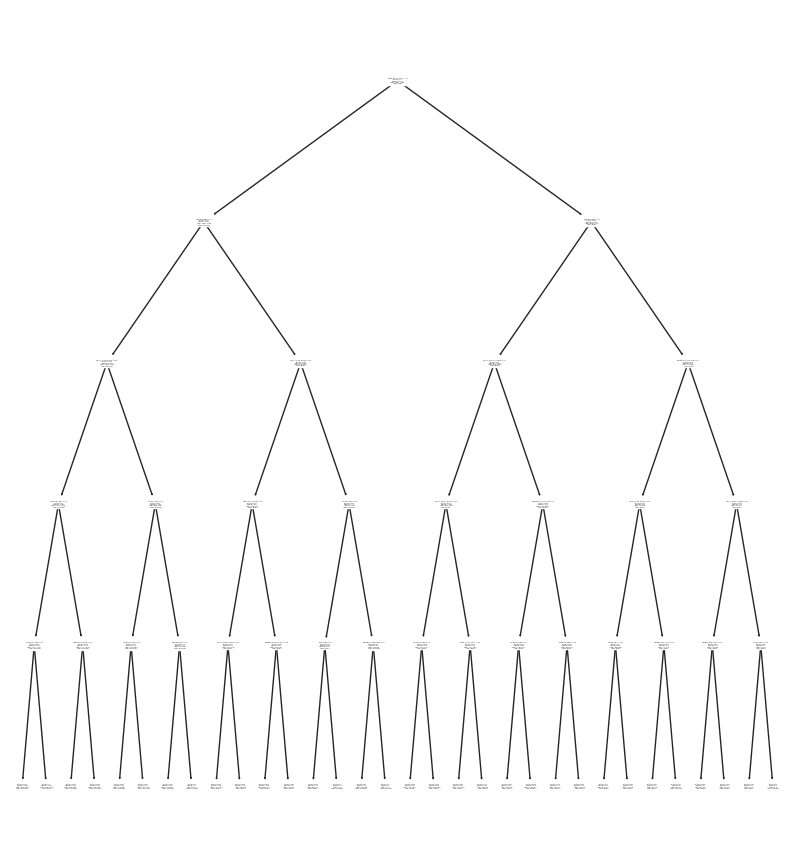

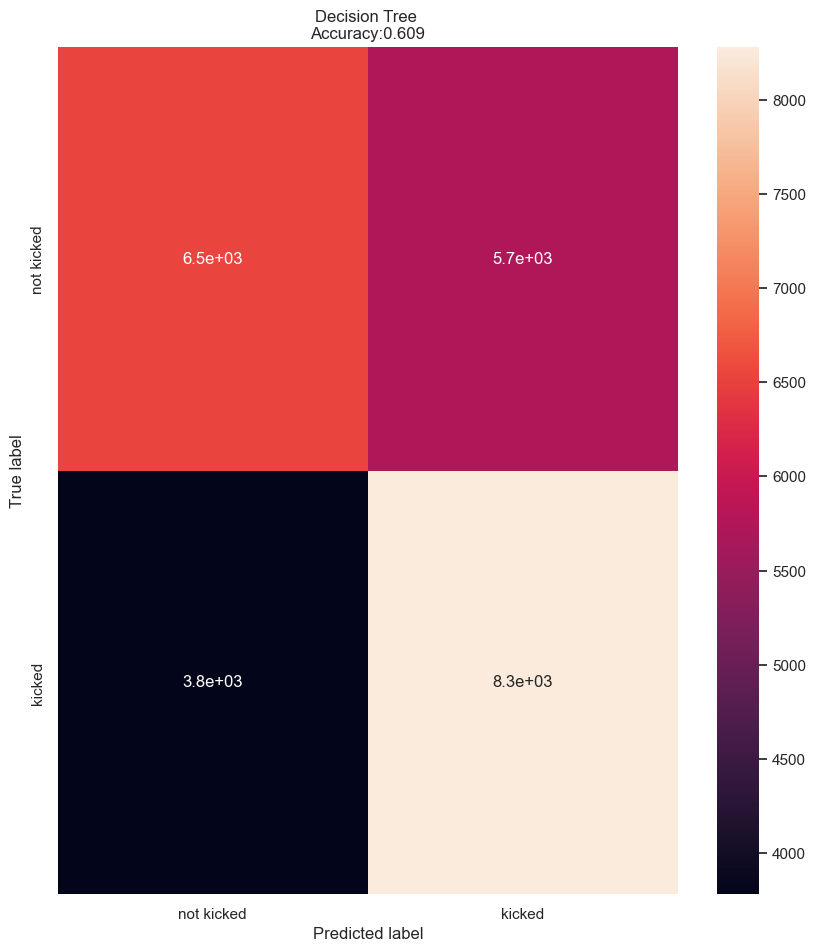

In [160]:
# DECISION TREE
encoder = LabelEncoder()
encoder.fit(y_train)
y_train_encoded = encoder.transform(y_train)
y_test_encoded = encoder.transform(y_test)

dt = DecisionTreeClassifier(criterion='entropy', max_depth=5)

dt = dt.fit(X_train, y_train_encoded)

# visualise decision tree
features = ['IsOnlineSale', 'VehOdo_(31618, 59445.0] ', 'VehOdo_(59445.0, 69907.0]',
       'VehOdo_(69907.0, 77083.0] ', 'VehOdo_(77083.0, 84497.0] ',
       'VehOdo_(84497.0, 112056.0]', 'VehBCost_(1914, 5195] ',
       'VehBCost_(5195, 6200]', 'VehBCost_(6200, 7235] ',
       'VehBCost_(7235, 8175] ', 'VehBCost_(8175, 11570]',
       'WarrantyCost_(461, 803] ', 'WarrantyCost_(803, 1038]',
       'WarrantyCost_(1038, 1313] ', 'WarrantyCost_(1313, 1703] ',
       'WarrantyCost_(1703, 2735]', 'Auction_ADESA', 'Auction_MANHEIM',
       'Auction_OTHER', 'Color_BLACK', 'Color_GREY', 'Color_OTHER',
       'Color_SILVER', 'Color_WHITE', 'Transmission_AUTO', 'WheelType_Alloy',
       'WheelType_Covers', 'WheelType_Special', 'Nationality_AMERICAN',
       'Nationality_OTHER', 'Nationality_OTHER ASIAN',
       'Nationality_TOP LINE ASIAN', 'VNZIP1_(2763, 29697] ',
       'VNZIP1_(29697, 37122]', 'VNZIP1_(37122, 76040] ',
       'VNZIP1_(76040, 84104] ', 'VNZIP1_(84104, 99224]',
       'Potential_Value_(-12103, -478] ', 'Potential_Value_(-478, 0]',
       'Potential_Value_(0, 219] ', 'Potential_Value_(219, 854] ',
       'Potential_Value_(854, 12077]', 'CarType_CONVERTIBLE', 'CarType_COUPE',
       'CarType_CROSSOVER', 'CarType_HATCHBACK', 'CarType_MINIVAN',
       'CarType_OTHER', 'CarType_SEDAN', 'CarType_SPORT', 'CarType_SUV',
       'CarType_WAGON']
classes=['not kicked','kicked']

tree.plot_tree(dt, feature_names=features, class_names=classes)

y_pred = dt.predict(X_test)
y_prob = dt.predict_proba(X_test)

cm = confusion_matrix(y_test_encoded, y_pred)
print("-------------\n")
print(cm)

print('\nDecision Tree Evaluation:\n')
print(classification_report(y_test_encoded,y_pred, zero_division=1))
EPSILON = 1e-7
test_loss = -np.mean(y_test * np.log(y_prob[:, 1] + EPSILON) + (1 - y_test) * np.log(1 - y_prob[:, 1] + EPSILON))
print('\nTest Loss: ',test_loss)

cm_df = pd.DataFrame(cm, index = ['not kicked','kicked'], columns = ['not kicked','kicked'])

plt.figure(figsize=(10,11))
sns.heatmap(cm_df, annot=True)
plt.title('Decision Tree \nAccuracy:{0:.3f}'.format\
         (accuracy_score(y_test_encoded, y_pred)))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


In [161]:
# NEURAL NETWORK
category_names = ['not kicked', 'kicked']

encoder = LabelEncoder()
encoder.fit(y_train)

y_train_encoded = to_categorical(encoder.transform(y_train))
y_test_encoded = to_categorical(encoder.transform(y_test))
y_train_encoded = pd.DataFrame(y_train_encoded, columns=category_names)
y_test_encoded = pd.DataFrame(y_test_encoded, columns=category_names)


print(y_test_encoded[:10])


model = Sequential()
model.add(Dense(100, input_dim=52, activation='relu'))
model.add(Dense(2, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', \
              metrics=['accuracy'])

history = model.fit(X_train, y_train_encoded, epochs=20, batch_size=10, validation_data=(X_test, y_test_encoded))


score = model.evaluate(X_test, y_test_encoded)
print('Test loss: ', score[0])
print('Test accuracy: ', score[1])
print('\n')

#visualize neural network model

keras.utils.plot_model(model, to_file='neuralnetwork.png', show_shapes=True)

y_pred = np.argmax(model.predict(X_test), axis=-1)
y_test_labels = np.argmax(y_test_encoded.values, axis=-1)

# Get confusion matrix
cm = confusion_matrix(y_test_labels, y_pred)

# Print confusion matrix
print("Confusion Matrix:\n", cm)

print('\nNeural Network Evaluation:\n')
print(classification_report(y_test,y_pred, zero_division=1))



img = Image.open('neuralnetwork.png')
img.show()


   not kicked  kicked
0         1.0     0.0
1         1.0     0.0
2         1.0     0.0
3         1.0     0.0
4         0.0     1.0
5         0.0     1.0
6         0.0     1.0
7         0.0     1.0
8         0.0     1.0
9         0.0     1.0
Epoch 1/20
9728/9728 [==============================] - 31s 3ms/step - loss: 0.6388 - accuracy: 0.6321 - val_loss: 0.6287 - val_accuracy: 0.6384
Epoch 2/20
9728/9728 [==============================] - 30s 3ms/step - loss: 0.6160 - accuracy: 0.6561 - val_loss: 0.6211 - val_accuracy: 0.6507
Epoch 3/20
9728/9728 [==============================] - 28s 3ms/step - loss: 0.5974 - accuracy: 0.6757 - val_loss: 0.6048 - val_accuracy: 0.6721
Epoch 4/20
9728/9728 [==============================] - 25s 3ms/step - loss: 0.5813 - accuracy: 0.6905 - val_loss: 0.5955 - val_accuracy: 0.6799
Epoch 5/20
9728/9728 [==============================] - 29s 3ms/step - loss: 0.5680 - accuracy: 0.7027 - val_loss: 0.5871 - val_accuracy: 0.6847
Epoch 6/20
9728/9728 [===========

In [162]:
#svm = SVC(kernel='linear')

#svm.fit(X_train, y_train)
#y_pred = svm.predict(X_test)

#print('\nSVM Linear Evaluation:\n')
#print(classification_report(y_test,y_pred, zero_division=1))

#print('\nSVM Linear Confusion Matrix:\n')
#cm = confusion_matrix(y_test, y_pred)
#print(cm)

#svm = SVC(kernel='rbf')
#svm.fit(X_train, y_train)
#y_pred = svm.predict(X_test)

#print('\nSVM RBF Evaluation:\n')
#print(classification_report(y_test,y_pred, zero_division=1))

#print('\nSVM RBF Confusion Matrix:\n')
#cm = confusion_matrix(y_test, y_pred)
#print(cm)


D:\Downloads\Anaconda\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
D:\Downloads\Anaconda\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to 

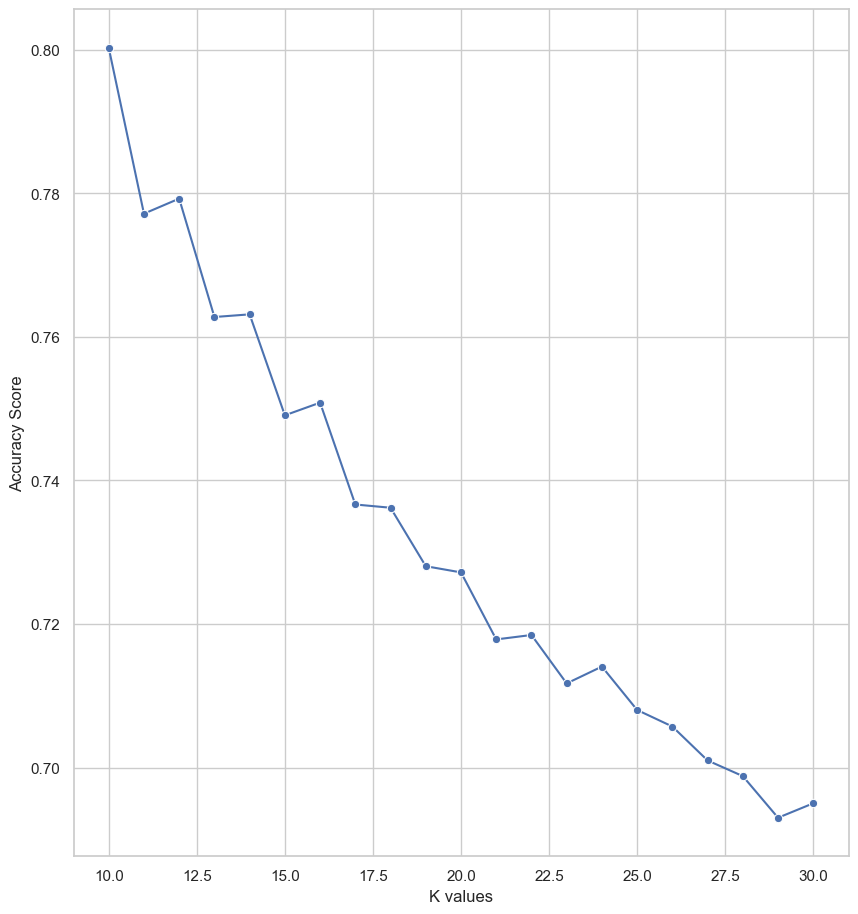

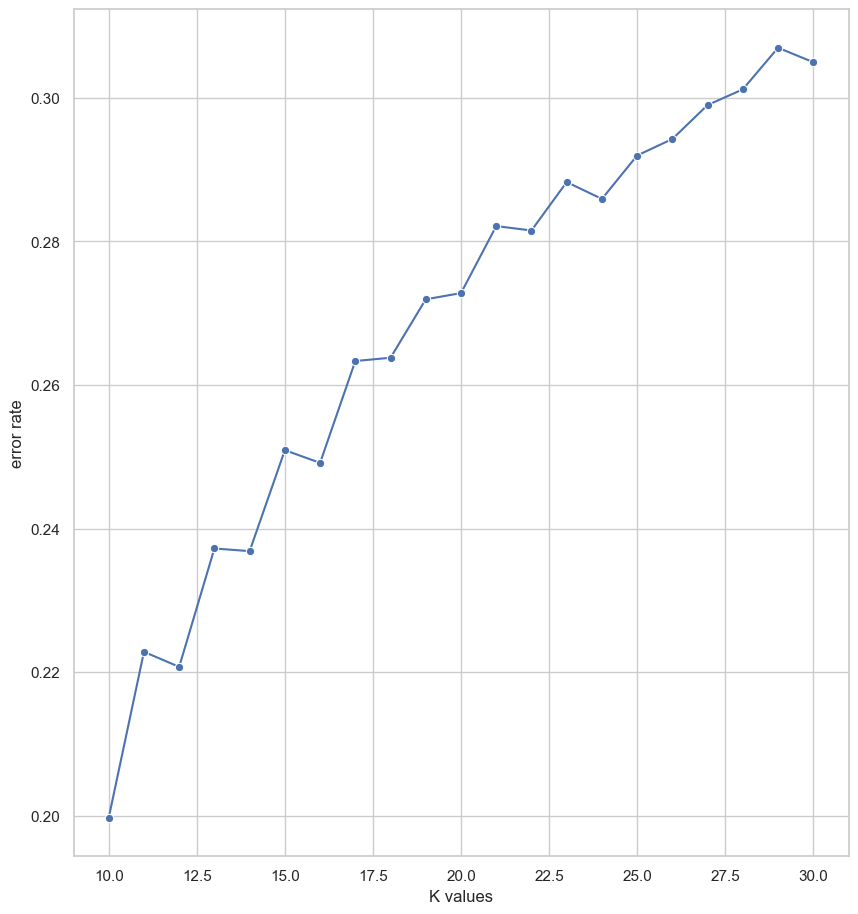

In [163]:
# kNN modelling to find best K value
k_values = [i for i in range (10,31)]
scores = []
error_rate = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    scores.append(knn.score(X_test, y_test))
    error_rate.append(np.mean(y_pred!=y_test))
    
sns.lineplot(x=k_values, y=scores, marker='o')
plt.xlabel('K values')
plt.ylabel('Accuracy Score')
plt.show()

sns.lineplot(x=k_values, y=error_rate, marker='o')
plt.xlabel('K values')
plt.ylabel('error rate')
plt.show()

In [164]:
# kNN modelling with best K value
best_index = np.argmax(scores)
best_k = k_values[best_index]

knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

print('\nK = ',best_k)
print('\nEvaluation: \n')
print(classification_report(y_test, y_pred))

print('\nkNN confusion matrix: \n')
cm = confusion_matrix(y_test,y_pred)
print(cm)


# Predict probabilities for the test data
y_prob = knn.predict_proba(X_test)

# Calculate cross-entropy loss
EPSILON = 1e-7
test_loss = -np.mean(y_test * np.log(y_prob[:, 1] + EPSILON) + (1 - y_test) * np.log(1 - y_prob[:, 1] + EPSILON))

print('\n')
print("Test loss: ", test_loss)

D:\Downloads\Anaconda\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)



K =  10

Evaluation: 

              precision    recall  f1-score   support

           0       0.91      0.67      0.77     12258
           1       0.74      0.93      0.82     12060

    accuracy                           0.80     24318
   macro avg       0.82      0.80      0.80     24318
weighted avg       0.82      0.80      0.80     24318


kNN confusion matrix: 

[[ 8254  4004]
 [  853 11207]]


Test loss:  0.5979356868871001
